### This tutorials analyzes the quality of deep deconv results using 2 criteria: pixel error and ellipticity error. It follows the tutorial_using_dnn

##### Set up the environment

In [1]:
from astropy.io import fits as fits
from matplotlib import pyplot as plt
import matplotlib
import numpy as np


In [2]:
## Set up the sys.path in order to be able to import our modules
import os
import sys
module_path = os.path.abspath(os.path.join('../python'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('/data/alpha-transform'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.environ["CUDA_VISIBLE_DEVICES"]="1" #"0" for the 1st GPU or "1" to use the 2nd

In [3]:
from DeepDeconv.deepnetFCS.DeepNet import DeepNet
from DeepDeconv.utils.batch_utils import get_batch_from_fits
import numpy as np
import glob,os,fnmatch


Using TensorFlow backend.
/home/cben-ali/Programs/deep-deconv/python/shape_constraint/cadmos_lib.py:149: ComplexWarning: Casting complex values to real discards the imaginary part
  coeff[s] = trafo.adjoint_transform(temp, do_norm=False)


In [4]:
matplotlib.rcParams['figure.figsize']=[12,8]



### 0) Set up all code needed

In [5]:
"""
Based on code written by alechat
"""

import os
from subprocess import Popen, PIPE

#This transforms a mosaic in extension idx_hdu and of size (gal_dim*sqrt(ngal),gal_dim*sqrt(ngal)) into a stamp_list 
def fits2npy(fits_file, idx_hdu,gal_dim=96,nb_gal=10000):
    '''Read .fits containing the psf'''
    data = fits.getdata(fits_file, idx_hdu)
    nb_gal_row = data.shape[0]//gal_dim
    data_list = []
    idx_list = range(0, nb_gal)
    for i in idx_list:
        y = (gal_dim*i)%(nb_gal_row*gal_dim)
        x = i//nb_gal_row * gal_dim
        data_list.append(data[x:x+gal_dim,y:y+gal_dim])
    return np.asarray(data_list)

#This translates a stamp_list [ngal,gal_dim,gal_dim,0] into a mosaic (gal_dim*sqrt(ngal),gal_dim*sqrt(ngal))
#Reverse operation of the previous function
def StampCollection2Mosaic(stamplist,gal_dim=96,nb_gal=10000):
    nb_gal_row = int(np.sqrt(nb_gal)) #nb galaxies per row
    mosaic=np.empty((nb_gal_row*gal_dim,nb_gal_row*gal_dim))
    for i in range(nb_gal):
        y = (gal_dim*i)%(nb_gal_row*gal_dim)
        x = i//nb_gal_row * gal_dim
        mosaic[x:x+gal_dim,y:y+gal_dim]=stamplist[i,:,:,0]
    return mosaic   

#This is the routine to compute the relative pixel error: ||X-Y||^2/(||Y||^2)
#hdu_target is the extension in the target_file containing the target
#We only compute the pixel error in a box centered on the galaxy (by default [28:69,28:69])
def compute_pixel_error(target_file, hdu_target, reconst_file, gal_dim=96, nb_gal=10000,xslice=slice(28,69,1),yslice=slice(28,69,1)):
    '''
    X: ground truth
    Y: estimated images
    '''
    nb_gal_row = int(np.sqrt(nb_gal)) #nb galaxies per row
    X = fits.getdata(target_file,hdu_target)
    Y = fits.getdata(reconst_file)
    DIFF=X-Y
    err = []
    for i in range(nb_gal):
        y = (gal_dim*i)%(nb_gal_row*gal_dim)
        x = i//nb_gal_row * gal_dim
        if gal_dim == 96:
            err.append((np.linalg.norm((DIFF[x:x+gal_dim,y:y+gal_dim])[xslice, 
                        yslice])**2)/(np.linalg.norm(X[x:x+gal_dim,y:y+gal_dim][xslice, yslice])**2))
        else:
            err.append((np.linalg.norm(DIFF[x:x+gal_dim,y:y+gal_dim])**2)/(np.linalg.norm(X[x:x+gal_dim,y:y+gal_dim])**2))
    return err


##### This is for ellipticity measurements

In [6]:
#This is the routine that call the C++ code to measure galaxy position, the shape of galaxies etc
def fast_generate_shape(gal_file, psf_file,output_file, cmd_file='get_shape.cmd', gal_dim=96, mosaic_size=100, save_weights='', weights_input=''):
    #print('Computing ellipticity for file: %s'%(gal_file))
    #print('Saving result in: %s'%(output_file))
    executable = '/data/shapelens_v2/shapelens-CEA-master/bin/get_shapes_output'
    if weights_input in '-o-i':
        cmd = '%s %s %s -p %s -g %d -s %d -T %s %s'%(executable, weights_input, save_weights, psf_file, mosaic_size, gal_dim, gal_file, output_file)
    else:
        cmd = '%s -p %s -g %d -s %d -T %s %s'%(executable, psf_file, mosaic_size, gal_dim, gal_file, output_file)
    print(cmd)
    try:
        os.remove(cmd_file)
    except OSError:
        pass
    f = open(cmd_file, 'w')
    f.write('#! /bin/bash\n')
    f.write('source /home/cben-ali/.bashrc\n')
    f.write(cmd)
    f.close()
    os.system('chmod 777 '+cmd_file)
    p = Popen('./'+cmd_file, stdout=PIPE, stderr=PIPE)
    stdout, stderr = p.communicate()
    return stdout, stderr


#Get the ellipticities measured from a file
def get_ellipticity(file_name):
    
    if".txt" in file_name:
        ellip = []
        with open(file_name, 'r') as f:
            data = f.readlines()
        for l in data:
            ellip.append(np.array(l.split('\t')[3:5]).astype(np.float32))
        ellip=np.asarray(ellip)
    elif ".fits" in file_name:
        tab=fits.getdata(file_name)
        ellip=np.array([tab["E1"],tab["E2"]]).T
    return ellip

#Compute ellipticity errors based on two file names
def compute_ellipticity_error(fileX, fileY, plot_hist=False, max_idx=10000):
    ellipX = get_ellipticity(fileX)[:max_idx]
    ellipY = get_ellipticity(fileY)[:max_idx]
    err = []
    for i in range(len(ellipY)):
        if (np.abs(ellipX[i]) > 1).any() or (np.abs(ellipY[i]) > 1).any():
            continue
        err.append(np.linalg.norm(ellipX[i]-ellipY[i]))
    if plot_hist:
        plt.figure()
        plt.hist(err, 100, range=(0,0.6))
        plt.show()
        print('Total samples = %d' %len(err))
    return err

#This is the ellipticity errors caused only be noise
def oracle_ellip(input_file, output_file, noise_std = 0):
    data = fits.getdata(input_file, 1)
    psf = fits.getdata(input_file, 3)
    if noise_std != 0:
        noise = np.random.normal(0, noise_std, size=data.shape)
        data += noise
    tmp_file = 'tmp'+str(np.random.randint(999))+'.fits'
    tmp_psf_file = 'tmp_psf'+str(np.random.randint(999))+'.fits'
    try:
        os.remove(tmp_file)
    except OSError:
        pass
    try:
        os.remove(tmp_psf_file)
    except OSError:
        pass
    fits.writeto(tmp_file, data)
    fits.writeto(tmp_psf_file, psf)
    generate_shape_txt(tmp_file, tmp_psf_file, output_file)
    try:
        os.remove(tmp_file)
    except OSError:
        pass
    try:
        os.remove(tmp_psf_file)
    except OSError:
        pass

##### This is the code used for parallelization

In [7]:
import sharedmem as sm
AFFINITY_FLAG = False

def sharedmem_pool(used_cores):
    # see https://stackoverflow.com/questions/15639779
    global AFFINITY_FLAG
    if not AFFINITY_FLAG:
        AFFINITY_FLAG = True
        os.system("taskset -p 0xfff %d" % os.getpid())
    if used_cores is None:
        used_cores = sm.cpu_count()-2
    return sm.MapReduce(np=used_cores)

print(sm.cpu_count())

8


### 1) Let's visualize the input simulated images, psfs, targets

In [8]:
    hdu_win=fits.ImageHDU(data=window)
    hdu_psf=fits.ImageHDU(data=psf)
    hdu_im=fits.PrimaryHDU(im0)
    hdul = fits.HDUList([hdu_im,hdu_psf,hdu_win])
    mosaic_name='image-shfl-0-multihdu_newtar.fits'
    hdul.writeto('/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/'+'window/'+mosaic_name,overwrite=True)

NameError: name 'window' is not defined

In [9]:
im1=fits.getdata("/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/window/image-shfl-0-multihdu_newtar.fits",noiseless_img_hdu)
psf1=fits.getdata("/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/window/image-shfl-0-multihdu_newtar.fits",psf_hdu)
tar=fits.getdata("/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/window/image-shfl-0-multihdu_newtar.fits",targets_hdu)
plt.imshow(im0[0:386,0:386],vmin=0,vmax=0.2)
plt.figure()
plt.imshow(psf1[0:386,0:386],vmin=0,vmax=0.01)
plt.figure()
plt.imshow(tar[0:386,0:386],vmin=0,vmax=0.2)
plt.figure()

NameError: name 'noiseless_img_hdu' is not defined

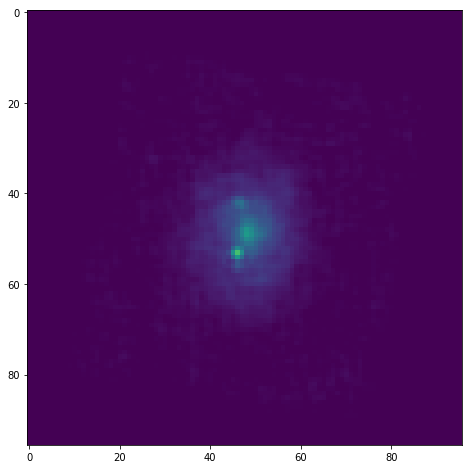

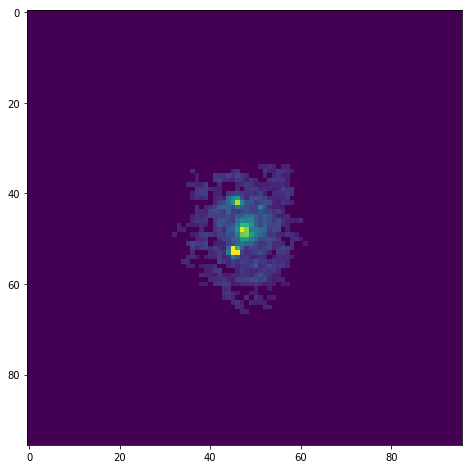

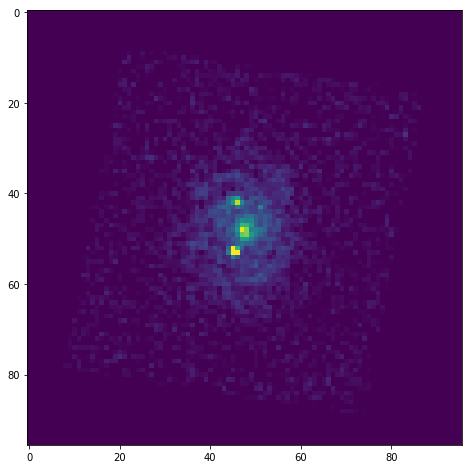

In [36]:
noiseless_img_hdu = 0
psf_hdu = 1
targets_hdu = 2
win_hdu=0

im0=fits.getdata("/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/new_targets/image-shfl-00-multihdu_newtar.fits",noiseless_img_hdu)
##psf=fits.getdata("/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/new_targets/image-shfl-00-multihdu_newtar.fits",psf_hdu)
target=fits.getdata("/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/new_targets/image-shfl-00-multihdu_newtar.fits",targets_hdu)

old_tar=fits.getdata("/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-00-multihdu.fits",targets_hdu)

plt.imshow(im0[96:96*2,5568:5664],vmin=0,vmax=0.5)
plt.figure()
#plt.imshow(psf[0:386,0:386],vmin=0,vmax=0.01)
#plt.figure()
plt.imshow(target[96:96*2,5568:5664],vmin=0,vmax=0.5)
plt.figure()

plt.imshow(old_tar[96:96*2,5568:5664],vmin=0,vmax=0.5)


### 2) Now we need to produce the DNN outputs for different SNRs

In [8]:
## extra imports to set GPU options
import tensorflow as tf
from keras import backend as backk

###################################
# TensorFlow wizardry
config = tf.ConfigProto()
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True

# Only allow a total of half the GPU memory to be allocated
# This line is optional, don't add it unless you really need to set a limit on the memory available for your process
# For instance, if you want to train 2 DNNs on the same GPU without one overlapping the memory needed by the other
# Change the value to set the percentage of memory allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.47 

# Create a session with the above options specified.
backk.tensorflow_backend.set_session(tf.Session(config=config))

# Now you can create/load your DNN

##### We set up the input dir, target name, network we want to process

In [9]:
write_path="/data/DeepDeconv/benchmark/claire/"
testset_file = 'new_targets/image-shfl-00-multihdu_newtar.fits'#image of 10000 galaxies used for testing
# Input the hdf5 file, here we load a network trained on Tikhonov
net_path= '/home/cben-ali/Programs/deep-deconv/tutorials/'
net_file = 'DeconvNet_tuto_copy.hdf5' #network to analyse
net_root=net_file.replace('.hdf5','')
target_name=testset_file#Image collecting all targets
#The following is the data directory
data_directory = '/data/DeepDeconv/data/vsc_euclidpsfs/'

# Input the file containing the galaxies and psfs for testing
testset_path = '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/new_targets/'
testset_file = 'image-shfl-00-multihdu_newtar.fits'
win_path='/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/Target_Window/'
win_file='Target_window_claire_00.fits'

noiseless_img_hdu = 0
psf_hdu = 1
targets_hdu = 2

#which list of networks we want to process
net_file_list=[  'ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.01_Target_Window.hdf5',
 'ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.01_Target_window_iter1.hdf5',
 
 'ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.01_Target_window_iter2.hdf5',
 'ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.01_Target_Window_iter3.hdf5',
 'ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.01_Target_Window_iter4.hdf5']
               #'ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma500_shearlet.hdf5',
               #'ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma100_shearlet.hdf5',
               #'ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.01_shearlet.hdf5',
               #'ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma50_shearlet.hdf5']

#which SNR we want to investigate
SNR_list_sim=[20,40,60,80,100]#all of them:[20,40,60,80,100]



In [117]:
test0=fits.getdata("/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-0-multihdu.fits",2)
test1=fits.getdata(testset_path+testset_file,2)

In [118]:
np.max(np.abs(test0-test1))

3.193281412124634

In [9]:
for i in range(10):
    for SNR_sim in SNR_list_sim:
        name = 'Errorbar_plot_iteration{0}_SNR{1}'.format(i,SNR_sim)
        test_data, target_data, weights_data= get_batch_from_fits(testset_path+testset_file, 
                                                                      idx_list=np.arange(10000), SNR=SNR_sim,
                                                                      noiseless_img_hdu=noiseless_img_hdu,
                                                                      targets_hdu=targets_hdu,
                                                                      psf_hdu=psf_hdu, image_dim=96, 
                                                                      image_per_row=100, 
                                                                      deconv_mode=deconv_mode,
                                                                      risktype=risktype,reg=reg,
                                                                      tol=tol,reg_frac=reg_frac,
                                                                      shearlet=True)
        np.save(write_path+'images/'+name,test_data)
        

NameError: name 'deconv_mode' is not defined

In [38]:
test_data

NameError: name 'test_data' is not defined

##### The following is for propagating the test image through the network

In [10]:
from DeepDeconv.deepnetFCS.DeepNet import DeepNet
from DeepDeconv.utils.batch_utils import get_batch_from_fits
import numpy as np
import glob,os,fnmatch

tol=1e-12
for net_file in net_file_list:
    print("net_file={0}".format(net_file))
    for SNR_sim in SNR_list_sim:
        #Load input test for given SNR
        mosaic_name=testset_file.replace('.fits','-'+net_file.replace('.hdf5','_testSNR{0}.fits'.format(SNR_sim)))
        if os.path.isfile(write_path+'images/'+mosaic_name):#Case it has already been processed
            print("Do not process {0}".format(mosaic_name))
        else:
            print("Process {0}".format(mosaic_name))
            if "risk" in net_file:#Case we have automated Tikhonov hyperparam choice
                deconv_mode="TIKHONOV_HYP"
                if "GCV" in net_file:
                    risktype="GCV"
                elif "SurePred" in net_file:
                    risktype="SurePred"
                elif "SureProj" in net_file:
                    risktype="SureProj"
                    if("tole-12" in net_file):
                        tol=1e-12
                    if("tole-3" in net_file):
                        tol=1e-3
                elif "Pereyra" in net_file:
                    risktype="Pereyra"
                else: #No hyperparameter choice
                    risktype=None
                    deconv_mode="TIKHONOV"
                if "regDirac" in net_file:
                    reg="Dirac"
                elif "regLap" in net_file:
                    reg="Lap"
                else:
                    reg=None
                if "regfrac" in net_file:
                    reg_frac=float(net_file.split("regfrac")[1].split("_")[0].replace('p','.'))
                    print("reg_frac={0}".format(reg_frac))
            else:#No hyperparameter choice
                risktype=None
                reg=None
                reg_frac=None
                deconv_mode="TIKHONOV"
            print("Deconv:",deconv_mode,risktype,reg,tol)
            #extract the whole image of galaxies at given SNR
            test_data, target_data, weights_data= get_batch_from_fits(testset_path+testset_file, 
                                                                      idx_list=np.arange(10000), SNR=SNR_sim,
                                                                      noiseless_img_hdu=noiseless_img_hdu,
                                                                      targets_hdu=targets_hdu,
                                                                      psf_hdu=psf_hdu, image_dim=96, 
                                                                      image_per_row=100, 
                                                                      deconv_mode=deconv_mode,
                                                                      risktype=risktype,reg=reg,
                                                                      tol=tol,reg_frac=reg_frac,
                                                                      shape_constraint=True,win_filename=win_path+win_file)
            if 'dnn' not in locals():#load dnn
                dnn = DeepNet(model_file=net_path+net_file, shape_constraint=True, gamma=0) #dnn is instance of DeepNet class
            #Use dnn for prediction
            dnn_reconstruction = dnn.predict(test_data, verbose=1)
            #collect all outputs as a mosaic and save them as a fits files.
            mosaic=StampCollection2Mosaic(dnn_reconstruction)
            hdu_dnn=fits.PrimaryHDU(mosaic)
            hdul = fits.HDUList([hdu_dnn])
            hdul.writeto(write_path+'images/'+mosaic_name,overwrite=True)
    if 'dnn' in locals():#clear dnn
        del dnn


net_file=ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.01_Target_Window.hdf5
Process image-shfl-00-multihdu_newtar-ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.01_Target_Window_testSNR20.fits
Deconv: TIKHONOV None None 1e-12
Loading model...
/home/cben-ali/Programs/deep-deconv/tutorials/ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.01_Target_Window.hdf5
Renaming as...
/home/cben-ali/Programs/deep-deconv/tutorials/ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.01_Target_Window
Tensor("loss/conv2d_32_loss/strided_slice:0", shape=(96, 96), dtype=float32) Tensor("window:0", shape=(?, 96, 96, 1), dtype=float32) Tensor("norm:0", shape=(?, 6, 1, 1), dtype=float32) Tensor("loss/conv2d_32_loss/sub:0", shape=(?, 96, 96, ?), dtype=float32)
10000/10000 [==============================] - 1270s 127ms/step
Process image-shfl-00-multihdu_newtar-ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_s

KeyboardInterrupt: 

This is for 10 iterations

In [16]:
from DeepDeconv.deepnetFCS.DeepNet import DeepNet
from DeepDeconv.utils.batch_utils import get_batch_from_fits
import numpy as np
import glob,os,fnmatch

tol=1e-12
if 'dnn' in locals():#clear dnn
    del dnn
for net_file in net_file_list:
    print("net_file={0}".format(net_file))
    for i in range(10):
        for SNR_sim in SNR_list_sim:
            name= 'Errorbar_plot_iteration{0}_SNR{1}'.format(i,SNR_sim)
            test_data=np.load(write_path+'images/'+name+".npy")
            #Load input test for given SNR
            mosaic_name=testset_file.replace('.fits','-'+net_file.replace('.hdf5','_testSNR{0}_iteration{1}.fits'.format(SNR_sim,i)))
            if os.path.isfile(write_path+'images/'+mosaic_name):#Case it has already been processed
                print("Do not process {0}".format(mosaic_name))
            else:
                print("Process {0}".format(mosaic_name))
                if "risk" in net_file:#Case we have automated Tikhonov hyperparam choice
                    deconv_mode="TIKHONOV_HYP"
                    if "GCV" in net_file:
                        risktype="GCV"
                    elif "SurePred" in net_file:
                        risktype="SurePred"
                    elif "SureProj" in net_file:
                        risktype="SureProj"
                        if("tole-12" in net_file):
                            tol=1e-12
                        if("tole-3" in net_file):
                            tol=1e-3
                    elif "Pereyra" in net_file:
                        risktype="Pereyra"
                    else: #No hyperparameter choice
                        risktype=None
                        deconv_mode="TIKHONOV"
                    if "regDirac" in net_file:
                        reg="Dirac"
                    elif "regLap" in net_file:
                        reg="Lap"
                    else:
                        reg=None
                    if "regfrac" in net_file:
                        reg_frac=float(net_file.split("regfrac")[1].split("_")[0].replace('p','.'))
                        print("reg_frac={0}".format(reg_frac))
                else:#No hyperparameter choice
                    risktype=None
                    reg=None
                    reg_frac=None
                    deconv_mode="TIKHONOV"
                print("Deconv:",deconv_mode,risktype,reg,tol)
                #extract the whole image of galaxies at given SNR
                if 'dnn' not in locals():#load dnn
                    dnn = DeepNet(model_file=net_path+net_file, shearlet=True, gamma=1) #dnn is instance of DeepNet class
                #Use dnn for prediction
                dnn_reconstruction = dnn.predict(test_data, verbose=1)
                #collect all outputs as a mosaic and save them as a fits files.
                mosaic=StampCollection2Mosaic(dnn_reconstruction)
                hdu_dnn=fits.PrimaryHDU(mosaic)
                hdul = fits.HDUList([hdu_dnn])
                hdul.writeto(write_path+'images/'+mosaic_name,overwrite=True)
        if 'dnn' in locals():#clear dnn
            del dnn




net_file=ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.1_shearlet.hdf5


FileNotFoundError: [Errno 2] No such file or directory: '/data/DeepDeconv/benchmark/claire/images/Errorbar_plot_iteration0_SNR20.npy'

In [45]:
dnn=DeepNet(model_file='ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.1_shearlet_iter1.hdf5',shearlet=True,gamma=1)


Loading model...
ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.1_shearlet_iter1.hdf5
Renaming as...
ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.1_shearlet_iter1
loss (None, 96, 96)
temp (None, 1, 1)
<class 'tensorflow.python.framework.ops.Tensor'>
loss (None, 96, 96)
temp (None, 1, 1)


In [50]:
print('weights0',weights0[0])
print('weights1',weights1[0])

weights0 [[[[ 1.92793868e-02 -3.09992850e-01  7.86428712e-03 -7.06361294e-01
     6.62375093e-01 -1.98661715e-01 -2.50459194e-01  4.27795410e-01
    -1.60854876e-01  1.51613797e-03 -1.42056867e-03 -1.31057069e-01
     6.69504046e-01  2.87143230e-01  5.13250053e-01  4.87446040e-02
    -4.04531837e-01 -5.95675349e-01  5.31315446e-01  8.30613002e-02
     7.36060500e-01  1.24502011e-01 -1.75343379e-01  1.94316372e-01
    -7.92791322e-02  1.05307311e-01  2.85024866e-02  3.60671550e-01
    -1.86988294e-01  1.87520370e-01 -1.63951293e-02  3.41918975e-01]]

  [[ 1.39567345e-01  1.86754808e-01  2.25811839e-01  7.52818882e-01
     1.13054931e+00 -3.29152554e-01 -8.21290791e-01  4.99108672e-01
    -5.08873284e-01  8.28961134e-02  8.39305073e-02 -6.36067688e-01
    -7.73586750e-01 -4.85862605e-02 -7.17285991e-01 -1.51451752e-01
     2.03034118e-01 -1.07618427e+00 -5.95680416e-01 -5.88644505e-01
     1.32174528e+00 -2.05704533e-02  3.81362259e-01 -6.74938709e-02
     1.53283879e-01 -1.97938189e-01 

In [30]:
net_file_list=['ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.1_shearlet.hdf5',
              'ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0_shearlet.hdf5']

SNR=100
from DeepDeconv.deepnetFCS.DeepNet import DeepNet
from DeepDeconv.utils.batch_utils import get_batch_from_fits
import numpy as np
import glob,os,fnmatch
deconv_mode='TIKHONOV'
risktype=None
reg=None
tol=1e-12
reg_frac=1.0
noise_std=0.04

if 'dnn' in locals():#clear dnn
    del dnn
tol=1e-12

test_data, target_data, weights_data= get_batch_from_fits(testset_path+testset_file, 
                                                                      idx_list=np.arange(10000), SNR=100,
                                                                      noiseless_img_hdu=noiseless_img_hdu,
                                                                      targets_hdu=targets_hdu,
                                                                      psf_hdu=psf_hdu, image_dim=96, 
                                                                      image_per_row=100, 
                                                                      deconv_mode=deconv_mode,
                                                                      risktype=risktype,reg=reg,
                                                                      tol=tol,reg_frac=reg_frac,
                                                                      shearlet=True)
for net_file in net_file_list:
    if 'dnn' in locals():#clear dnn
        del dnn
    print("net_file={0}".format(net_file))
    #Load input test for given SNR
    mosaic_name=testset_file.replace('.fits','-'+net_file.replace('.hdf5','_testSNR{0}.fits'.format(SNR)))
    if os.path.isfile(write_path+'images/'+mosaic_name):#Case it has already been processed
        print("Do not process {0}".format(mosaic_name))
    else:
        print("Process {0}".format(mosaic_name))
        if "risk" in net_file:#Case we have automated Tikhonov hyperparam choice
            deconv_mode="TIKHONOV_HYP"
            if "GCV" in net_file:
                risktype="GCV"
            elif "SurePred" in net_file:
                risktype="SurePred"
            elif "SureProj" in net_file:
                risktype="SureProj"
                if("tole-12" in net_file):
                    tol=1e-12
                if("tole-3" in net_file):
                    tol=1e-3
            elif "Pereyra" in net_file:
                risktype="Pereyra"
            else: #No hyperparameter choice
                risktype=None
                deconv_mode="TIKHONOV"
            if "regDirac" in net_file:
                reg="Dirac"
            elif "regLap" in net_file:
                reg="Lap"
            else:
                reg=None
            if "regfrac" in net_file:
                reg_frac=float(net_file.split("regfrac")[1].split("_")[0].replace('p','.'))
                print("reg_frac={0}".format(reg_frac))
        else:#No hyperparameter choice
            risktype=None
            reg=None
            reg_frac=None
            deconv_mode="TIKHONOV"
        print("Deconv:",deconv_mode,risktype,reg,tol)
        #extract the whole image of galaxies at given SNR
        if 'dnn' not in locals():#load dnn
            dnn = DeepNet(model_file=net_path+net_file, shearlet=True, gamma=1) #dnn is instance of DeepNet class
        #Use dnn for prediction
        dnn_reconstruction = dnn.predict(test_data, verbose=1)
        #collect all outputs as a mosaic and save them as a fits files.
        mosaic=StampCollection2Mosaic(dnn_reconstruction)
        hdu_dnn=fits.PrimaryHDU(mosaic)
        hdul = fits.HDUList([hdu_dnn])
        hdul.writeto(write_path+'images/'+mosaic_name,overwrite=True)
if 'dnn' in locals():#clear dnn
    del dnn

net_file=ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.1_shearlet.hdf5
Do not process image-shfl-00-multihdu_newtar-ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.1_shearlet_testSNR100.fits
net_file=ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0_shearlet.hdf5
Process image-shfl-00-multihdu_newtar-ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0_shearlet_testSNR100.fits
Deconv: TIKHONOV None None 1e-12
Loading model...
/home/cben-ali/Programs/deep-deconv/tutorials/ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0_shearlet.hdf5
Renaming as...
/home/cben-ali/Programs/deep-deconv/tutorials/ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0_shearlet
loss (None, 96, 96)
temp (None, 1, 1)
<class 'tensorflow.python.framework.ops.Tensor'>
loss (None, 96, 96)
temp (None, 1, 1)
10000/10000 [==============================] - 495s 50ms/step


In [29]:
net_file_list=['ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_test_ref_restart_newtar_gfiles.hdf5',
               'ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.001_newtar_gfiles.hdf5']
SNR=100
from DeepDeconv.deepnetFCS.DeepNet import DeepNet
from DeepDeconv.utils.batch_utils import get_batch_from_fits
import numpy as np
import glob,os,fnmatch
deconv_mode='TIKHONOV'
risktype=None
reg=None
tol=1e-12
reg_frac=1.0
noise_std=0.04

if 'dnn' in locals():#clear dnn
    del dnn
tol=1e-12

test_data, target_data, weights_data= get_batch_from_fits(testset_path+testset_file, 
                                                                      idx_list=np.arange(10000), SNR=100,
                                                                      noiseless_img_hdu=noiseless_img_hdu,
                                                                      targets_hdu=targets_hdu,
                                                                      psf_hdu=psf_hdu, image_dim=96, 
                                                                      image_per_row=100, 
                                                                      deconv_mode=deconv_mode,
                                                                      risktype=risktype,reg=reg,
                                                                      tol=tol,reg_frac=reg_frac,
                                                                      shape_constraint=True,win_filename=win_path+win_file)
for net_file in net_file_list:
    if 'dnn' in locals():#clear dnn
        del dnn
    print("net_file={0}".format(net_file))
    #Load input test for given SNR
    mosaic_name=testset_file.replace('.fits','-'+net_file.replace('.hdf5','_testSNR{0}.fits'.format(SNR)))
    if os.path.isfile(write_path+'images/'+mosaic_name):#Case it has already been processed
        print("Do not process {0}".format(mosaic_name))
    else:
        print("Process {0}".format(mosaic_name))
        if "risk" in net_file:#Case we have automated Tikhonov hyperparam choice
            deconv_mode="TIKHONOV_HYP"
            if "GCV" in net_file:
                risktype="GCV"
            elif "SurePred" in net_file:
                risktype="SurePred"
            elif "SureProj" in net_file:
                risktype="SureProj"
                if("tole-12" in net_file):
                    tol=1e-12
                if("tole-3" in net_file):
                    tol=1e-3
            elif "Pereyra" in net_file:
                risktype="Pereyra"
            else: #No hyperparameter choice
                risktype=None
                deconv_mode="TIKHONOV"
            if "regDirac" in net_file:
                reg="Dirac"
            elif "regLap" in net_file:
                reg="Lap"
            else:
                reg=None
            if "regfrac" in net_file:
                reg_frac=float(net_file.split("regfrac")[1].split("_")[0].replace('p','.'))
                print("reg_frac={0}".format(reg_frac))
        else:#No hyperparameter choice
            risktype=None
            reg=None
            reg_frac=None
            deconv_mode="TIKHONOV"
        print("Deconv:",deconv_mode,risktype,reg,tol)
        #extract the whole image of galaxies at given SNR
        if 'dnn' not in locals():#load dnn
            dnn = DeepNet(model_file=net_path+net_file, shape_constraint=True, gamma=1) #dnn is instance of DeepNet class
        #Use dnn for prediction
        dnn_reconstruction = dnn.predict(test_data, verbose=1)
        #collect all outputs as a mosaic and save them as a fits files.
        mosaic=StampCollection2Mosaic(dnn_reconstruction)
        hdu_dnn=fits.PrimaryHDU(mosaic)
        hdul = fits.HDUList([hdu_dnn])
        hdul.writeto(write_path+'images/'+mosaic_name,overwrite=True)
if 'dnn' in locals():#clear dnn
    del dnn

net_file=ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_test_ref_restart_newtar_gfiles.hdf5
Process image-shfl-00-multihdu_newtar-ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_test_ref_restart_newtar_gfiles_testSNR100.fits
Deconv: TIKHONOV None None 1e-12
Loading model...
/home/cben-ali/Programs/deep-deconv/tutorials/ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_test_ref_restart_newtar_gfiles.hdf5
Renaming as...
/home/cben-ali/Programs/deep-deconv/tutorials/ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_test_ref_restart_newtar_gfiles
Tensor("loss_4/conv2d_24_loss/strided_slice:0", shape=(96, 96), dtype=float32) Tensor("window_2:0", shape=(?, 96, 96, 1), dtype=float32) Tensor("norm_2:0", shape=(?, 6, 1, 1), dtype=float32) Tensor("loss_4/conv2d_24_loss/sub:0", shape=(?, 96, 96, ?), dtype=float32)
10000/10000 [==============================] - 423s 42ms/step
net_file=ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.001_newtar

#### From here, we do not need deep learning  anymore

In [10]:
from DeepDeconv.deepnetFCS.DeconvNet_custom import DeconvNet

#### Now look at results 

image-shfl-00-multihdu_newtar-ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.001_newtar_gfiles_testSNR100.fits


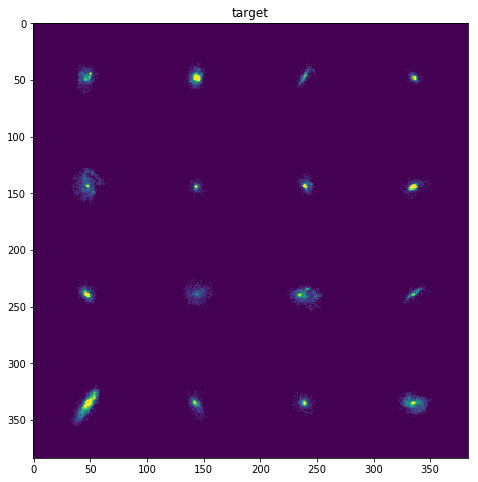

<Figure size 864x576 with 0 Axes>

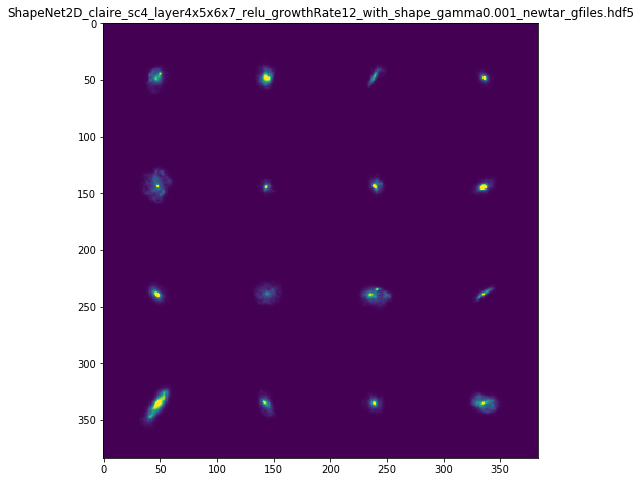

In [41]:
SNR_sim=100

target=fits.getdata("/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/new_targets/image-shfl-00-multihdu_newtar.fits",targets_hdu)
#test1=fits.getdata(write_path+'images/'+'image-shfl-00-multihdu_newtar-ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.1_shearlet_iter4_testSNR100.fits',0)
#test2=fits.getdata(write_path+'images/'+'image-shfl-00-multihdu_newtar-ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.1_shearlet_iter2_testSNR100.fits',0)

plt.imshow(target[0:384,0:384],vmin=0,vmax=0.5)
plt.title('target')
plt.figure()
#plt.imshow((test1-test2)[0:384,0:384],cmap='gist_stern',vmin=0,vmax=0.5)
#plt.title('res')
#plt.figure()
                   
for net_file in net_file_list:
    plt.figure()
    mosaic_name=testset_file.replace('.fits','-'+net_file.replace('.hdf5','_testSNR{0}.fits'.format(SNR_sim)))
    print(mosaic_name)
    restore_data=fits.getdata(write_path+'images/'+mosaic_name)
    plt.imshow(restore_data[0:384,0:384],vmin=0,vmax=0.5)
    plt.title(net_file)
    



### 3) Let's start with pixel error

##### We can start by checking how noise only impacts pixel error.

In [36]:
target_name_win='image-shfl-00-multihdu_newtar.fits'

In [ ]:
from DeepDeconv.utils.batch_utils import get_batch_from_fits
used_cores=np.min((len(SNR_list_sim),sm.cpu_count()-2))  #we use one core per SNR if we have enough cores

SNR_list_sim=[20,40,60,80,100] #among [20,40,60,80,100] #List of SNR to be simulated

#We parallelize over SNR list
with sharedmem_pool(used_cores) as pool:
    def work(i):
        SNR_sim=SNR_list_sim[i]
        #This is the image+noise data
        mosaic_name=(target_name.replace('00','0')).replace('.fits','_SNR{0}.fits'.format(SNR_sim))
        if os.path.isfile(write_path+'images/'+mosaic_name):
            write_txt_name=write_path+'stats/'+mosaic_name.replace('.fits','_pixelerr.txt')
            if not os.path.isfile(write_txt_name):
                with pool.critical:
                    print("Compute Pixel error {0}".format(mosaic_name) )
                #We compute the error between target and target+noise in a centered slice for each gal
                err=compute_pixel_error(write_path+'images/'+target_name, 0, write_path+'images/'+mosaic_name, gal_dim=96, nb_gal=10000,xslice=slice(28,69,1),yslice=slice(28,69,1))
                np.savetxt(write_txt_name,np.array(err))
            else:
                err=np.loadtxt(write_txt_name)
            with pool.critical:
                print(net_file," SNR=",SNR_sim,"MEAN_ERR=",np.median(err),"MEDIAN_ERR=",np.median(err))
        else:
            with pool.critical:
                print("not existing {0}".format(mosaic_name) )    

    pool.map(work, range(len(SNR_list_sim)))
        
    




##### Then we can compute the pixel error for the network outputs, parallelized over the different SNRs

In [16]:
net_file_list=['ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0_shearlet.hdf5',
               'ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.01_shearlet.hdf5',
               'ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.05_shearlet.hdf5',
               'ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.1_shearlet.hdf5',
               'ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.5_shearlet.hdf5',
               'ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma1_shearlet.hdf5',
               'ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma5_shearlet.hdf5',
               'ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma10__new_shearlet.hdf5',
               'ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma20_shearlet.hdf5',
               'ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma50_shearlet.hdf5',
               'ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma100_shearlet.hdf5',
               'ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma500_shearlet.hdf5']



In [28]:
dic = {}
dic[0]={}
dic[0]['l']='str'

In [34]:
pixerr

{'ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0_shearlet.hdf5': {20: {0: 0.09544344013517242,
   1: 0.09568494953580936,
   2: 0.09610649435322727,
   3: 0.09623979467771732,
   4: 0.09583091865807256,
   5: 0.09600076202117389,
   6: 0.09659191478202592,
   7: 0.09605783822817482,
   8: 0.09537764528878295,
   9: 0.09663010522258395},
  40: {0: 0.057579681343234726,
   1: 0.05716328459992567,
   2: 0.057489496634473385,
   3: 0.05741581215511064,
   4: 0.057698263674385686,
   5: 0.057048278487074035,
   6: 0.05729993337291771,
   7: 0.05759455257735635,
   8: 0.05671743173548205,
   9: 0.05690613371554548},
  60: {0: 0.044718720281608094,
   1: 0.0445800694635556,
   2: 0.04447203176947262,
   3: 0.044673193195571996,
   4: 0.04447545453916646,
   5: 0.04455821793847531,
   6: 0.044719396119205945,
   7: 0.04461157020190887,
   8: 0.044572280558534044,
   9: 0.044279375477381214},
  80: {0: 0.03794272846078178,
   1: 0.03809566640926017,
   2: 0.0380326103517

In [36]:
n=len(net_file_list)
pixerr={}
for net_file in range(n):
    pixerr[net_file_list[net_file]]={}
    for i in range(5):
        pixerr[net_file_list[net_file]][SNR_list_sim[i]]={}
        SNR_sim=SNR_list_sim[i]
        for j in range(10):
            if net_file==3 and j==0:
                continue
            else:
                mosaic_name=testset_file.replace('.fits','-'+net_file_list[net_file].replace('.hdf5','_testSNR{0}_iteration{1}.fits'.format(SNR_sim,j)))
                write_txt_name=write_path+'stats/'+mosaic_name.replace('.fits','_pixelerr_newwin.txt')
                err=np.loadtxt(write_txt_name)
                pixerr[net_file_list[net_file]][SNR_list_sim[i]][j]=np.median(err)

             

OSError: /data/DeepDeconv/benchmark/claire/stats/image-shfl-00-multihdu_newtar-ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.1_shearlet_testSNR20_iteration0_pixelerr_newwin.txt not found.

In [18]:
net_file_list=['ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.1_shearlet.hdf5',
              'ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.1_shearlet_iter1.hdf5',
              'ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.1_shearlet_iter2.hdf5',
              'ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.1_shearlet_iter3.hdf5',
              'ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.1_shearlet_iter4.hdf5']

n=len(net_file_list)
pixerr=np.zeros((5,5))
for net_file in range(n):
    for i in range(5):
        SNR_sim=SNR_list_sim[i]
        mosaic_name=testset_file.replace('.fits','-'+net_file_list[net_file].replace('.hdf5','_testSNR{0}.fits'.format(SNR_sim)))
        write_txt_name=write_path+'stats/'+mosaic_name.replace('.fits','_pixelerr_newwin.txt')
        err=np.loadtxt(write_txt_name)
        pixerr[net_file][i]=np.median(err)


In [19]:
pixerr


array([[0.09510118, 0.05668594, 0.04462284, 0.03762908, 0.0337721 ],
       [0.0988968 , 0.05684978, 0.04432404, 0.03772025, 0.03392567],
       [0.11046363, 0.05800664, 0.04495243, 0.03793207, 0.03419192],
       [0.09691902, 0.05732303, 0.04484714, 0.03793491, 0.03386715],
       [0.09673764, 0.05780599, 0.04501282, 0.03783959, 0.033829  ]])

<ErrorbarContainer object of 3 artists>

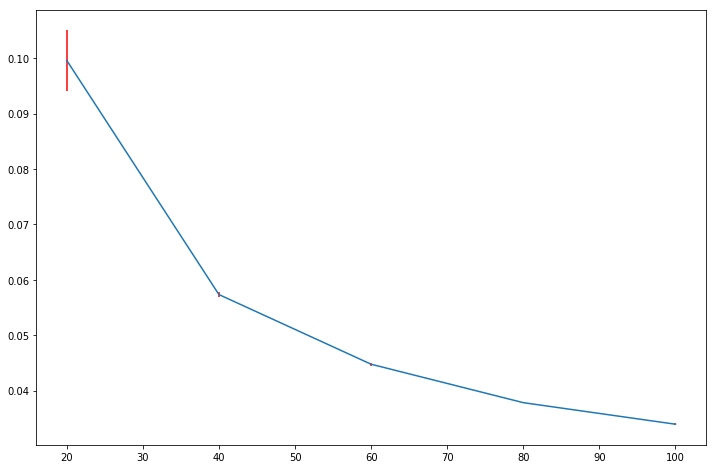

In [21]:
SNR=[20,40,60,80,100]

mean=[]
std=[]
for i in range(5):
    mean.append(np.mean(pixerr[:,i]))
    std.append(np.std(pixerr[:,i]))
plt.errorbar(SNR,mean,std,ecolor="red")

    

In [45]:
    nb_gal_row = 100 #nb galaxies per row
    nb_gal=10000
    gal_dim=96
    xslice=slice(28,69,1)
    yslice=slice(28,69,1)
    X = fits.getdata(testset_path+'image-shfl-00-multihdu_newtar.fits',2)
    Y = np.load('/data/DeepDeconv/benchmark/claire/images/mosaic_OSCAR_RIPdeconv.npy')
    DIFF=X-Y
    err = []
    for i in range(nb_gal):
        y = (96*i)%(nb_gal_row*96)
        x = i//nb_gal_row * 96
        if gal_dim == 96:
            err.append((np.linalg.norm((DIFF[x:x+gal_dim,y:y+gal_dim])[xslice, 
                        yslice])**2)/(np.linalg.norm(X[x:x+gal_dim,y:y+gal_dim][slice(28,69,1), slice(28,69,1)])**2))
        else:
            err.append((np.linalg.norm(DIFF[x:x+gal_dim,y:y+gal_dim])**2)/(np.linalg.norm(X[x:x+gal_dim,y:y+gal_dim])**2))
    print(np.median(err))


0.12898564327312503


In [43]:
net_file_list=['mosaic_OSCAR_RIPdeconv.npy']
used_cores=np.min((len(SNR_list_sim),sm.cpu_count()-2))  #we use one core per SNR if we have enough cores
for net_file in net_file_list:
    print(net_file)
    with sharedmem_pool(used_cores) as pool:
        def work(i):
            #Load input test for given SNR
            SNR_sim=SNR_list_sim[i]
            mosaic_name='mosaic_OSCAR_RIPdeconv.npy'
            #mosaic_name=testset_file.replace('.fits','-'+net_file.replace('.hdf5','_testSNR{0}.fits'.format(SNR_sim)))
            if os.path.isfile(write_path+'images/'+mosaic_name):
                write_txt_name=write_path+'stats/'+mosaic_name.replace('.fits','_pixelerr_newwin.txt')
                if not os.path.isfile(write_txt_name):
                    with pool.critical:
                        print("Compute Pixel error {0}".format(mosaic_name) )
                    err=compute_pixel_error(testset_path+target_name_win, 2, write_path+'images/'+mosaic_name, gal_dim=96, nb_gal=10000,xslice=slice(28,69,1),yslice=slice(28,69,1))
                    np.savetxt(write_txt_name,np.array(err))
                else:
                    #if it has already been measured, just print, do not recompute
                    err=np.loadtxt(write_txt_name)
                with pool.critical:
                    #Display results
                    print(net_file," SNR=",SNR_sim,"MEAN_ERR=",np.median(err),"MEDIAN_ERR=",np.median(err))
            else:
                with pool.critical:
                    print("not existing {0}".format(mosaic_name) )

        pool.map(work, range(len(SNR_list_sim)))
        

mosaic_OSCAR_RIPdeconv.npy
Compute Pixel error mosaic_OSCAR_RIPdeconv.npy
Compute Pixel error mosaic_OSCAR_RIPdeconv.npy
Compute Pixel error mosaic_OSCAR_RIPdeconv.npy
Compute Pixel error mosaic_OSCAR_RIPdeconv.npy
Compute Pixel error mosaic_OSCAR_RIPdeconv.npy


SlaveException: Header missing END card.
Traceback (most recent call last):
  File "/local/home/fsureau/miniconda3/envs/tfenv/lib/python3.6/site-packages/sharedmem/sharedmem.py", line 294, in _slaveMain
    self.main(self, *self.args)
  File "/local/home/fsureau/miniconda3/envs/tfenv/lib/python3.6/site-packages/sharedmem/sharedmem.py", line 628, in _main
    r = realfunc(work)
  File "/local/home/fsureau/miniconda3/envs/tfenv/lib/python3.6/site-packages/sharedmem/sharedmem.py", line 703, in realfunc
    else: return func(i)
  File "<ipython-input-43-7bb2c9505734>", line 16, in work
    err=compute_pixel_error(testset_path+target_name_win, 2, write_path+'images/'+mosaic_name, gal_dim=96, nb_gal=10000,xslice=slice(28,69,1),yslice=slice(28,69,1))
  File "<ipython-input-5-7df4e3569f0d>", line 42, in compute_pixel_error
    Y = fits.getdata(reconst_file)
  File "/local/home/fsureau/miniconda3/envs/tfenv/lib/python3.6/site-packages/astropy/io/fits/convenience.py", line 189, in getdata
    hdulist, extidx = _getext(filename, mode, *args, **kwargs)
  File "/local/home/fsureau/miniconda3/envs/tfenv/lib/python3.6/site-packages/astropy/io/fits/convenience.py", line 1024, in _getext
    hdulist = fitsopen(filename, mode=mode, **kwargs)
  File "/local/home/fsureau/miniconda3/envs/tfenv/lib/python3.6/site-packages/astropy/io/fits/hdu/hdulist.py", line 151, in fitsopen
    lazy_load_hdus, **kwargs)
  File "/local/home/fsureau/miniconda3/envs/tfenv/lib/python3.6/site-packages/astropy/io/fits/hdu/hdulist.py", line 390, in fromfile
    lazy_load_hdus=lazy_load_hdus, **kwargs)
  File "/local/home/fsureau/miniconda3/envs/tfenv/lib/python3.6/site-packages/astropy/io/fits/hdu/hdulist.py", line 1064, in _readfrom
    read_one = hdulist._read_next_hdu()
  File "/local/home/fsureau/miniconda3/envs/tfenv/lib/python3.6/site-packages/astropy/io/fits/hdu/hdulist.py", line 1139, in _read_next_hdu
    hdu = _BaseHDU.readfrom(fileobj, **kwargs)
  File "/local/home/fsureau/miniconda3/envs/tfenv/lib/python3.6/site-packages/astropy/io/fits/hdu/base.py", line 328, in readfrom
    **kwargs)
  File "/local/home/fsureau/miniconda3/envs/tfenv/lib/python3.6/site-packages/astropy/io/fits/hdu/base.py", line 393, in _readfrom_internal
    header = Header.fromfile(data, endcard=not ignore_missing_end)
  File "/local/home/fsureau/miniconda3/envs/tfenv/lib/python3.6/site-packages/astropy/io/fits/header.py", line 447, in fromfile
    padding)[1]
  File "/local/home/fsureau/miniconda3/envs/tfenv/lib/python3.6/site-packages/astropy/io/fits/header.py", line 516, in _from_blocks
    raise OSError('Header missing END card.')
OSError: Header missing END card.


In [14]:
#net_file_list=['ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma10__new_shearlet.hdf5']
used_cores=np.min((len(SNR_list_sim),sm.cpu_count()-2))  #we use one core per SNR if we have enough cores
for net_file in net_file_list:
    print(net_file)
    with sharedmem_pool(used_cores) as pool:
        def work(i):
            for j in range(10):
                #Load input test for given SNR
                SNR_sim=SNR_list_sim[i]
                mosaic_name=testset_file.replace('.fits','-'+net_file.replace('.hdf5','_testSNR{0}_iteration{1}.fits'.format(SNR_sim,j)))
                if os.path.isfile(write_path+'images/'+mosaic_name):
                    write_txt_name=write_path+'stats/'+mosaic_name.replace('.fits','_pixelerr_newwin.txt')
                    if not os.path.isfile(write_txt_name):
                        with pool.critical:
                            print("Compute Pixel error {0}".format(mosaic_name) )
                        err=compute_pixel_error(testset_path+target_name_win, 2, write_path+'images/'+mosaic_name, gal_dim=96, nb_gal=10000,xslice=slice(28,69,1),yslice=slice(28,69,1))
                        np.savetxt(write_txt_name,np.array(err))
                    else:
                        #if it has already been measured, just print, do not recompute
                        err=np.loadtxt(write_txt_name)
                    with pool.critical:
                        #Display results
                        print(net_file," SNR=",SNR_sim,"MEAN_ERR=",np.median(err),"MEDIAN_ERR=",np.median(err))
                else:
                    with pool.critical:
                        print("not existing {0}".format(mosaic_name) )

        pool.map(work, range(len(SNR_list_sim)))
        

 





    



ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma1_shearlet.hdf5
Compute Pixel error image-shfl-00-multihdu_newtar-ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma1_shearlet_testSNR20_iteration0.fits
Compute Pixel error image-shfl-00-multihdu_newtar-ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma1_shearlet_testSNR40_iteration0.fits
Compute Pixel error image-shfl-00-multihdu_newtar-ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma1_shearlet_testSNR60_iteration0.fits
Compute Pixel error image-shfl-00-multihdu_newtar-ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma1_shearlet_testSNR80_iteration0.fits
Compute Pixel error image-shfl-00-multihdu_newtar-ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma1_shearlet_testSNR100_iteration0.fits
ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma1_shearlet.hdf5  SNR= 20 MEAN_ERR= 0.09243354669988904 MEDIAN_ERR

Compute Pixel error image-shfl-00-multihdu_newtar-ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma1_shearlet_testSNR40_iteration5.fits
ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma1_shearlet.hdf5  SNR= 40 MEAN_ERR= 0.05630208330665862 MEDIAN_ERR= 0.05630208330665862
Compute Pixel error image-shfl-00-multihdu_newtar-ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma1_shearlet_testSNR40_iteration6.fits
ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma1_shearlet.hdf5  SNR= 100 MEAN_ERR= 0.0333726667109685 MEDIAN_ERR= 0.0333726667109685
Compute Pixel error image-shfl-00-multihdu_newtar-ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma1_shearlet_testSNR100_iteration5.fits
ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma1_shearlet.hdf5  SNR= 80 MEAN_ERR= 0.03733099013007302 MEDIAN_ERR= 0.03733099013007302
Compute Pixel error image-shfl-00-multihdu_newtar-ShapeNet2D_cla

In [15]:
sota_path='/data/DeepDeconv/sf_code/output/'
sota_name_list=['FCS_Euclid_10000_SNR40_lowr.npy_primal.npy',
                'FCS_Euclid_10000_SNR40_sparse_new.npy_primal.npy'
                
                
                ]
sota_file_list=[]
for sota_name in sota_name_list:
    temp=np.zeros((10000,96,96))
    temp[:,28:69,28:69]=np.load(sota_path+sota_name)
    mosaic=StampCollection2Mosaic(np.reshape(temp,(10000,96,96,1)),gal_dim=96)
    mosaic_name=sota_name.replace('npy_primal.npy','fits')
    hdu_sota=fits.PrimaryHDU(mosaic)
    hdu_sota.writeto(sota_path+mosaic_name,overwrite=True)
    sota_file_list.append(mosaic_name)

In [16]:
used_cores=np.min((len(SNR_list_sim),sm.cpu_count()-2))  #we use one core per SNR if we have enough cores
for sota_file in sota_file_list:
    print(sota_file)
    with sharedmem_pool(used_cores) as pool:
        if os.path.isfile(sota_path+sota_file):
            write_txt_name=write_path+'stats/'+sota_file.replace('.fits','_pixelerr_newwin.txt')
            if not os.path.isfile(write_txt_name):
                with pool.critical:
                    print("Compute Pixel error {0}".format(sota_file) )
                err=compute_pixel_error(testset_path+'window/'+target_name_win, 0, sota_path+sota_file, gal_dim=96, nb_gal=10000,xslice=slice(28,69,1),yslice=slice(28,69,1))
                np.savetxt(write_txt_name,np.array(err))
            else:
                #if it has already been measured, just print, do not recompute
                err=np.loadtxt(write_txt_name)
            with pool.critical:
                #Display results
                print(sota_file,"MEAN_ERR=",np.median(err),"MEDIAN_ERR=",np.median(err))
        else:
            with pool.critical:
                print("not existing {0}".format(sota_file) )



FCS_Euclid_10000_SNR40_lowr.fits
FCS_Euclid_10000_SNR40_lowr.fits MEAN_ERR= 0.16445302151298286 MEDIAN_ERR= 0.16445302151298286
FCS_Euclid_10000_SNR40_sparse_new.fits
Compute Pixel error FCS_Euclid_10000_SNR40_sparse_new.fits
FCS_Euclid_10000_SNR40_sparse_new.fits MEAN_ERR= 0.22050898547915126 MEDIAN_ERR= 0.22050898547915126


### 4) Compute ellipticity errors

##### To compute ellipticity errors, we need to 1) first define a gaussian window per galaxy based on target 2) measure the ellipticity of target galaxies taking into account the targeted psf 3) measure the ellipticity of images outputted by the network using the same gaussian window and taking into account the target psf 4) compute the euclidean distance in between the two ellipticity measures

#### a) This only needs to be done once (compute gaussian window for each target galaxy, and ellipticity measurement associated)

In [12]:
#We use the same window function as the one computed on target images
save_weights=testset_path+'window/'+'N'+target_name_win.replace('.fits','_weights_newwin.fits')

#perform target ellipticity measurements (just need to do once)
psf_file="/data/DeepDeconv/data/gauss_fwhm0p07/starfield_image-000-0.fits"
ellip_filename=testset_path+'window/'+'N'+target_name_win.replace('.fits','_ellipmesnewwin.fits')
#The option -o means we output the windows per galaxy and save them to the filepath save_weights
#Uncomment to generate the reference:
#_,_=fast_generate_shape(testset_path+'window/'+target_name_win, psf_file, ellip_filename, mosaic_size=100, save_weights=save_weights, weights_input='-o')

#### b) Now compute the ellipticity as well for the outputs of the network

In [18]:
used_cores=np.min((len(SNR_list_sim),sm.cpu_count()-2))  

for net_file in net_file_list:
    print(net_file)
    with sharedmem_pool(used_cores) as pool:
        def work(i):
            SNR_sim=SNR_list_sim[i]
            mosaic_name=testset_file.replace('.fits','-'+net_file.replace('.hdf5','_testSNR{0}.fits'.format(SNR_sim)))
            if os.path.isfile(write_path+'images/'+mosaic_name):
                ellip_filename=write_path+'ellip/'+mosaic_name.replace('.fits','_ellipmes_targetweights.fits'.format(SNR_sim))
                save_weights=write_path+'ellip/'+target_name.replace('.fits','_weights.fits')
                if not os.path.isfile(ellip_filename):
                    with pool.critical:
                        print("Compte Ellip {0}".format(mosaic_name) )
                    cmd_file = '../scripts/fast_get_shape/get_shape_{0}.cmd'.format(mosaic_name.replace('.fits','_ellipmes_targetweights'))
                    #The option -i means we input the windows per galaxy in save_weights
                    _,_=fast_generate_shape(write_path+'images/'+mosaic_name, psf_file, ellip_filename,cmd_file=cmd_file, mosaic_size=100, save_weights=save_weights, weights_input='-i')
            else:
                with pool.critical:
                    print("not existing {0}".format(mosaic_name) )
        pool.map(work, range(len(SNR_list_sim)))
    




ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_with_mom_test_restart_ratio2.hdf5
ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_test_ref_restart.hdf5
ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_with_mom_test_restart_ratio1.hdf5
ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_with_mom_test_restart_ratio0.5.hdf5


In [18]:
from galsim import Image
import galsim.hsm 

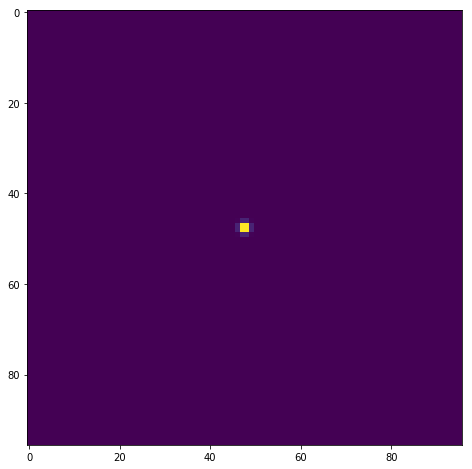

In [67]:
target_galsim = Image(list_preds[2])
psf_galsim = Image(list_psfs[2])
plt.imshow(list_psfs[0])

In [56]:
SNR_list_sim

[20]

In [54]:
dico=[]
for net_file in range(3):
    dico.append([])
    for SNR_sim in range(5):
        dico[net_file].append([])

In [40]:
list_psfs=fits2npy("/data/DeepDeconv/data/gauss_fwhm0p07/starfield_image-000-0.fits",0)

In [19]:
list_psfs=fits2npy("/data/DeepDeconv/data/gauss_fwhm0p07/starfield_image-000-0.fits",0)
ellip_measures=[]
n=len(net_file_list)
for net_file in range(n):
    print(net_file_list[net_file])
    ellip_measures.append([])
    for i in range(5):
        ellip_measures[net_file].append([])
        #Load input test for given SNR
        SNR_sim=SNR_list_sim[i]
        mosaic_name=testset_file.replace('.fits','-'+net_file_list[net_file].replace('.hdf5','_testSNR{0}.fits'.format(SNR_sim)))
        
        list_preds=fits2npy(write_path+'images/'+mosaic_name,0)
        for k in range(10000):
            #we create a galsim version of Y
            target_galsim = Image(list_preds[k])
            psf_galsim = Image(list_psfs[0])
            #we estimate the moments of Y
            temp=galsim.hsm.EstimateShear(target_galsim, psf_galsim,shear_est='KSB',strict=False)
            if temp.error_message != "":
                ellip_measures[net_file][i].append([-10,-10])
            else:
                ellip_measures[net_file][i].append([temp.corrected_g1,temp.corrected_g2])
        

ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.001_Gaussian_window.hdf5


In [18]:
ellip_measures

[[[[0.029064452275633812, -0.07006779313087463],
   [-0.13257727026939392, 0.01192637998610735],
   [-0.20144669711589813, -0.4552611708641052],
   [-0.03137825429439545, 0.1109333485364914],
   [0.0805811733007431, -0.07879016548395157],
   [0.14341336488723755, 0.36350202560424805],
   [-0.0066258893348276615, -0.05045245960354805],
   [-0.05788372457027435, 0.014058535918593407],
   [0.08342897146940231, 0.08712466806173325],
   [-0.07167366147041321, -0.19377562403678894],
   [-0.5704246759414673, -0.12844496965408325],
   [-0.10340282320976257, -0.12222732603549957],
   [-0.6788190603256226, -0.013932153582572937],
   [0.13405264914035797, -0.11377675086259842],
   [-0.3280792236328125, 0.1850917935371399],
   [-0.27368295192718506, 0.07090798765420914],
   [-0.11445031315088272, 0.5214780569076538],
   [0.07455983012914658, -0.13543018698692322],
   [0.043073903769254684, -0.4283005893230438],
   [0.023800663650035858, -0.06466526538133621],
   [-0.1386275440454483, 0.06012070551

In [20]:
list_psfs=fits2npy("/data/DeepDeconv/data/gauss_fwhm0p07/starfield_image-000-0.fits",0)
ellip_measures=[]
n=len(net_file_list)
for net_file in range(n):
    print(net_file_list[net_file])
    ellip_measures.append([])
    for i in range(5):
        ellip_measures[net_file].append([])
        for j in range(10):
            print('iteration',j)
            ellip_measures[net_file][i].append([])
            #Load input test for given SNR
            SNR_sim=SNR_list_sim[i]
            mosaic_name=testset_file.replace('.fits','-'+net_file_list[net_file].replace('.hdf5','_testSNR{0}_iteration{1}.fits'.format(SNR_sim,j)))
        
            list_preds=fits2npy(write_path+'images/'+mosaic_name,0)
            for k in range(10000):
                #we create a galsim version of Y
                target_galsim = Image(list_preds[k])
                psf_galsim = Image(list_psfs[0])
                #we estimate the moments of Y
                temp=galsim.hsm.EstimateShear(target_galsim, psf_galsim,shear_est='KSB',strict=False)
                if temp.error_message != "":
                    ellip_measures[net_file][i][j].append([-10,-10])
                else:
                    ellip_measures[net_file][i][j].append([temp.corrected_g1,temp.corrected_g2])
        
        
       
        


ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.001_Gaussian_window.hdf5
iteration 0


FileNotFoundError: [Errno 2] No such file or directory: '/data/DeepDeconv/benchmark/claire/images/image-shfl-00-multihdu_newtar-ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.001_Gaussian_window_testSNR20_iteration0.fits'

In [20]:
ellip_measures_target=[]
list_targets=fits2npy(testset_path+target_name_win,2)
psf_galsim = Image(list_psfs[0])
for j in range(10000):
    #we create a galsim version of Y
    target_galsim = Image(list_targets[j])
    #we estimate the moments of Y
    temp=galsim.hsm.EstimateShear(target_galsim, psf_galsim,shear_est='KSB',strict=False)
    if temp.error_message != "":
        ellip_measures_target.append([-10,-10])
    else:
        ellip_measures_target.append([temp.corrected_g1,temp.corrected_g2])
        
        
       
        


In [12]:
sum_e=[]
for i in range(10000): 
    sum_e.append(ellip_measures_target[i][0]+ellip_measures_target[i][1])

In [13]:
ellip_measures_target=np.array(ellip_measures_target)
#sum_e
l=np.where(ellip_measures_target>1)
#print(ellip_measures_target)
l[0].shape

(177,)

In [ ]:
from galsim.hsm import FindAdaptiveMom

def generate_elliptical_gaussian(e1, e2, sig, xc=128, yc=128, stamp_size=(256,256)):
    # compute centered grid
    ranges = np.array([np.arange(i) for i in stamp_size])
    x = np.outer(ranges[0] - xc, np.ones(stamp_size[1]))
    y = np.outer(np.ones(stamp_size[0]),ranges[1] - yc)
    # shift it to match centroid
    xx = (1-e1/2)*x - e2/2*y
    yy = (1+e1/2)*y - e2/2*x
    # compute elliptical gaussian
    return np.exp(-(xx ** 2 + yy ** 2) / (2 * sig ** 2))

size=list_targets[0].shape

In [21]:
for i in l[0]:
    Y_galsim=Image(list_targets[i])
    mom_Y = FindAdaptiveMom(Y_galsim, strict=False)
    e1_W,e2_W = -1.*mom_Y.observed_shape.e1, mom_Y.observed_shape.e2 #convention fix: e1 sign swap
    sig_W = mom_Y.moments_sigma
    xc_W,yc_W = mom_Y.moments_centroid.y-1, mom_Y.moments_centroid.x-1 # convention fix: swap x and y and origin at (0,0)
    #generate W
    W = generate_elliptical_gaussian(e1_W, e2_W, sig_W, xc_W, yc_W, stamp_size=size)
    plt.imshow(W)
    plt.figure()
    plt.show()
    plt.imshow(list_targets[72])
    plt.figure()
    plt.show()
    if i%10==0:
        input("PRESS ENTER")
        plt.close()

NameError: name 'l' is not defined

In [52]:
shape_data=galsim.hsm.EstimateShear(Y_galsim, psf_galsim,shear_est='KSB',strict=False)
print(shape_data.observed_shape,ellip_measures_target[72])

galsim.Shear(g1=0.03383835443110156,g2=0.003974782828522099) [-541.51159668   53.41368103]


In [20]:
ellip_measures_lowr_sparse=[]
n=len(sota_file_list)
for sota_file in range(n):
    print(sota_file_list[sota_file])
    ellip_measures_lowr_sparse.append([])    
    list_preds=fits2npy(sota_path+sota_file_list[sota_file],0)
    for j in range(10000):
        #we create a galsim version of Y
        target_galsim = Image(list_preds[j])
        psf_galsim = Image(list_psfs[0])
        #we estimate the moments of Y
        temp=galsim.hsm.EstimateShear(target_galsim, psf_galsim,shear_est='KSB',strict=False)
        if temp.error_message != "":
            ellip_measures_lowr_sparse[sota_file].append([-10,-10])
        else:
            ellip_measures_lowr_sparse[sota_file].append([temp.corrected_g1,temp.corrected_g2])

NameError: name 'sota_file_list' is not defined

In [28]:
np.array(ellip_measures).shape

(1, 1, 1, 0)

ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.001_Gaussian_window.hdf5


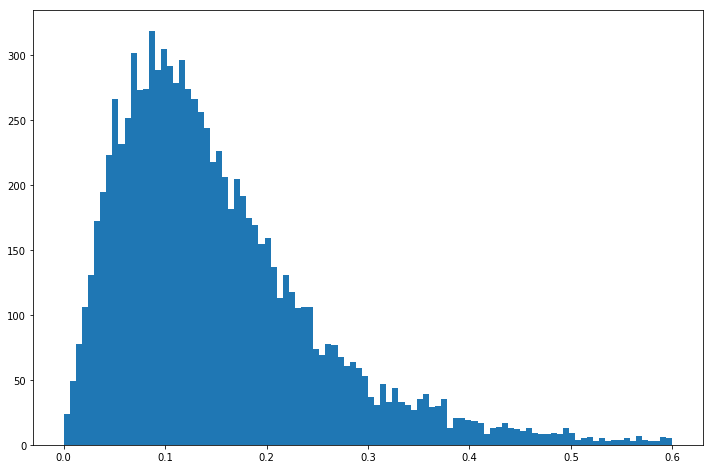

Total samples = 9625
SNR= 0 MEAN_ERR= 0.15996933692007187 MEDIAN_ERR= 0.1302606323131041
[0.1302606323131041]


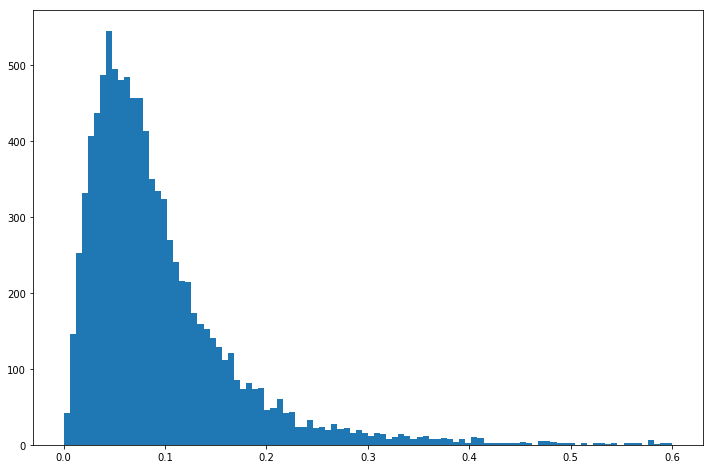

Total samples = 9594
SNR= 1 MEAN_ERR= 0.10116540160606945 MEDIAN_ERR= 0.07490375764388846
[0.1302606323131041, 0.07490375764388846]


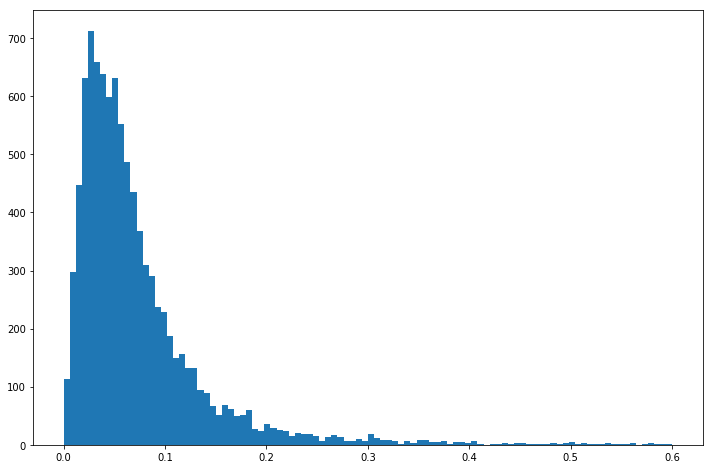

Total samples = 9579
SNR= 2 MEAN_ERR= 0.07928337760450757 MEDIAN_ERR= 0.05466143153860517
[0.1302606323131041, 0.07490375764388846, 0.05466143153860517]


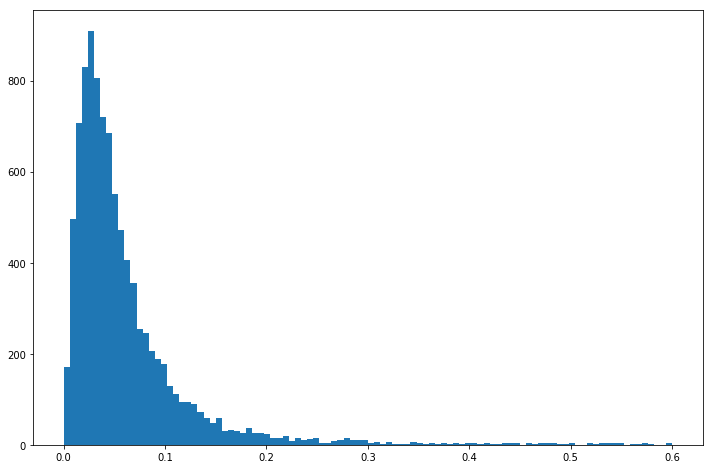

Total samples = 9555
SNR= 3 MEAN_ERR= 0.06693331806458032 MEDIAN_ERR= 0.0431116942582623
[0.1302606323131041, 0.07490375764388846, 0.05466143153860517, 0.0431116942582623]


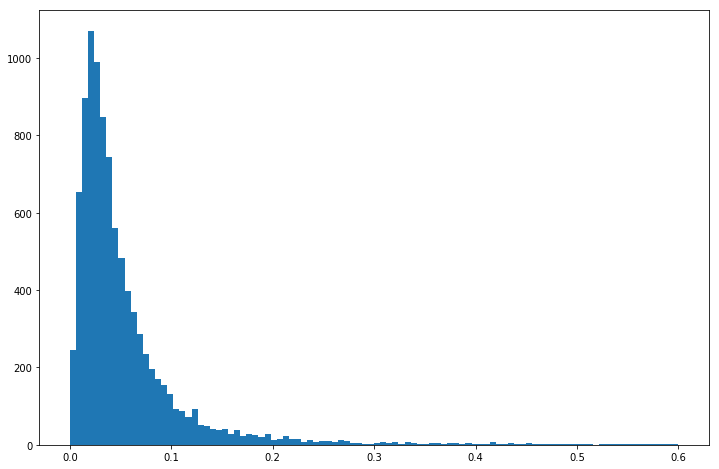

Total samples = 9539
SNR= 4 MEAN_ERR= 0.06115540733439302 MEDIAN_ERR= 0.03645861375928372
[0.1302606323131041, 0.07490375764388846, 0.05466143153860517, 0.0431116942582623, 0.03645861375928372]


In [21]:
plot_hist=True
n=len(net_file_list)
bl=[]
for net_file in range(n):
    l=[]
    print(net_file_list[net_file])
    for SNR_sim in range(5):
        ellipX = np.array(ellip_measures_target)
        ellipY = np.array(ellip_measures[net_file][SNR_sim])
        err = []
        for i in range(len(ellipY)):
            if (np.abs(ellipX[i]) > 1).any() or (np.abs(ellipY[i]) > 1).any():
                continue
            err.append(np.linalg.norm(ellipX[i]-ellipY[i]))
        if plot_hist:
            plt.figure()
            plt.hist(err, 100, range=(0,0.6))
            plt.show()
            print('Total samples = %d' %len(err))
        l.append(np.median(err))
        print("SNR=",SNR_sim,"MEAN_ERR=",np.mean(err),"MEDIAN_ERR=",np.median(err))
        print(l)
    bl.append(l)

In [ ]:
print(bl)
bl[:,1]

In [ ]:
SNR=[20,40,60,80,100]
bl=np.array(bl)
mean=[]
std=[]
for i in range(5):
    mean.append(np.mean(bl[:,i]))
    std.append(np.std(bl[:,i]))
plt.errorbar(SNR,mean,std,ecolor="red")

std
    

ShapeNet2D_claire_sc4_layer4x5x6x7_relu_growthRate12_with_shape_gamma0.1_shearlet.hdf5


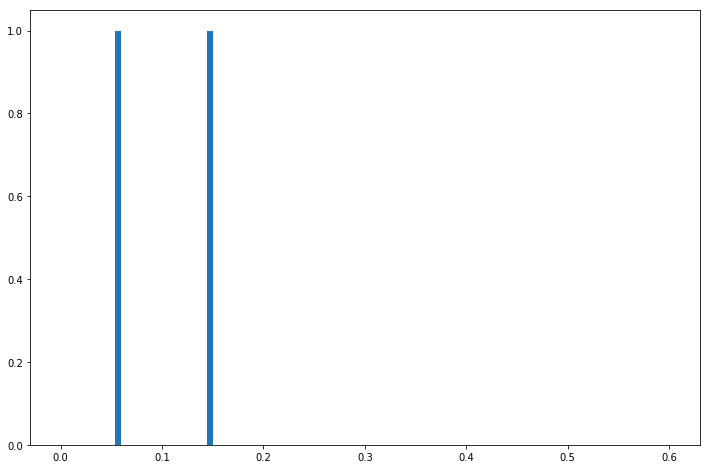

Total samples = 2
Iteration 0 SNR= 0 MEAN_ERR= 0.10106263857284258 MEDIAN_ERR= 0.10106263857284258
[0.10106263857284258]


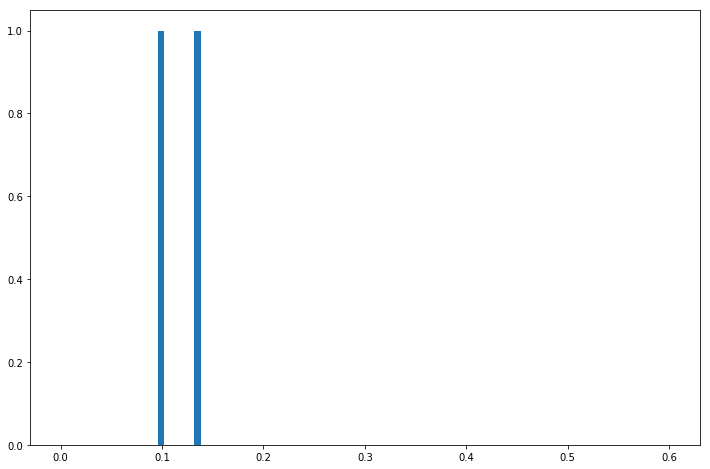

Total samples = 2
Iteration 1 SNR= 0 MEAN_ERR= 0.11729435119386444 MEDIAN_ERR= 0.11729435119386444
[0.10106263857284258, 0.11729435119386444]


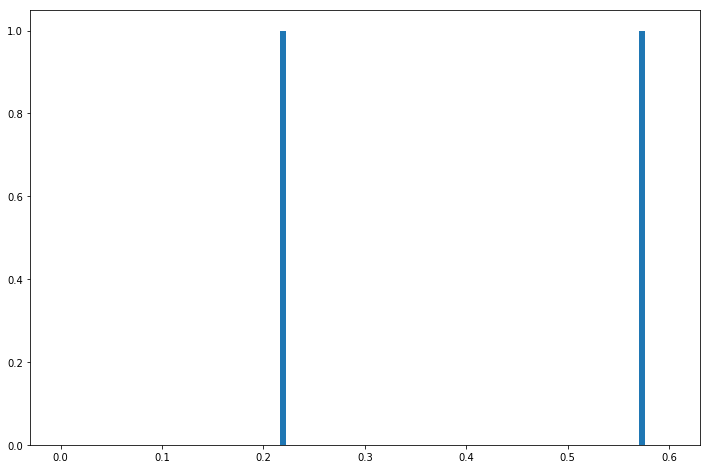

Total samples = 2
Iteration 2 SNR= 0 MEAN_ERR= 0.3980242945448038 MEDIAN_ERR= 0.3980242945448038
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038]


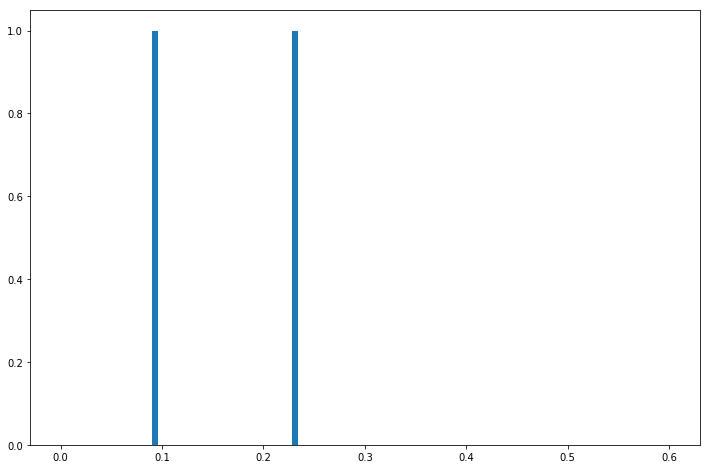

Total samples = 2
Iteration 3 SNR= 0 MEAN_ERR= 0.16124785129296867 MEDIAN_ERR= 0.16124785129296867
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867]


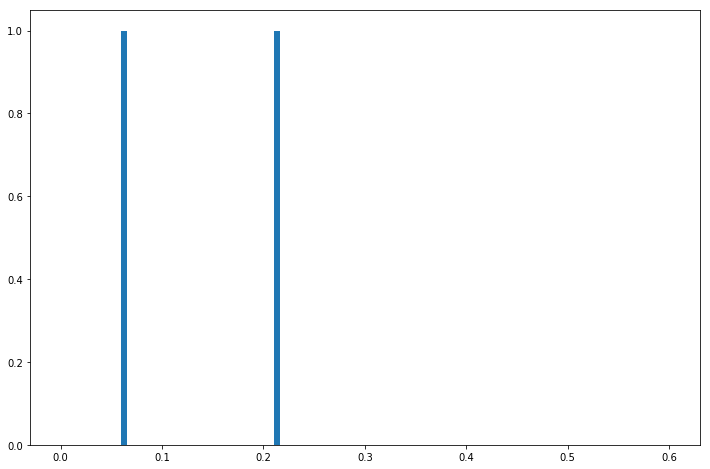

Total samples = 2
Iteration 4 SNR= 0 MEAN_ERR= 0.13682524357315362 MEDIAN_ERR= 0.13682524357315362
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362]


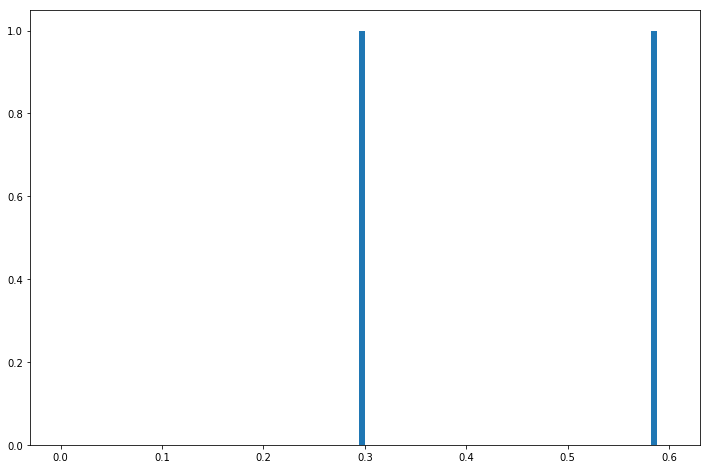

Total samples = 2
Iteration 5 SNR= 0 MEAN_ERR= 0.44071808964659265 MEDIAN_ERR= 0.44071808964659265
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265]


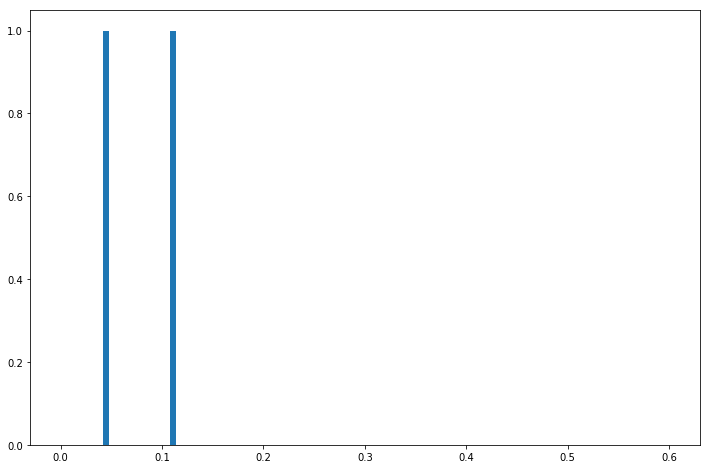

Total samples = 2
Iteration 6 SNR= 0 MEAN_ERR= 0.0780796123975655 MEDIAN_ERR= 0.0780796123975655
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655]


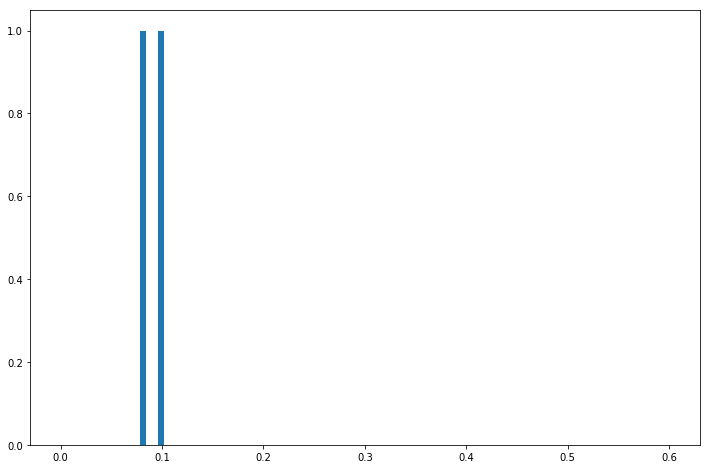

Total samples = 2
Iteration 7 SNR= 0 MEAN_ERR= 0.09236092519637118 MEDIAN_ERR= 0.09236092519637118
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118]


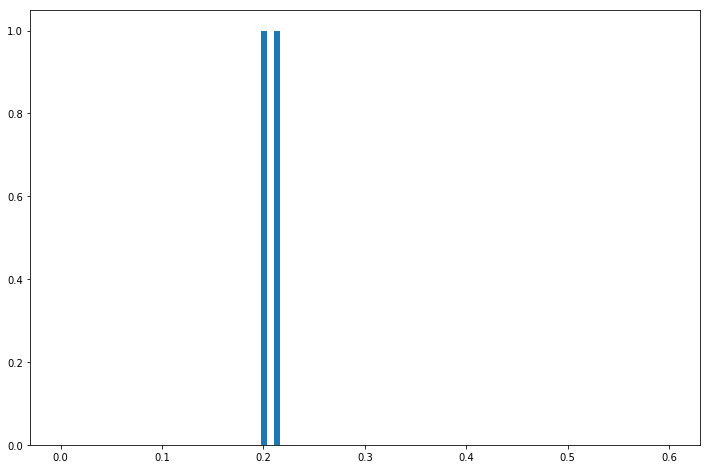

Total samples = 2
Iteration 8 SNR= 0 MEAN_ERR= 0.20711364494306927 MEDIAN_ERR= 0.20711364494306927
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927]


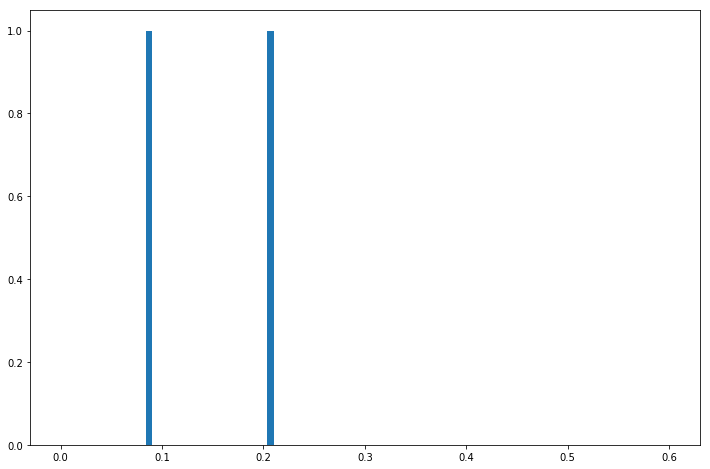

Total samples = 2
Iteration 9 SNR= 0 MEAN_ERR= 0.14726491818779022 MEDIAN_ERR= 0.14726491818779022
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022]


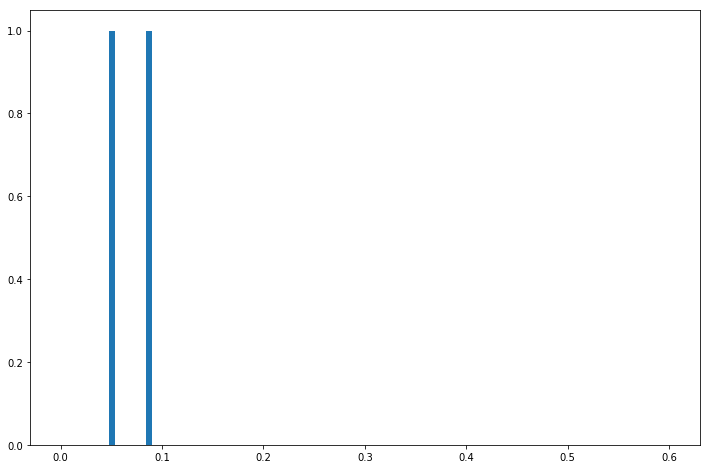

Total samples = 2
Iteration 0 SNR= 1 MEAN_ERR= 0.06844930013322181 MEDIAN_ERR= 0.06844930013322181
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181]


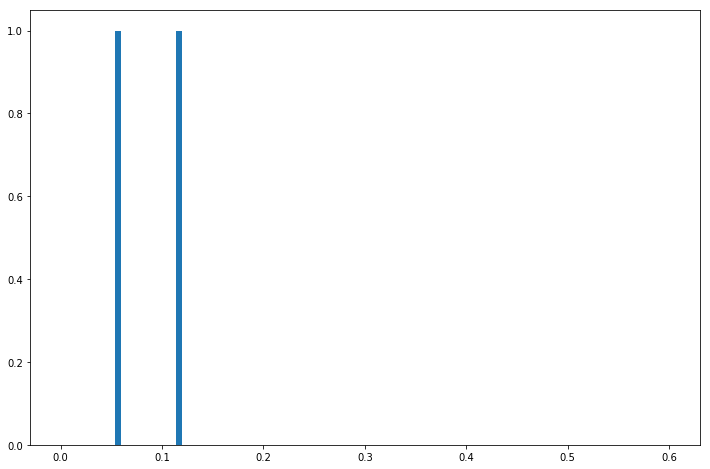

Total samples = 2
Iteration 1 SNR= 1 MEAN_ERR= 0.08832485983101171 MEDIAN_ERR= 0.08832485983101171
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171]


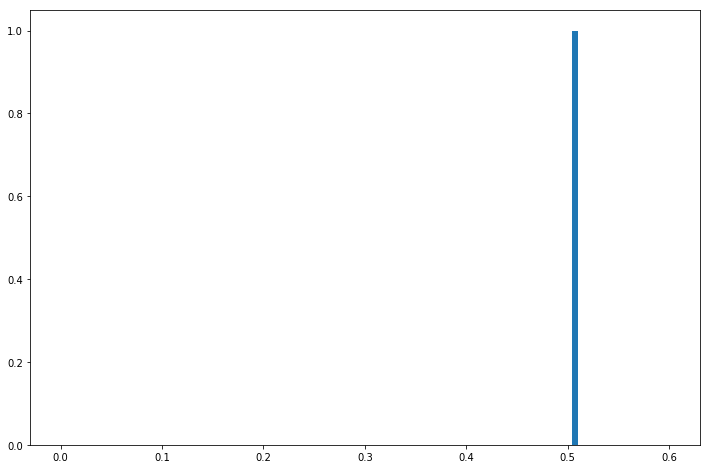

Total samples = 2
Iteration 2 SNR= 1 MEAN_ERR= 0.733366620299108 MEDIAN_ERR= 0.733366620299108
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108]


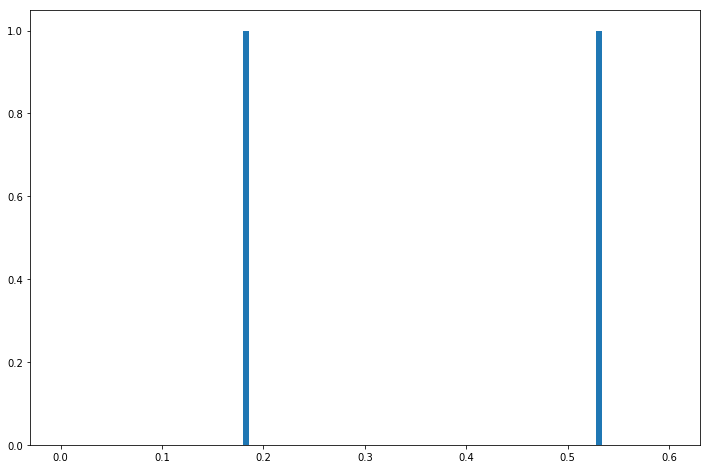

Total samples = 2
Iteration 3 SNR= 1 MEAN_ERR= 0.3578281738505456 MEDIAN_ERR= 0.3578281738505456
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456]


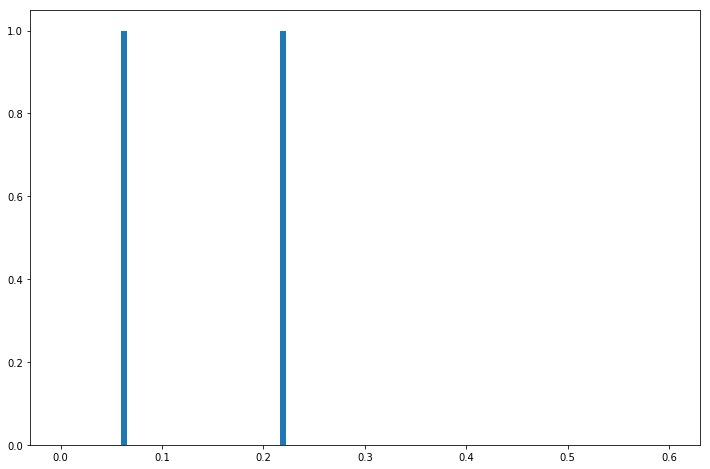

Total samples = 2
Iteration 4 SNR= 1 MEAN_ERR= 0.14328990014011167 MEDIAN_ERR= 0.14328990014011167
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167]


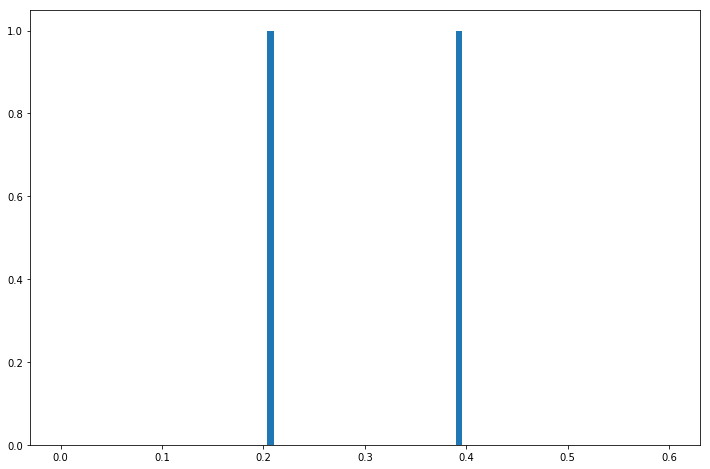

Total samples = 2
Iteration 5 SNR= 1 MEAN_ERR= 0.2996861234810617 MEDIAN_ERR= 0.2996861234810617
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617]


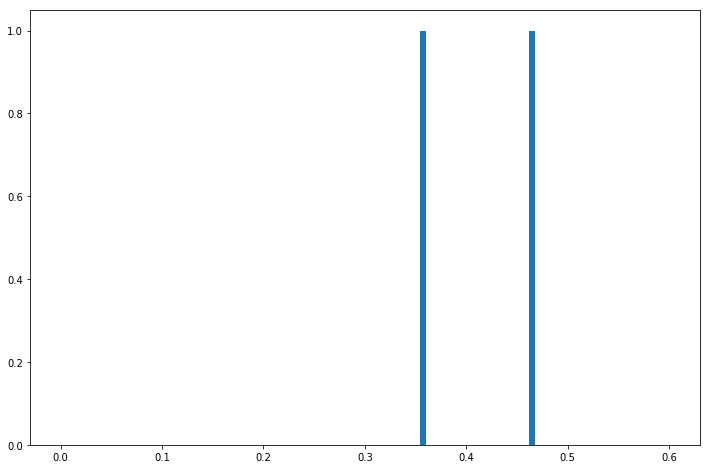

Total samples = 2
Iteration 6 SNR= 1 MEAN_ERR= 0.41072922411034174 MEDIAN_ERR= 0.41072922411034174
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174]


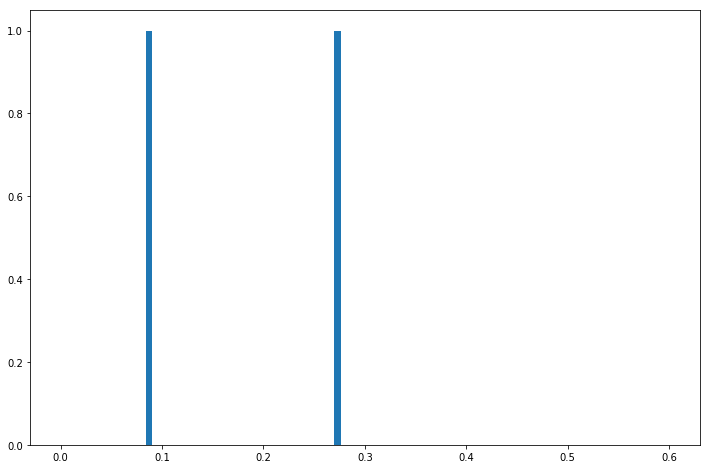

Total samples = 2
Iteration 7 SNR= 1 MEAN_ERR= 0.17853147634330668 MEDIAN_ERR= 0.17853147634330668
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668]


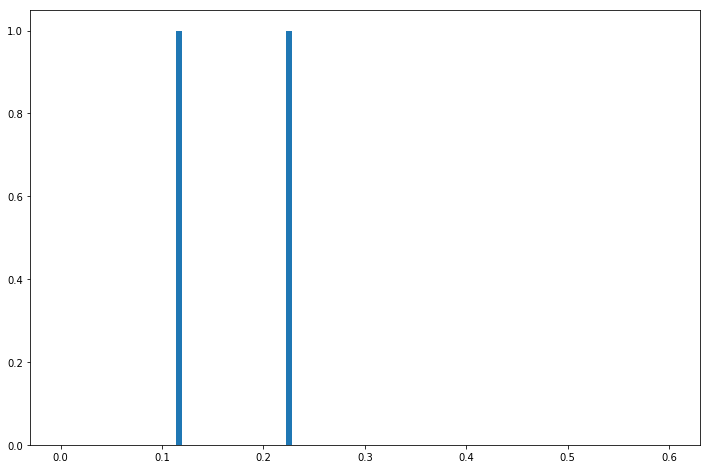

Total samples = 2
Iteration 8 SNR= 1 MEAN_ERR= 0.1714512935761042 MEDIAN_ERR= 0.1714512935761042
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042]


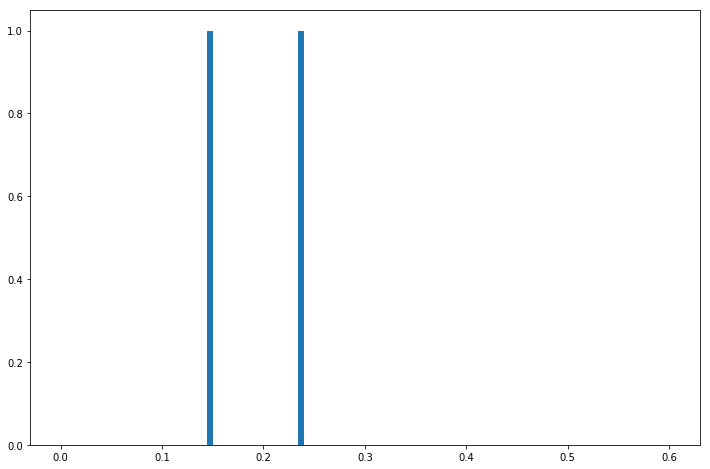

Total samples = 2
Iteration 9 SNR= 1 MEAN_ERR= 0.18995946354295323 MEDIAN_ERR= 0.18995946354295323
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323]


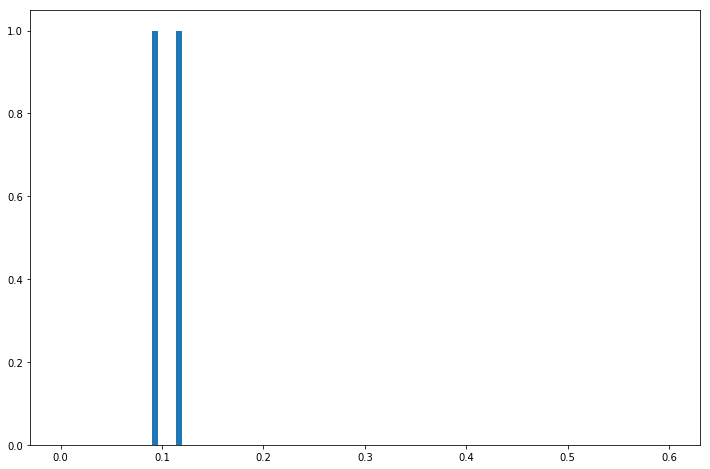

Total samples = 2
Iteration 0 SNR= 2 MEAN_ERR= 0.10456895021348107 MEDIAN_ERR= 0.10456895021348107
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107]


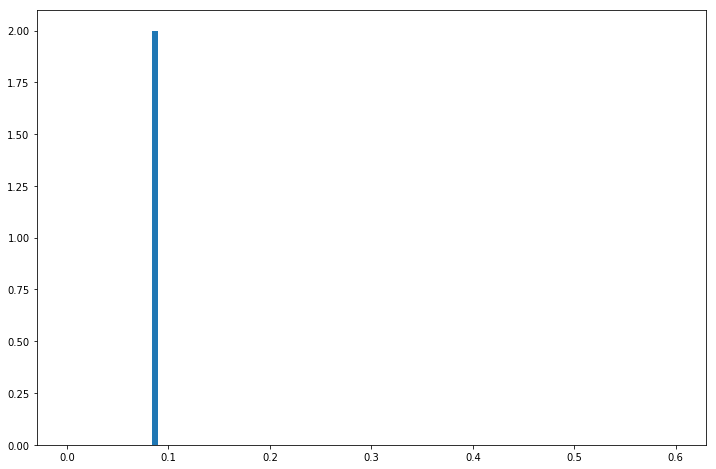

Total samples = 2
Iteration 1 SNR= 2 MEAN_ERR= 0.0862591984753549 MEDIAN_ERR= 0.0862591984753549
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549]


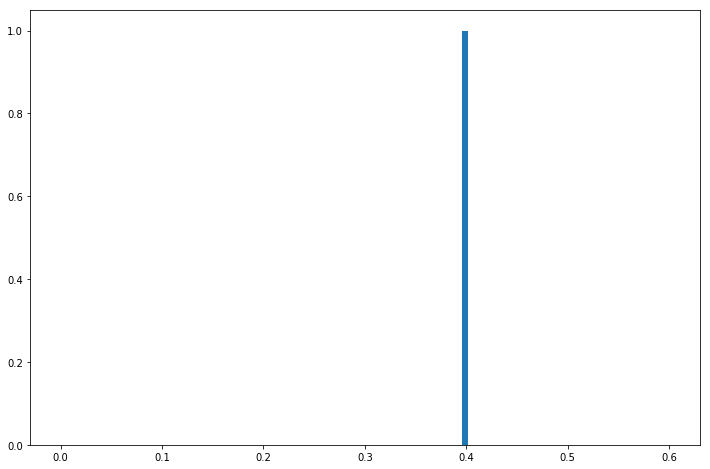

Total samples = 2
Iteration 2 SNR= 2 MEAN_ERR= 0.6286184364696512 MEDIAN_ERR= 0.6286184364696512
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512]


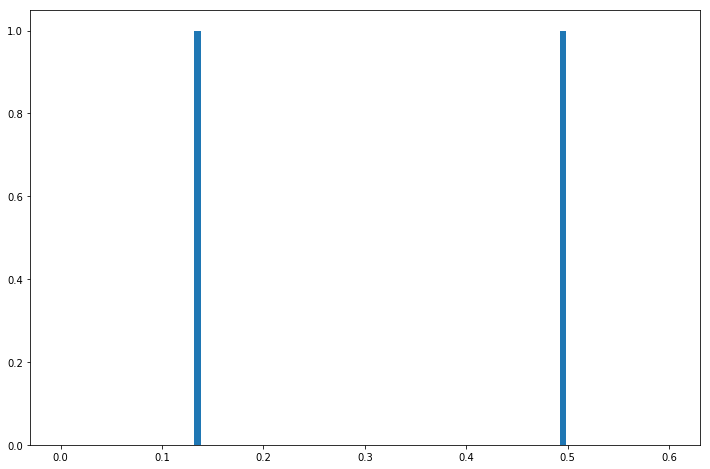

Total samples = 2
Iteration 3 SNR= 2 MEAN_ERR= 0.3150419217152967 MEDIAN_ERR= 0.3150419217152967
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967]


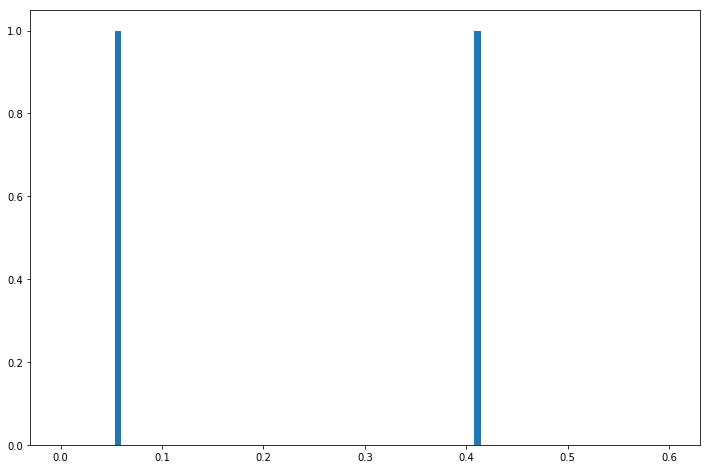

Total samples = 2
Iteration 4 SNR= 2 MEAN_ERR= 0.23468871082824835 MEDIAN_ERR= 0.23468871082824835
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835]


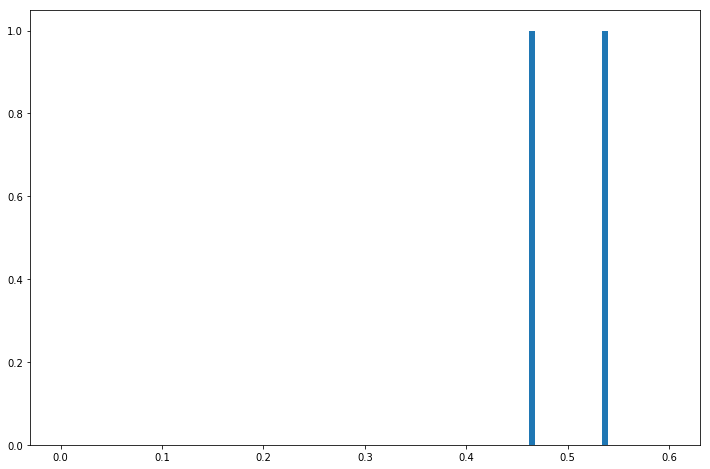

Total samples = 2
Iteration 5 SNR= 2 MEAN_ERR= 0.5000534980349756 MEDIAN_ERR= 0.5000534980349756
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756]


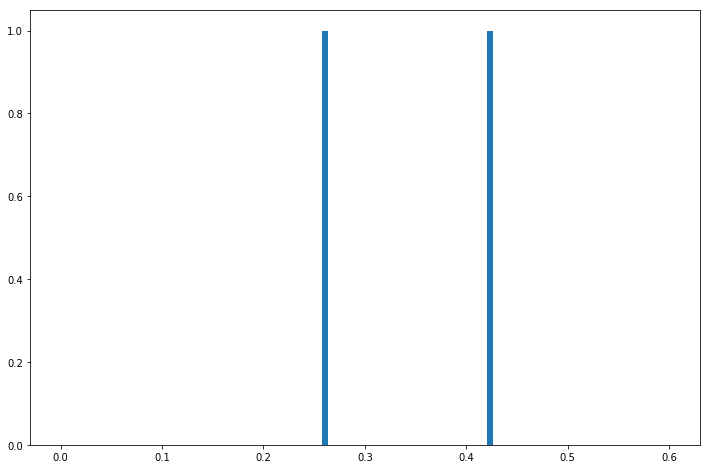

Total samples = 2
Iteration 6 SNR= 2 MEAN_ERR= 0.3418074080836877 MEDIAN_ERR= 0.3418074080836877
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877]


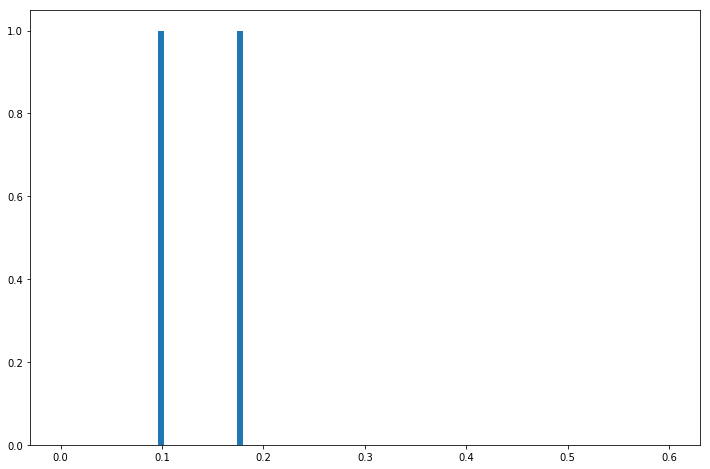

Total samples = 2
Iteration 7 SNR= 2 MEAN_ERR= 0.13925952077986636 MEDIAN_ERR= 0.13925952077986636
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636]


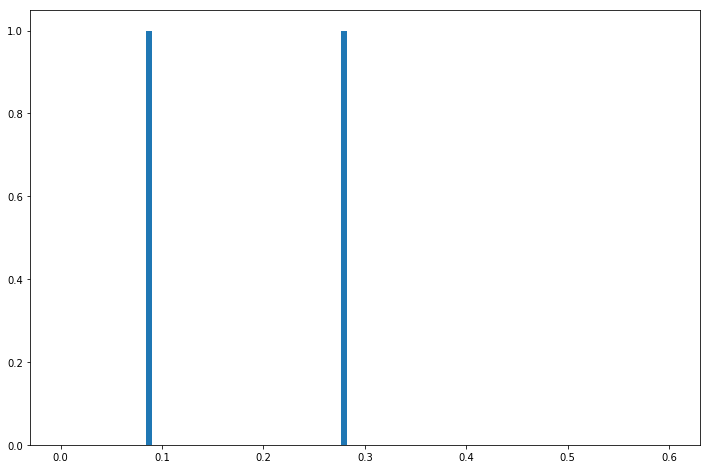

Total samples = 2
Iteration 8 SNR= 2 MEAN_ERR= 0.18268270478464319 MEDIAN_ERR= 0.18268270478464319
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319]


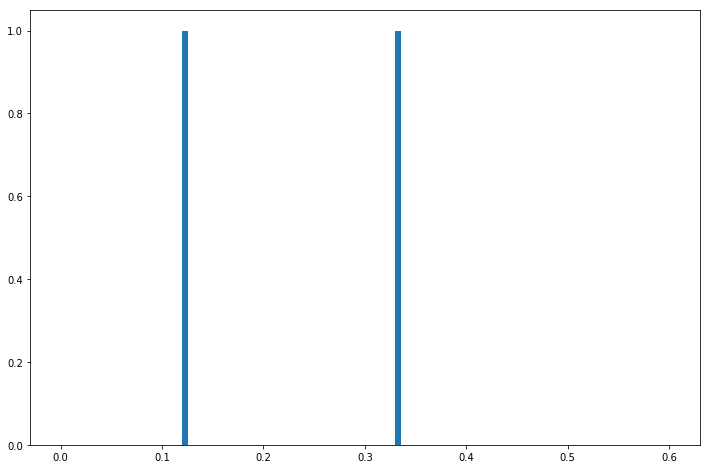

Total samples = 2
Iteration 9 SNR= 2 MEAN_ERR= 0.2277137020332186 MEDIAN_ERR= 0.2277137020332186
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186]


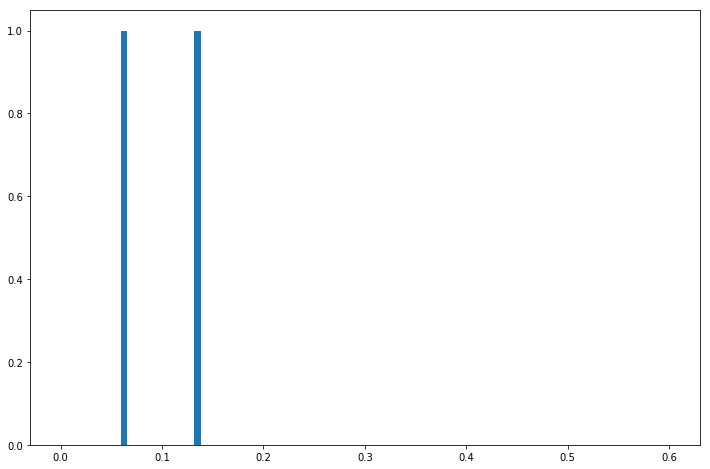

Total samples = 2
Iteration 0 SNR= 3 MEAN_ERR= 0.09982195460650325 MEDIAN_ERR= 0.09982195460650325
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325]


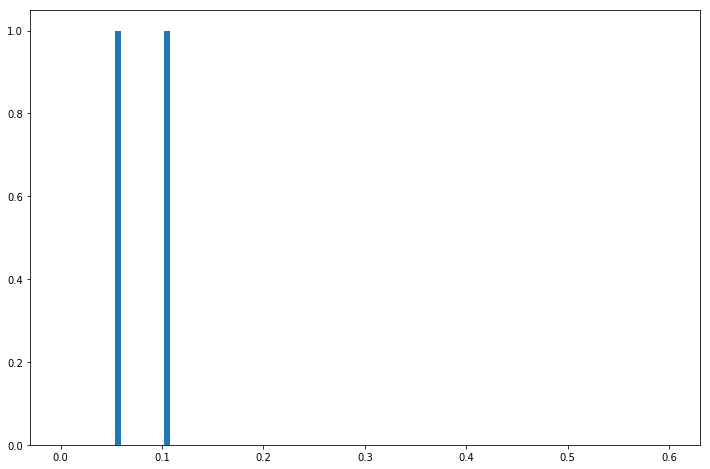

Total samples = 2
Iteration 1 SNR= 3 MEAN_ERR= 0.07887321202931827 MEDIAN_ERR= 0.07887321202931827
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827]


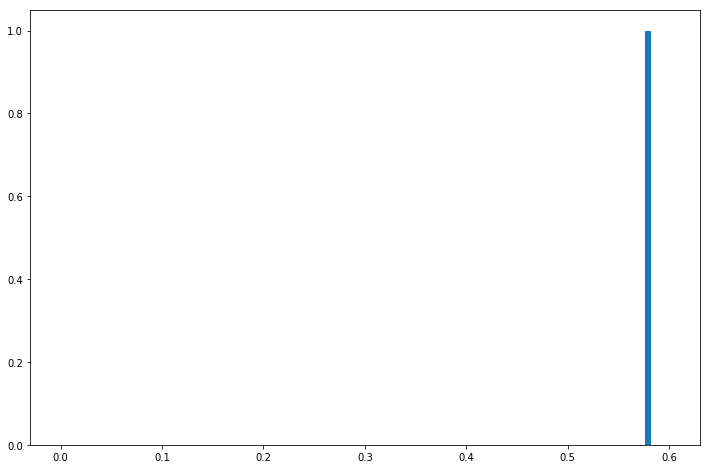

Total samples = 2
Iteration 2 SNR= 3 MEAN_ERR= 0.7898498541422374 MEDIAN_ERR= 0.7898498541422374
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374]


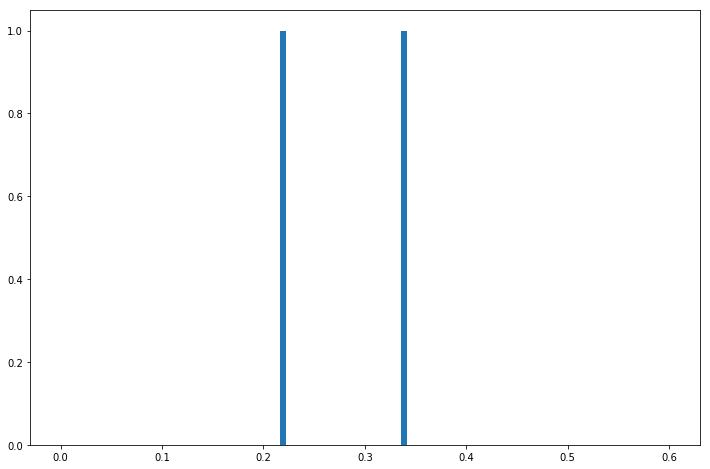

Total samples = 2
Iteration 3 SNR= 3 MEAN_ERR= 0.276819226599406 MEDIAN_ERR= 0.276819226599406
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406]


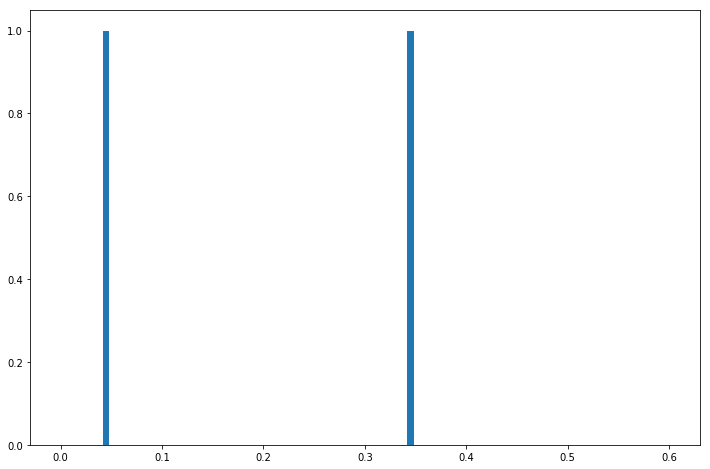

Total samples = 2
Iteration 4 SNR= 3 MEAN_ERR= 0.19484338741507085 MEDIAN_ERR= 0.19484338741507085
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085]


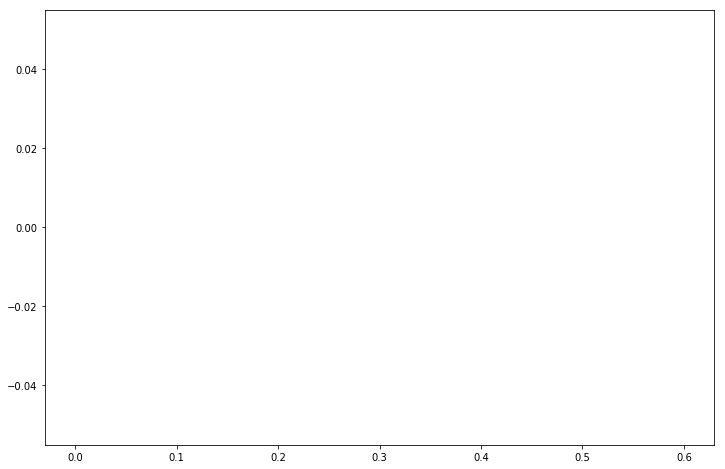

Total samples = 2
Iteration 5 SNR= 3 MEAN_ERR= 1.0100965022983899 MEDIAN_ERR= 1.0100965022983899
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899]


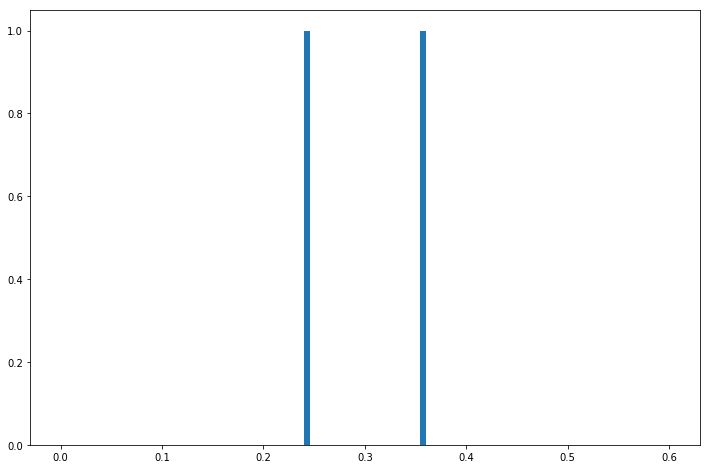

Total samples = 2
Iteration 6 SNR= 3 MEAN_ERR= 0.3003479011392206 MEDIAN_ERR= 0.3003479011392206
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206]


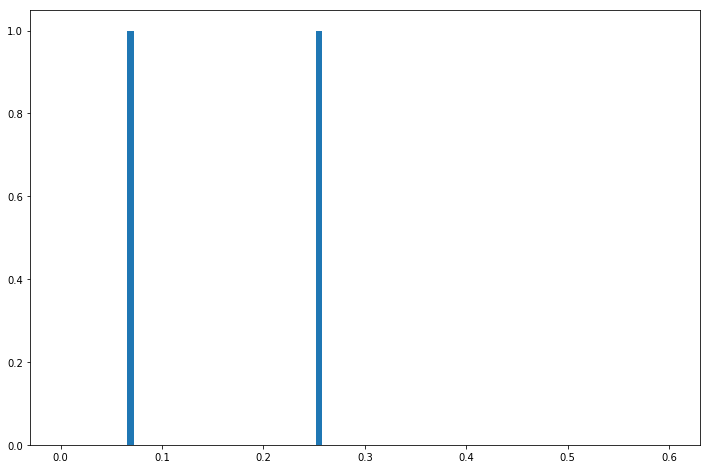

Total samples = 2
Iteration 7 SNR= 3 MEAN_ERR= 0.16003242522313776 MEDIAN_ERR= 0.16003242522313776
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776]


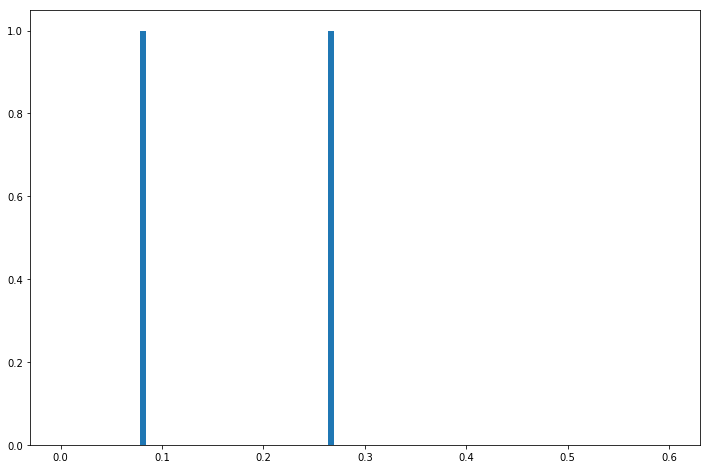

Total samples = 2
Iteration 8 SNR= 3 MEAN_ERR= 0.17409888362616727 MEDIAN_ERR= 0.17409888362616727
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727]


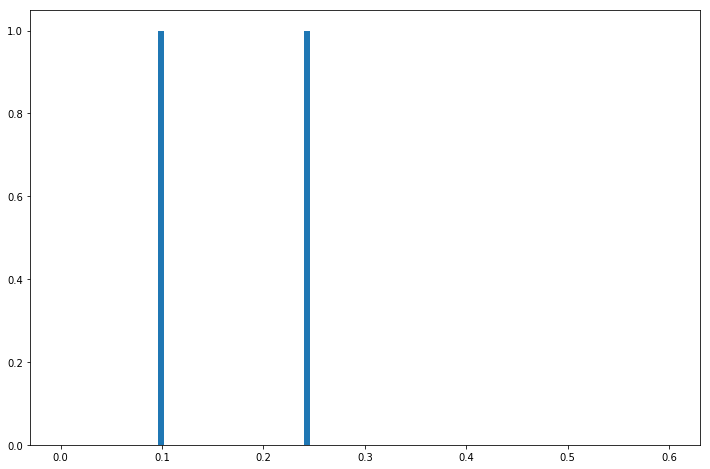

Total samples = 2
Iteration 9 SNR= 3 MEAN_ERR= 0.1709127895516728 MEDIAN_ERR= 0.1709127895516728
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728]


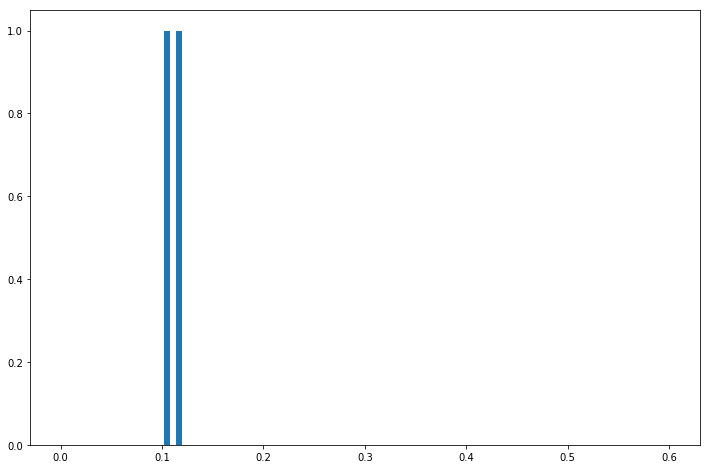

Total samples = 2
Iteration 0 SNR= 4 MEAN_ERR= 0.11141756883496384 MEDIAN_ERR= 0.11141756883496384
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384]


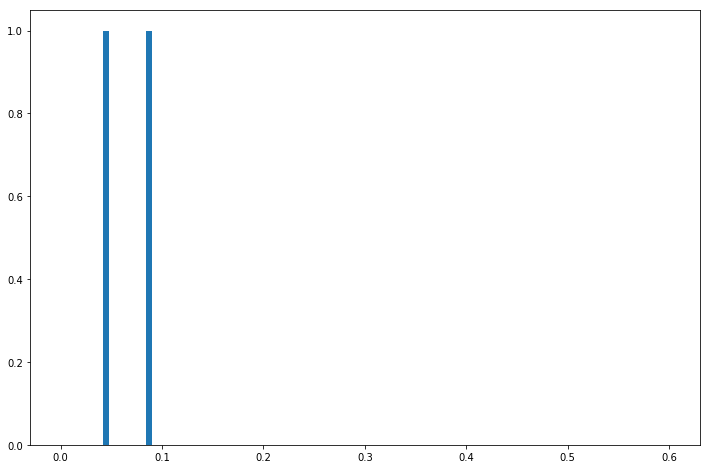

Total samples = 2
Iteration 1 SNR= 4 MEAN_ERR= 0.06853325110042838 MEDIAN_ERR= 0.06853325110042838
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384, 0.06853325110042838]


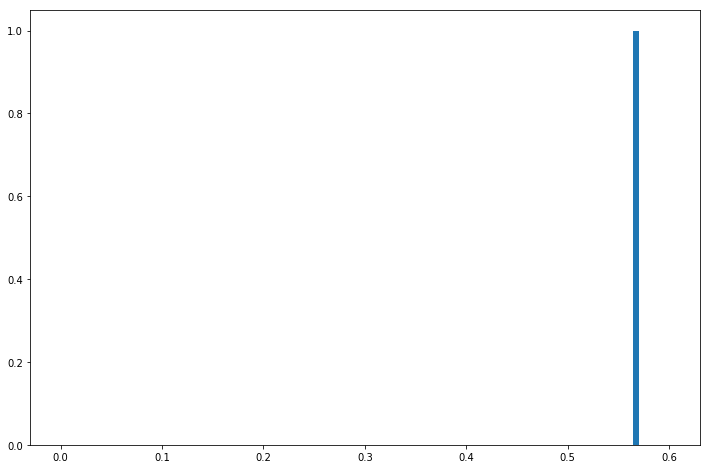

Total samples = 2
Iteration 2 SNR= 4 MEAN_ERR= 0.7716969921913064 MEDIAN_ERR= 0.7716969921913064
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384, 0.06853325110042838, 0.7716969921913064]


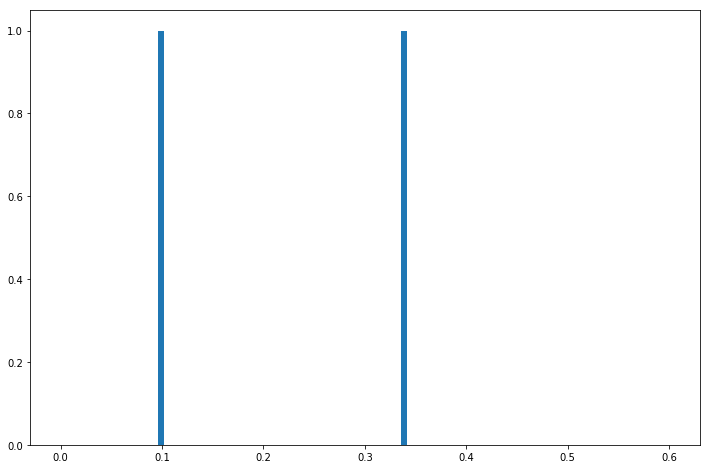

Total samples = 2
Iteration 3 SNR= 4 MEAN_ERR= 0.21952513961243172 MEDIAN_ERR= 0.21952513961243172
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384, 0.06853325110042838, 0.7716969921913064, 0.219525139612431

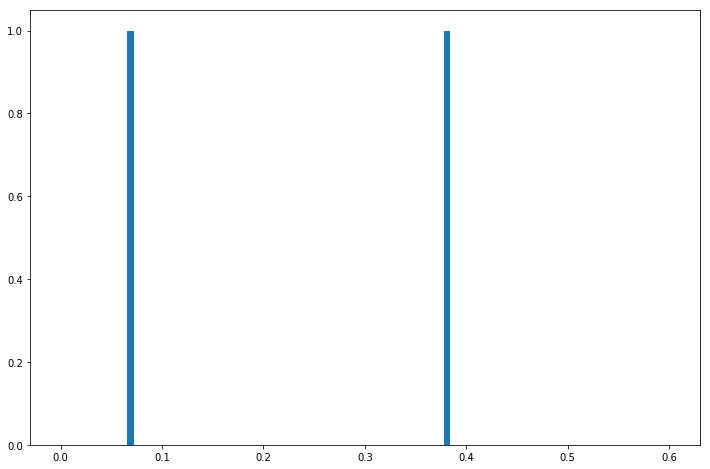

Total samples = 2
Iteration 4 SNR= 4 MEAN_ERR= 0.22604815986362214 MEDIAN_ERR= 0.22604815986362214
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384, 0.06853325110042838, 0.7716969921913064, 0.219525139612431

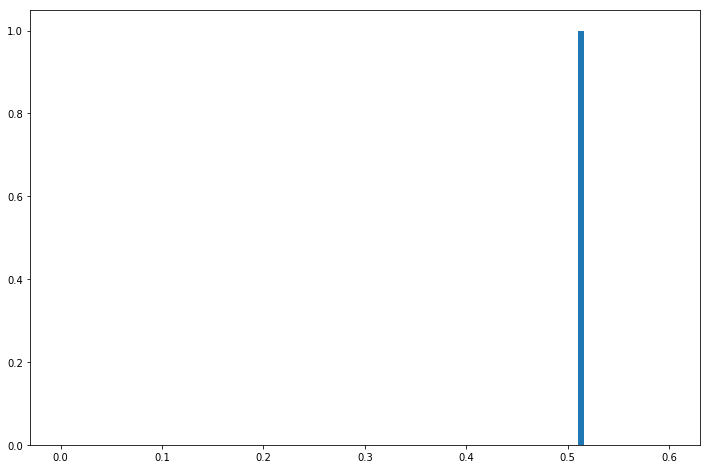

Total samples = 2
Iteration 5 SNR= 4 MEAN_ERR= 0.6512881859288229 MEDIAN_ERR= 0.6512881859288229
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384, 0.06853325110042838, 0.7716969921913064, 0.21952513961243172

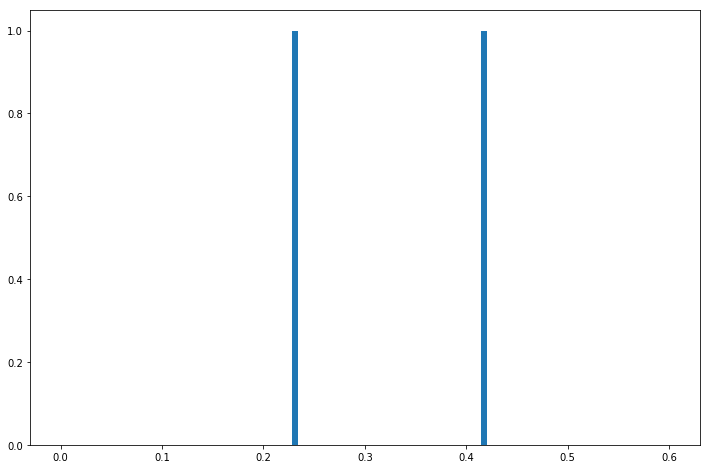

Total samples = 2
Iteration 6 SNR= 4 MEAN_ERR= 0.3240411900848883 MEDIAN_ERR= 0.3240411900848883
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384, 0.06853325110042838, 0.7716969921913064, 0.21952513961243172

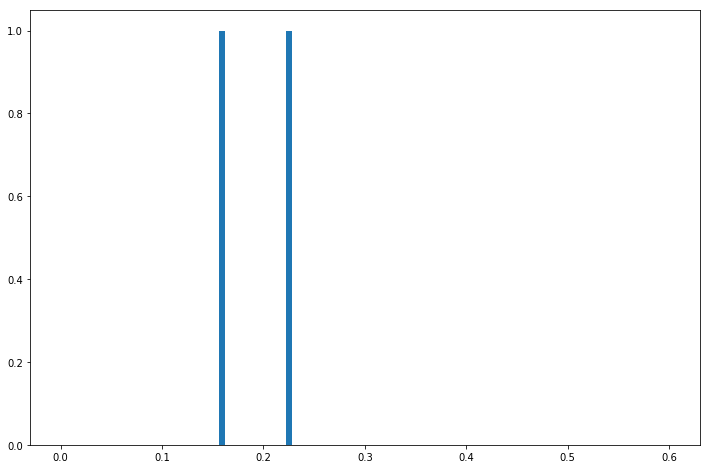

Total samples = 2
Iteration 7 SNR= 4 MEAN_ERR= 0.192830704991925 MEDIAN_ERR= 0.192830704991925
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384, 0.06853325110042838, 0.7716969921913064, 0.21952513961243172, 

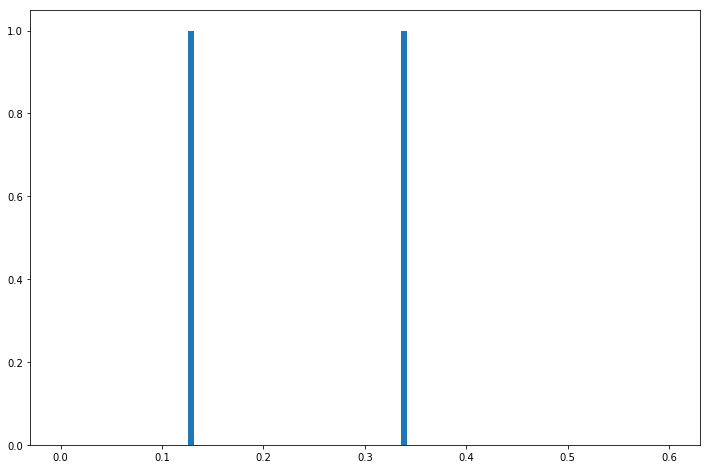

Total samples = 2
Iteration 8 SNR= 4 MEAN_ERR= 0.23589054853214858 MEDIAN_ERR= 0.23589054853214858
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384, 0.06853325110042838, 0.7716969921913064, 0.219525139612431

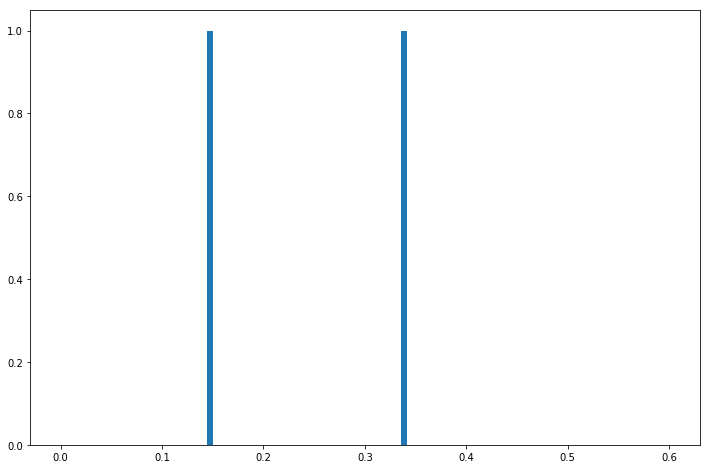

Total samples = 2
Iteration 9 SNR= 4 MEAN_ERR= 0.2429932407335702 MEDIAN_ERR= 0.2429932407335702
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384, 0.06853325110042838, 0.7716969921913064, 0.21952513961243172

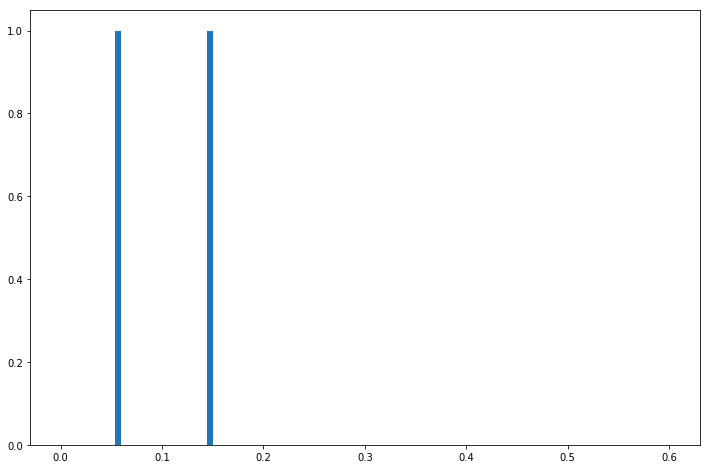

Total samples = 2
Iteration 0 SNR= 0 MEAN_ERR= 0.10106263857284258 MEDIAN_ERR= 0.10106263857284258
[0.10106263857284258]


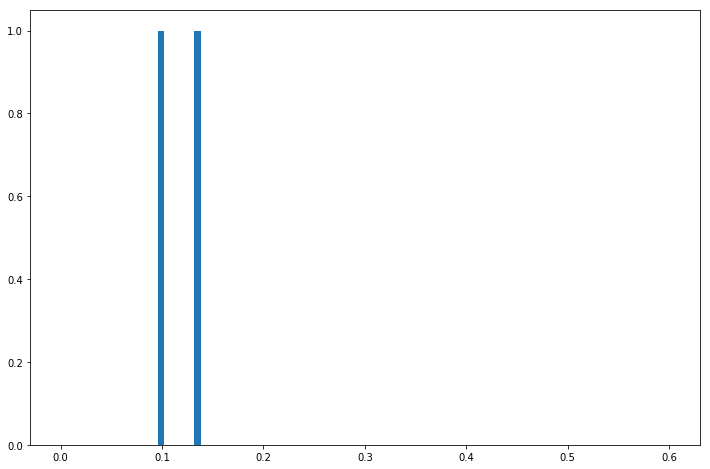

Total samples = 2
Iteration 1 SNR= 0 MEAN_ERR= 0.11729435119386444 MEDIAN_ERR= 0.11729435119386444
[0.10106263857284258, 0.11729435119386444]


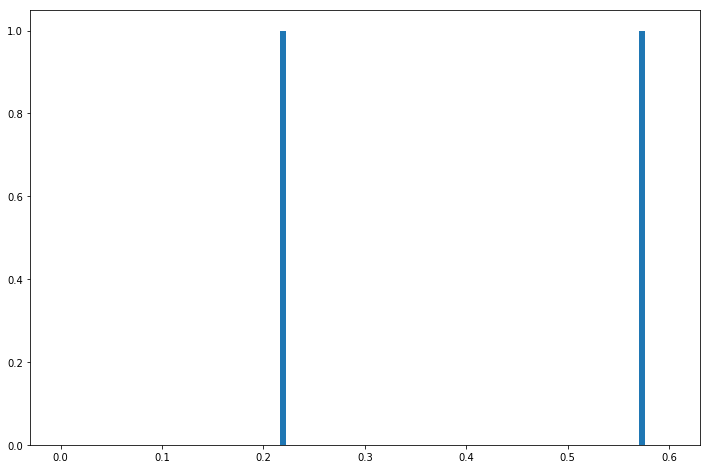

Total samples = 2
Iteration 2 SNR= 0 MEAN_ERR= 0.3980242945448038 MEDIAN_ERR= 0.3980242945448038
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038]


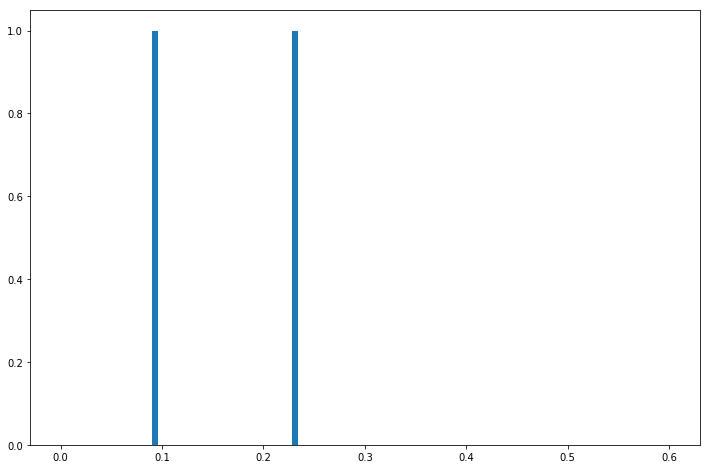

Total samples = 2
Iteration 3 SNR= 0 MEAN_ERR= 0.16124785129296867 MEDIAN_ERR= 0.16124785129296867
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867]


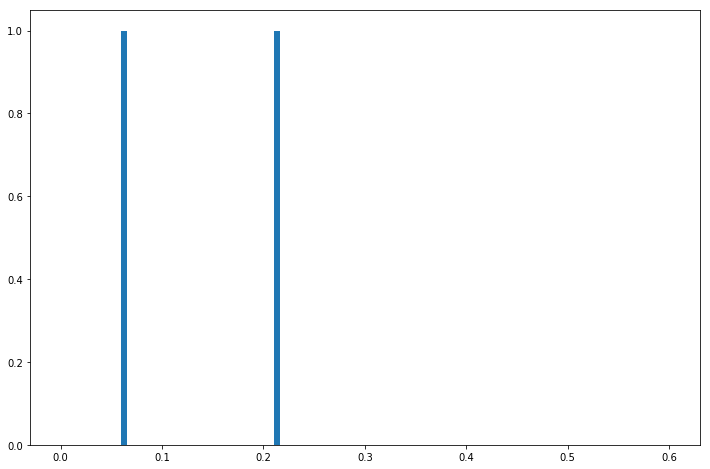

Total samples = 2
Iteration 4 SNR= 0 MEAN_ERR= 0.13682524357315362 MEDIAN_ERR= 0.13682524357315362
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362]


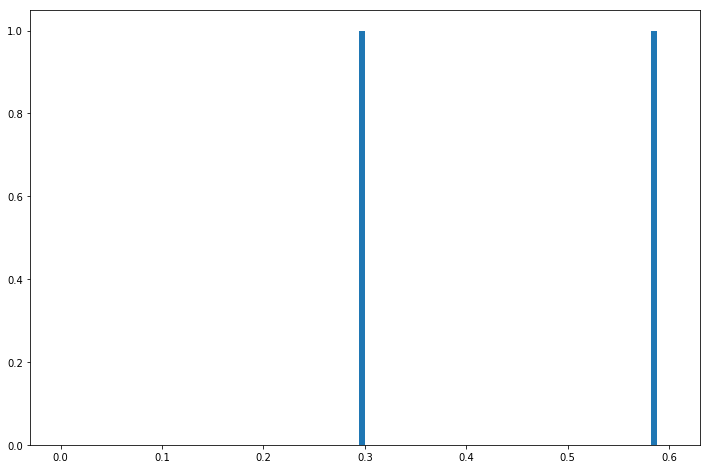

Total samples = 2
Iteration 5 SNR= 0 MEAN_ERR= 0.44071808964659265 MEDIAN_ERR= 0.44071808964659265
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265]


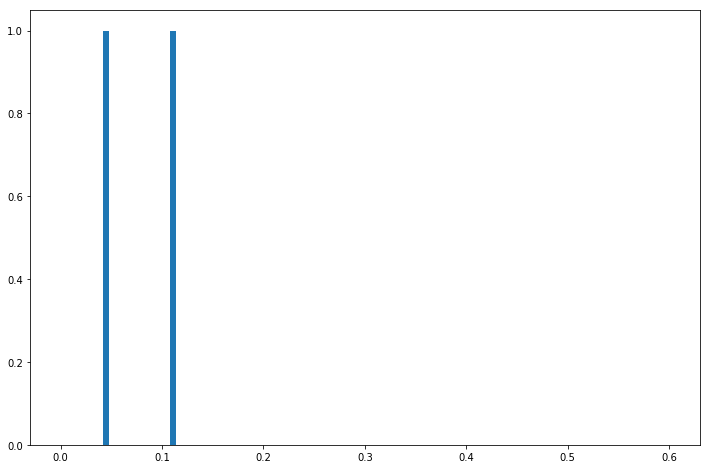

Total samples = 2
Iteration 6 SNR= 0 MEAN_ERR= 0.0780796123975655 MEDIAN_ERR= 0.0780796123975655
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655]


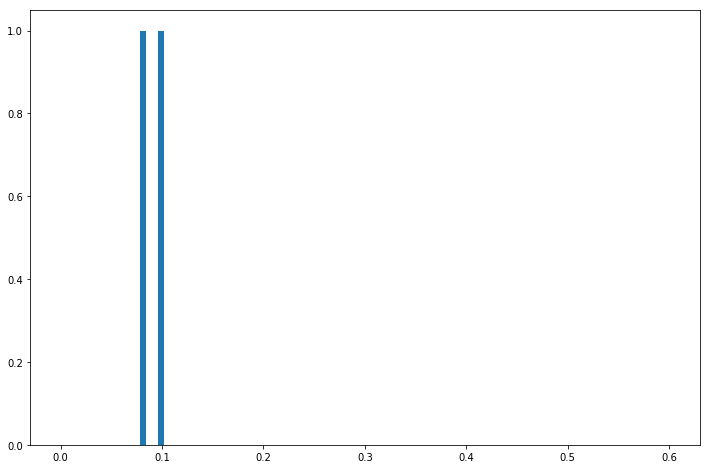

Total samples = 2
Iteration 7 SNR= 0 MEAN_ERR= 0.09236092519637118 MEDIAN_ERR= 0.09236092519637118
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118]


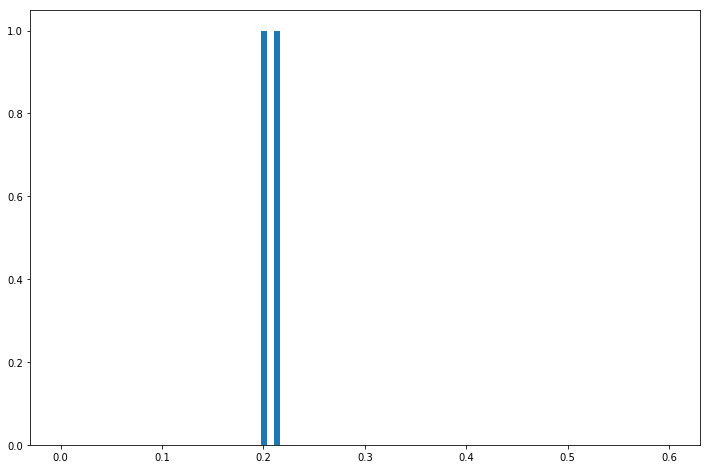

Total samples = 2
Iteration 8 SNR= 0 MEAN_ERR= 0.20711364494306927 MEDIAN_ERR= 0.20711364494306927
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927]


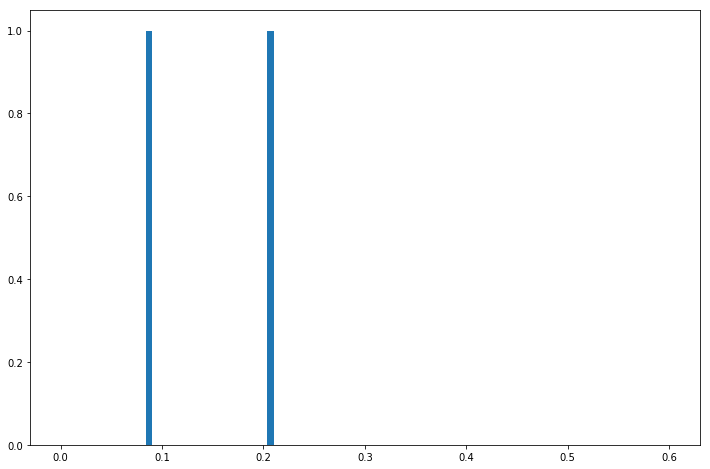

Total samples = 2
Iteration 9 SNR= 0 MEAN_ERR= 0.14726491818779022 MEDIAN_ERR= 0.14726491818779022
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022]


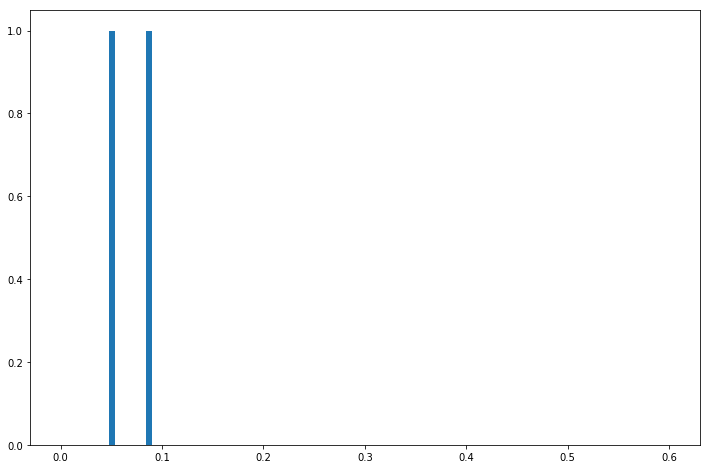

Total samples = 2
Iteration 0 SNR= 1 MEAN_ERR= 0.06844930013322181 MEDIAN_ERR= 0.06844930013322181
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181]


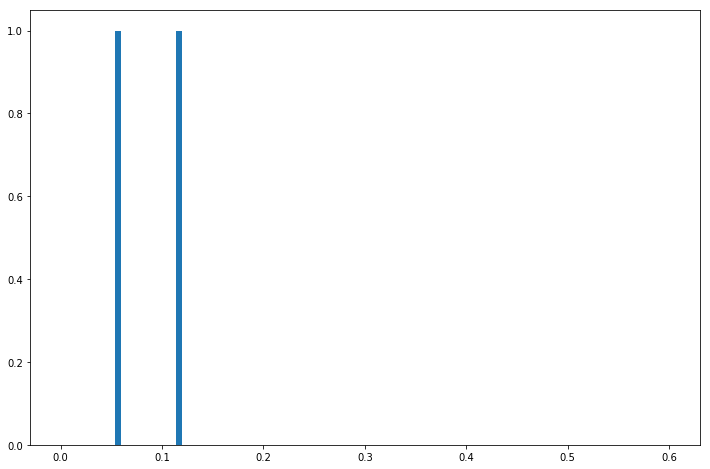

Total samples = 2
Iteration 1 SNR= 1 MEAN_ERR= 0.08832485983101171 MEDIAN_ERR= 0.08832485983101171
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171]


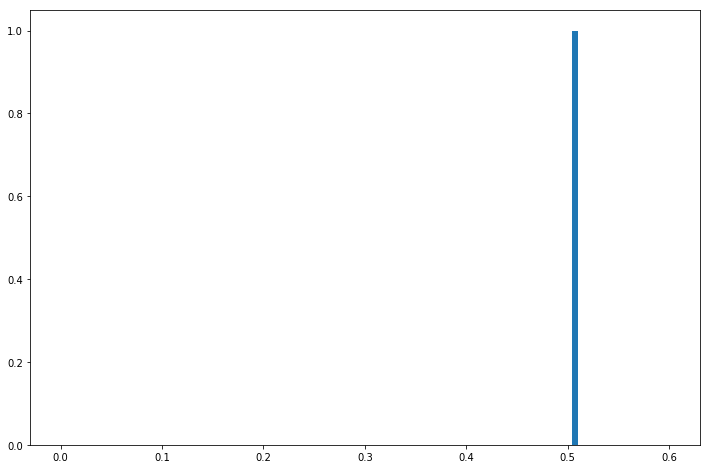

Total samples = 2
Iteration 2 SNR= 1 MEAN_ERR= 0.733366620299108 MEDIAN_ERR= 0.733366620299108
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108]


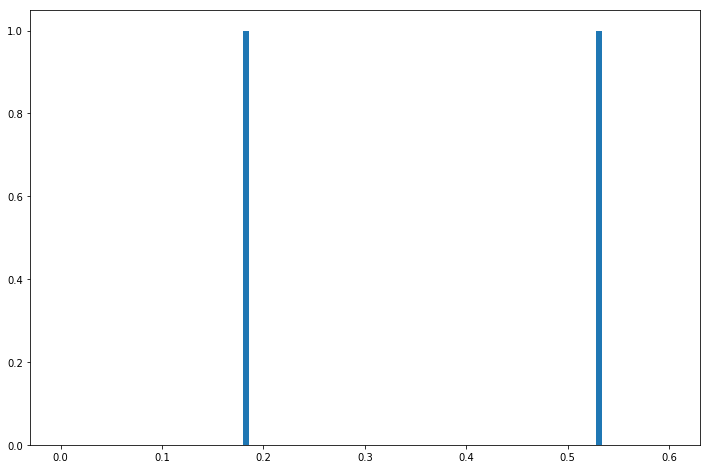

Total samples = 2
Iteration 3 SNR= 1 MEAN_ERR= 0.3578281738505456 MEDIAN_ERR= 0.3578281738505456
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456]


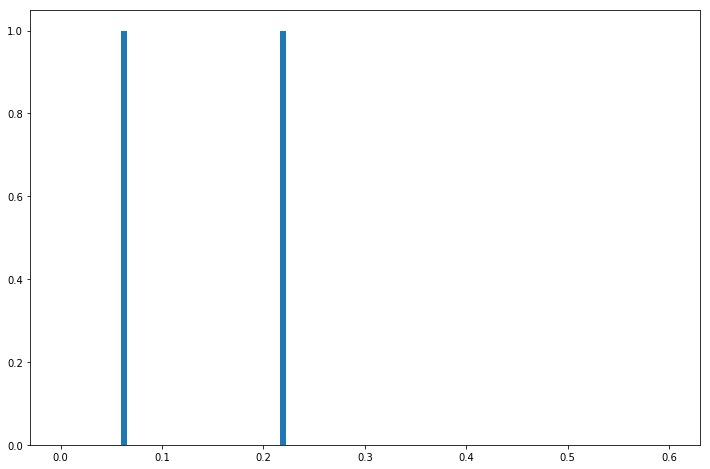

Total samples = 2
Iteration 4 SNR= 1 MEAN_ERR= 0.14328990014011167 MEDIAN_ERR= 0.14328990014011167
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167]


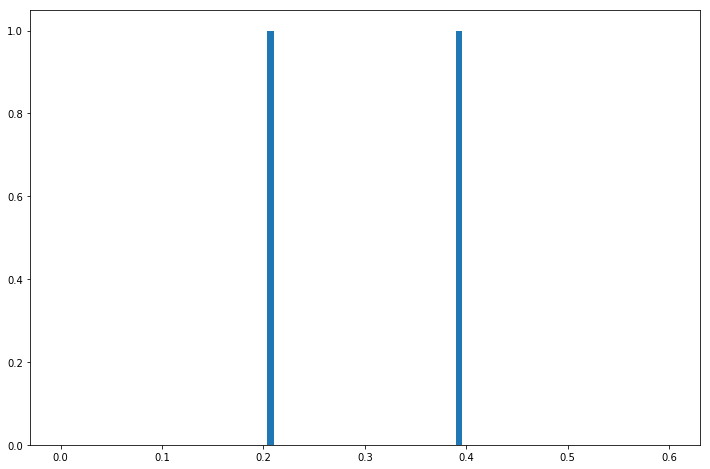

Total samples = 2
Iteration 5 SNR= 1 MEAN_ERR= 0.2996861234810617 MEDIAN_ERR= 0.2996861234810617
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617]


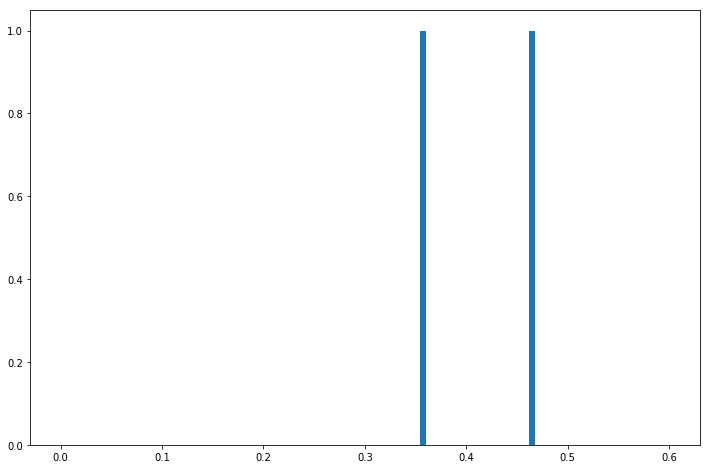

Total samples = 2
Iteration 6 SNR= 1 MEAN_ERR= 0.41072922411034174 MEDIAN_ERR= 0.41072922411034174
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174]


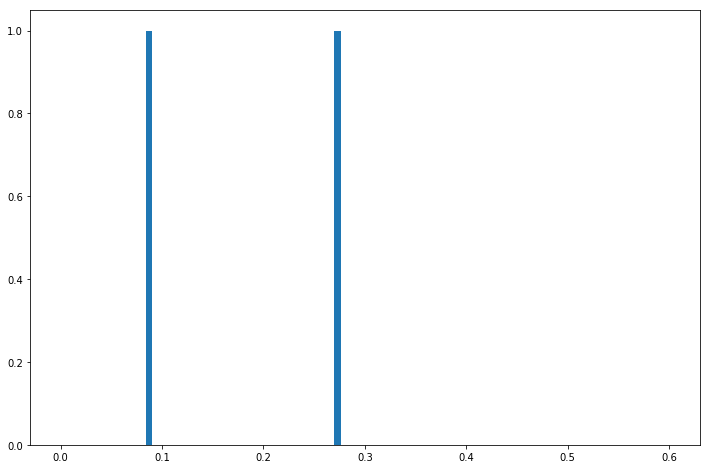

Total samples = 2
Iteration 7 SNR= 1 MEAN_ERR= 0.17853147634330668 MEDIAN_ERR= 0.17853147634330668
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668]


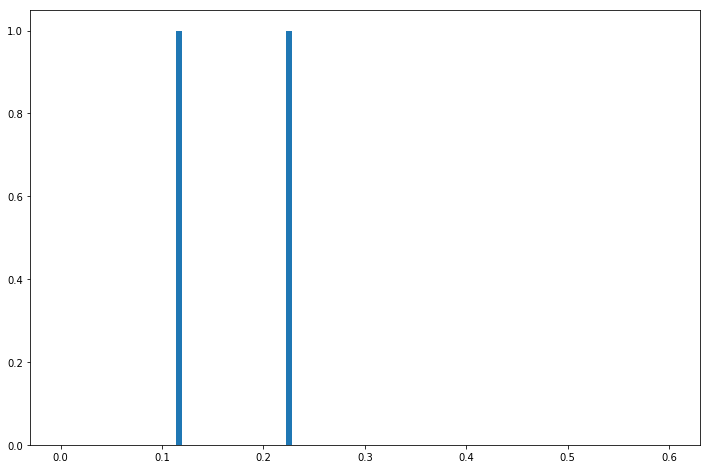

Total samples = 2
Iteration 8 SNR= 1 MEAN_ERR= 0.1714512935761042 MEDIAN_ERR= 0.1714512935761042
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042]


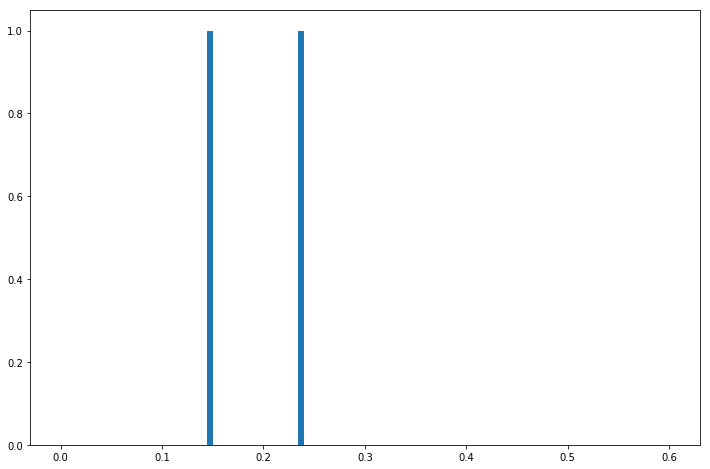

Total samples = 2
Iteration 9 SNR= 1 MEAN_ERR= 0.18995946354295323 MEDIAN_ERR= 0.18995946354295323
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323]


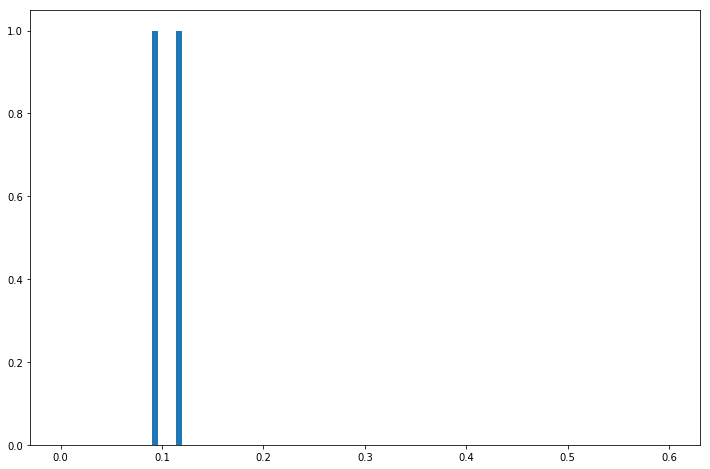

Total samples = 2
Iteration 0 SNR= 2 MEAN_ERR= 0.10456895021348107 MEDIAN_ERR= 0.10456895021348107
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107]


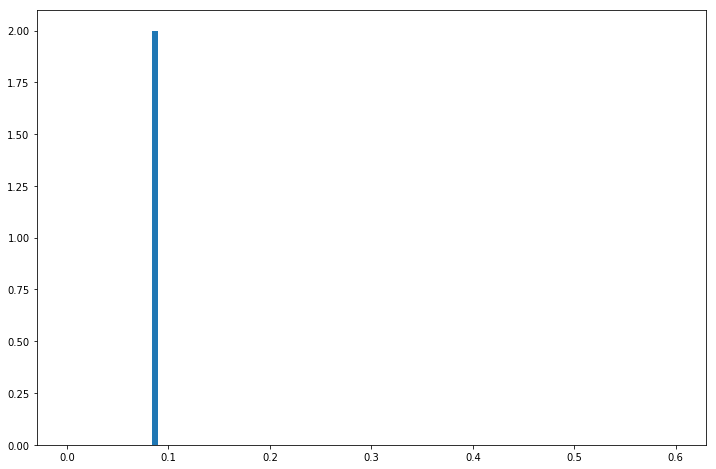

Total samples = 2
Iteration 1 SNR= 2 MEAN_ERR= 0.0862591984753549 MEDIAN_ERR= 0.0862591984753549
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549]


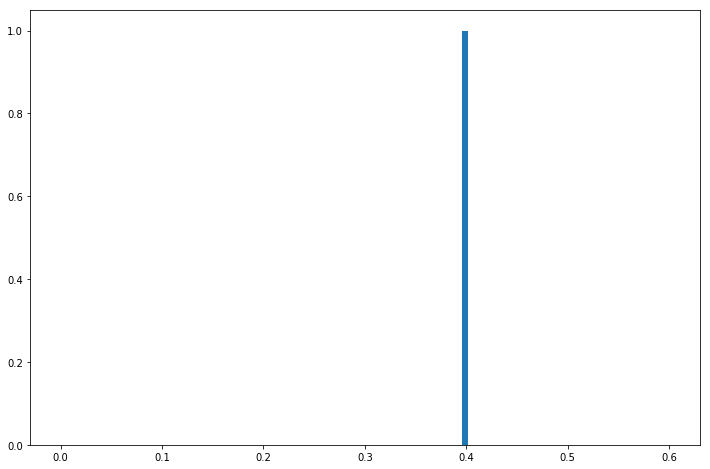

Total samples = 2
Iteration 2 SNR= 2 MEAN_ERR= 0.6286184364696512 MEDIAN_ERR= 0.6286184364696512
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512]


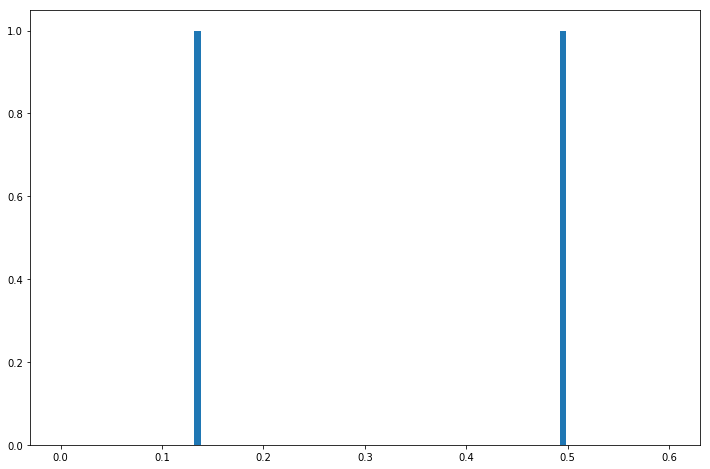

Total samples = 2
Iteration 3 SNR= 2 MEAN_ERR= 0.3150419217152967 MEDIAN_ERR= 0.3150419217152967
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967]


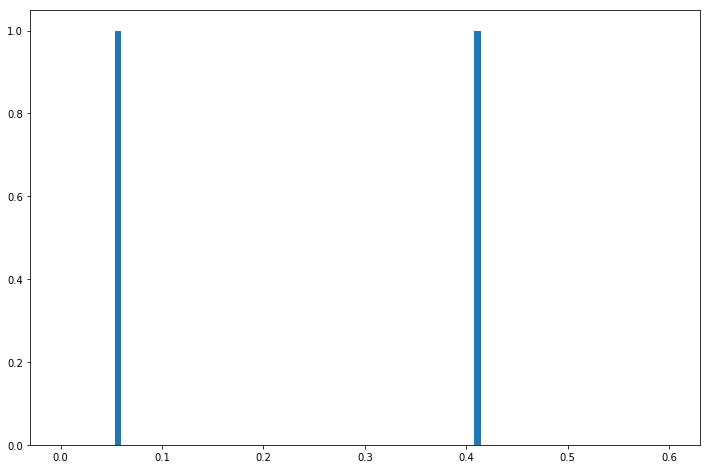

Total samples = 2
Iteration 4 SNR= 2 MEAN_ERR= 0.23468871082824835 MEDIAN_ERR= 0.23468871082824835
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835]


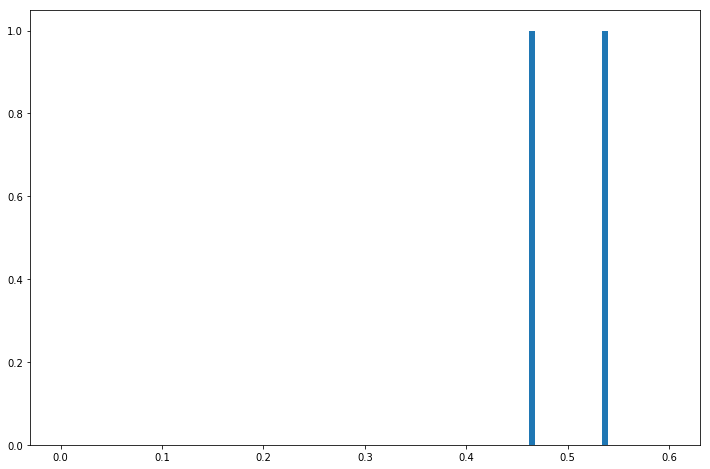

Total samples = 2
Iteration 5 SNR= 2 MEAN_ERR= 0.5000534980349756 MEDIAN_ERR= 0.5000534980349756
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756]


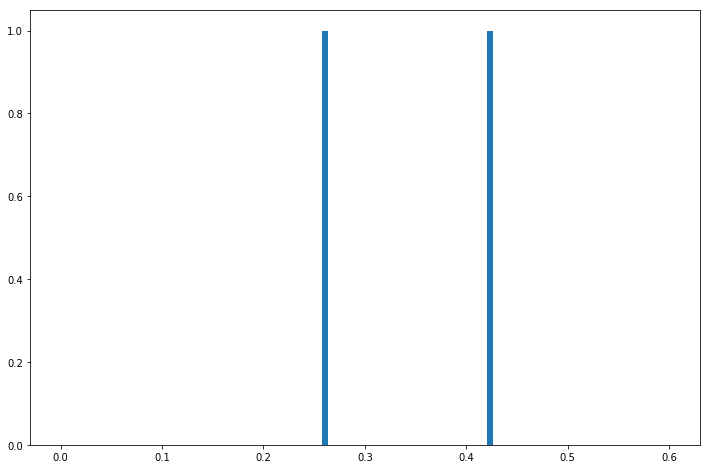

Total samples = 2
Iteration 6 SNR= 2 MEAN_ERR= 0.3418074080836877 MEDIAN_ERR= 0.3418074080836877
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877]


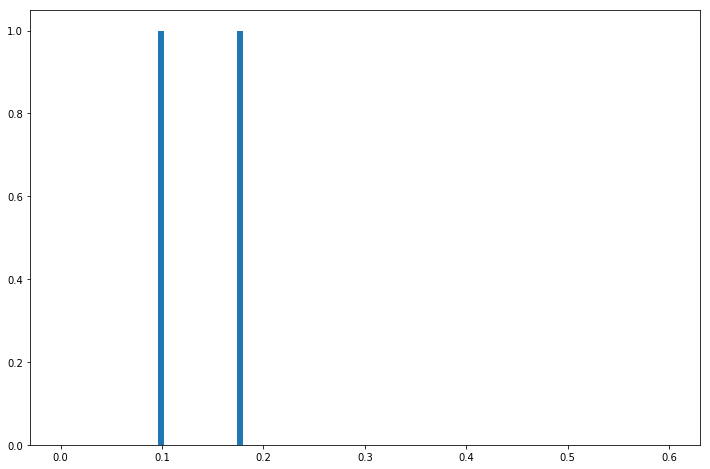

Total samples = 2
Iteration 7 SNR= 2 MEAN_ERR= 0.13925952077986636 MEDIAN_ERR= 0.13925952077986636
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636]


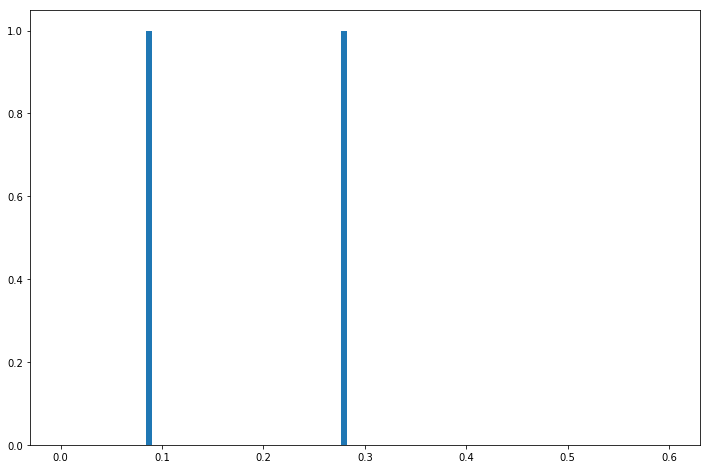

Total samples = 2
Iteration 8 SNR= 2 MEAN_ERR= 0.18268270478464319 MEDIAN_ERR= 0.18268270478464319
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319]


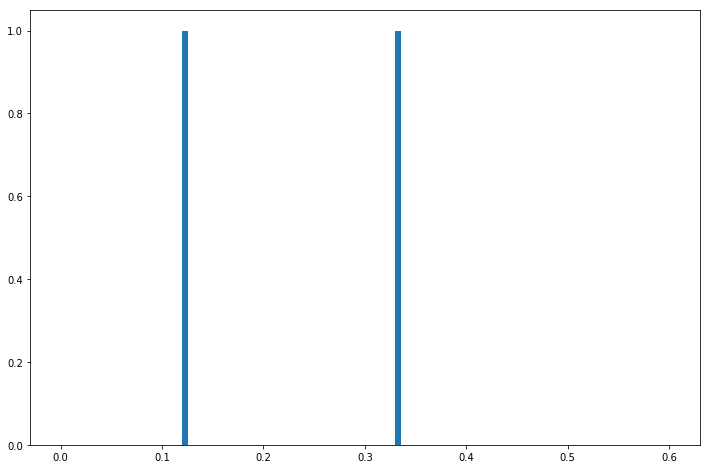

Total samples = 2
Iteration 9 SNR= 2 MEAN_ERR= 0.2277137020332186 MEDIAN_ERR= 0.2277137020332186
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186]


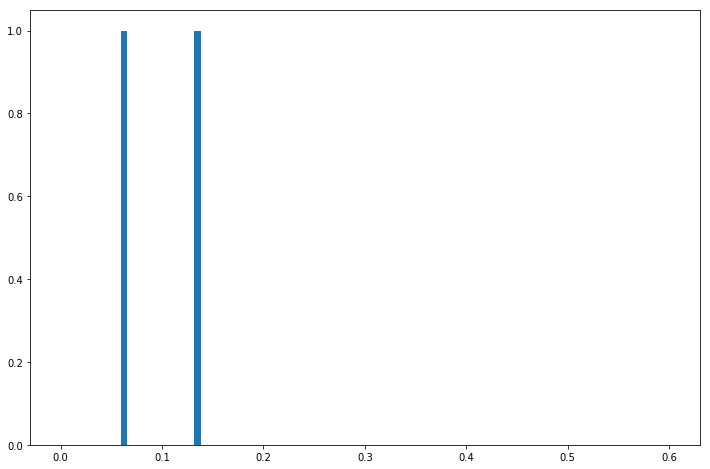

Total samples = 2
Iteration 0 SNR= 3 MEAN_ERR= 0.09982195460650325 MEDIAN_ERR= 0.09982195460650325
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325]


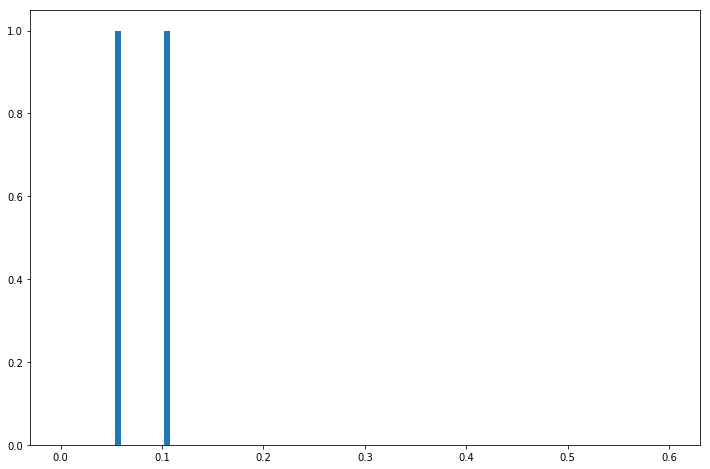

Total samples = 2
Iteration 1 SNR= 3 MEAN_ERR= 0.07887321202931827 MEDIAN_ERR= 0.07887321202931827
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827]


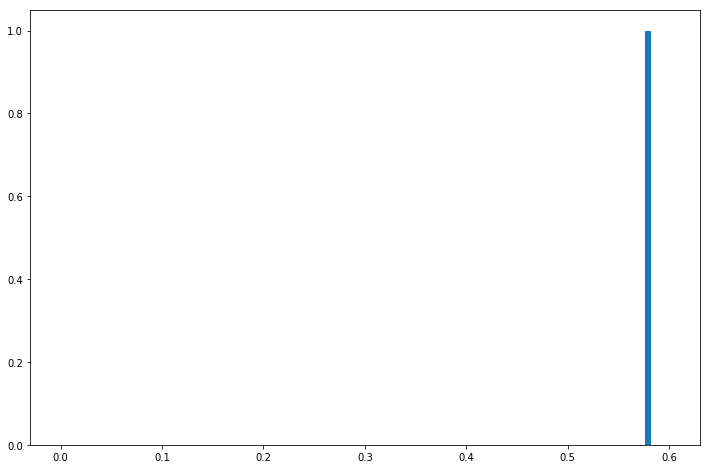

Total samples = 2
Iteration 2 SNR= 3 MEAN_ERR= 0.7898498541422374 MEDIAN_ERR= 0.7898498541422374
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374]


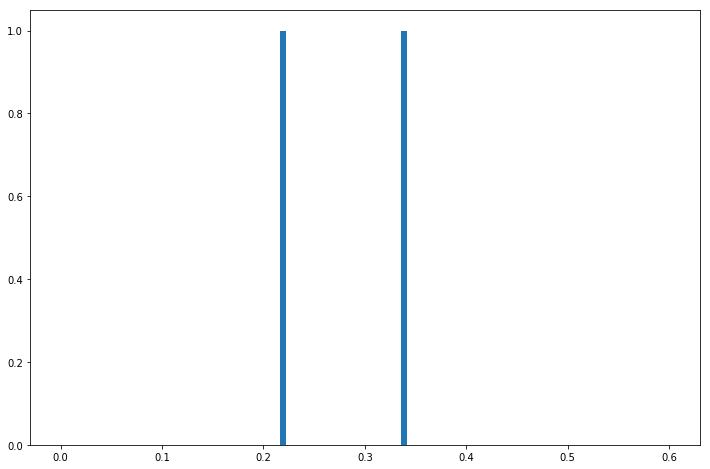

Total samples = 2
Iteration 3 SNR= 3 MEAN_ERR= 0.276819226599406 MEDIAN_ERR= 0.276819226599406
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406]


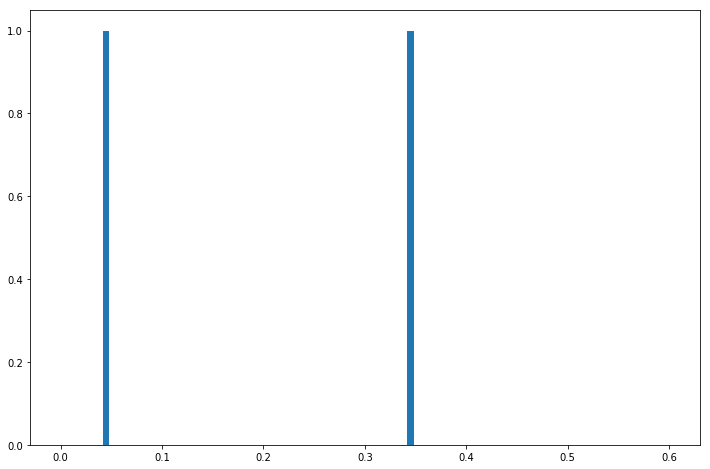

Total samples = 2
Iteration 4 SNR= 3 MEAN_ERR= 0.19484338741507085 MEDIAN_ERR= 0.19484338741507085
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085]


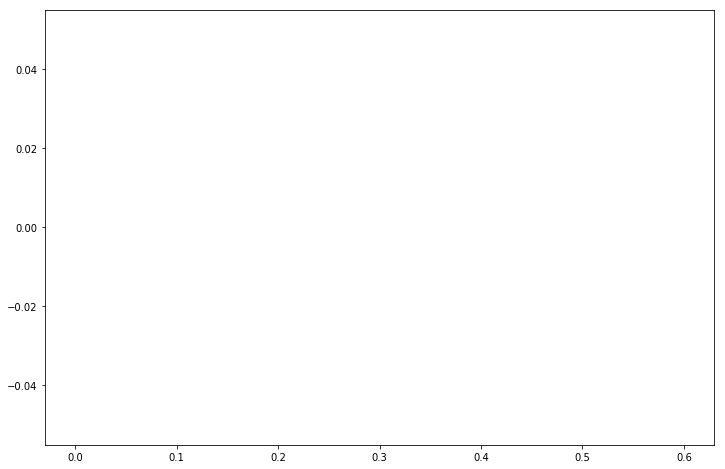

Total samples = 2
Iteration 5 SNR= 3 MEAN_ERR= 1.0100965022983899 MEDIAN_ERR= 1.0100965022983899
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899]


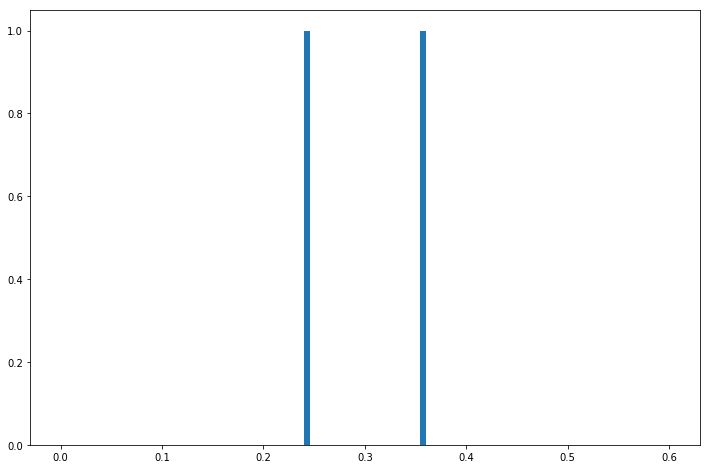

Total samples = 2
Iteration 6 SNR= 3 MEAN_ERR= 0.3003479011392206 MEDIAN_ERR= 0.3003479011392206
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206]


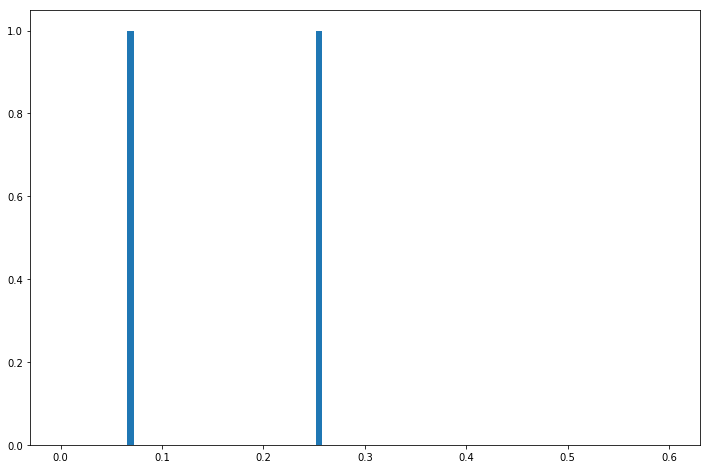

Total samples = 2
Iteration 7 SNR= 3 MEAN_ERR= 0.16003242522313776 MEDIAN_ERR= 0.16003242522313776
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776]


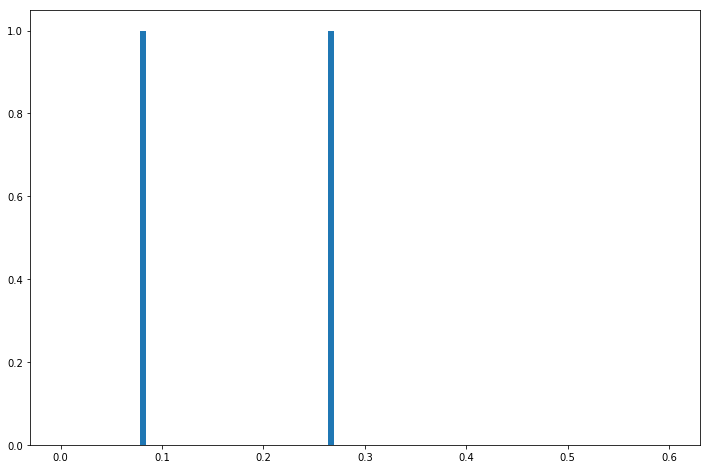

Total samples = 2
Iteration 8 SNR= 3 MEAN_ERR= 0.17409888362616727 MEDIAN_ERR= 0.17409888362616727
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727]


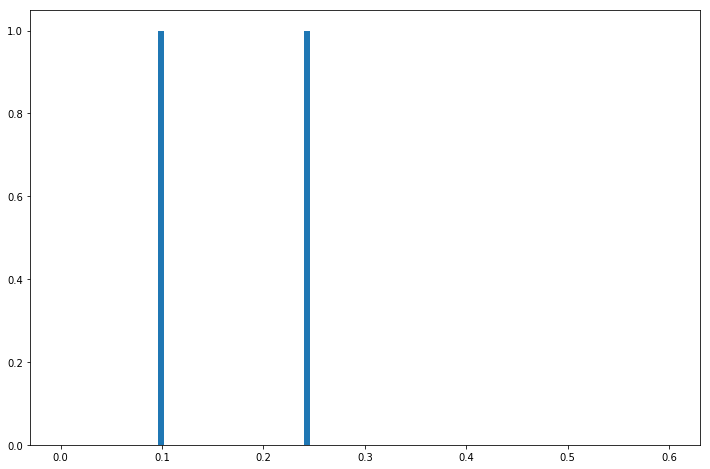

Total samples = 2
Iteration 9 SNR= 3 MEAN_ERR= 0.1709127895516728 MEDIAN_ERR= 0.1709127895516728
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728]


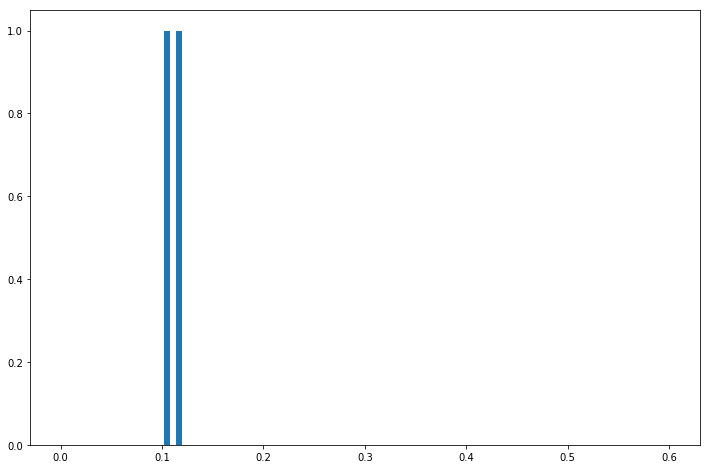

Total samples = 2
Iteration 0 SNR= 4 MEAN_ERR= 0.11141756883496384 MEDIAN_ERR= 0.11141756883496384
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384]


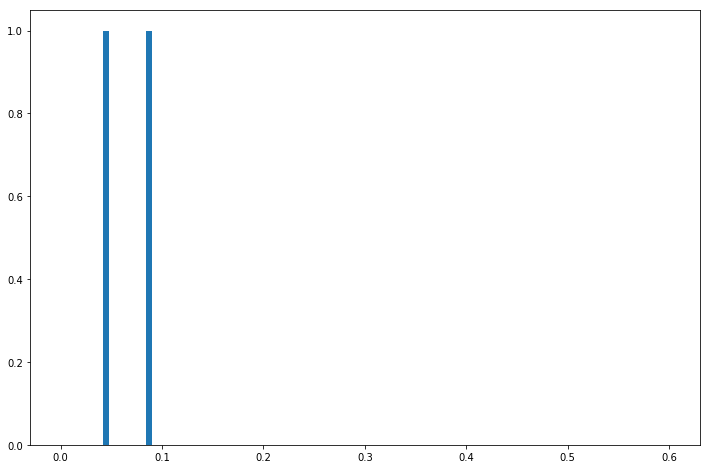

Total samples = 2
Iteration 1 SNR= 4 MEAN_ERR= 0.06853325110042838 MEDIAN_ERR= 0.06853325110042838
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384, 0.06853325110042838]


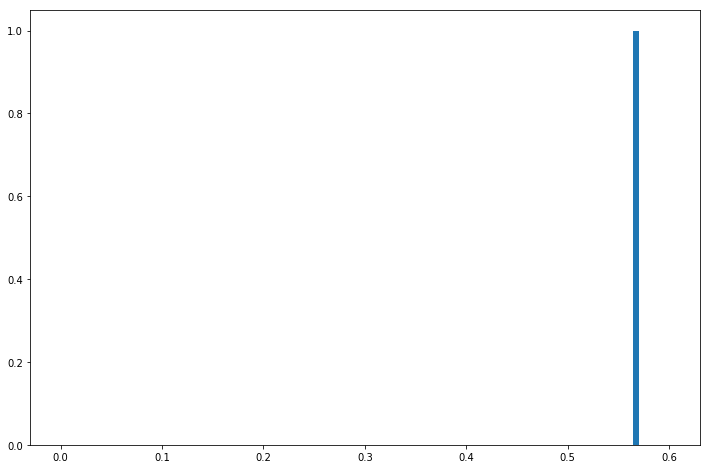

Total samples = 2
Iteration 2 SNR= 4 MEAN_ERR= 0.7716969921913064 MEDIAN_ERR= 0.7716969921913064
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384, 0.06853325110042838, 0.7716969921913064]


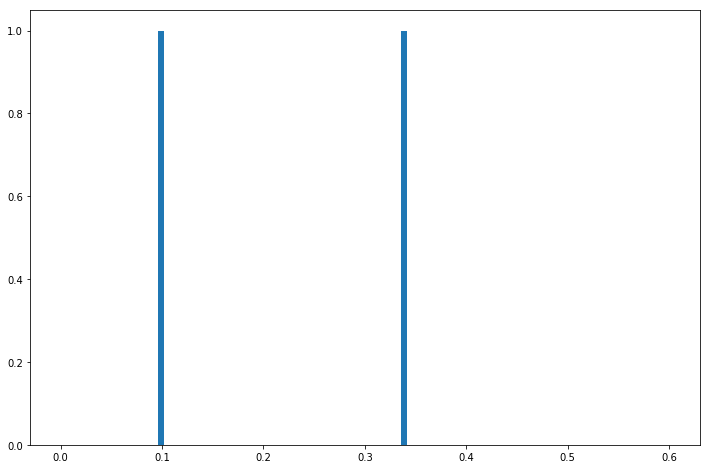

Total samples = 2
Iteration 3 SNR= 4 MEAN_ERR= 0.21952513961243172 MEDIAN_ERR= 0.21952513961243172
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384, 0.06853325110042838, 0.7716969921913064, 0.219525139612431

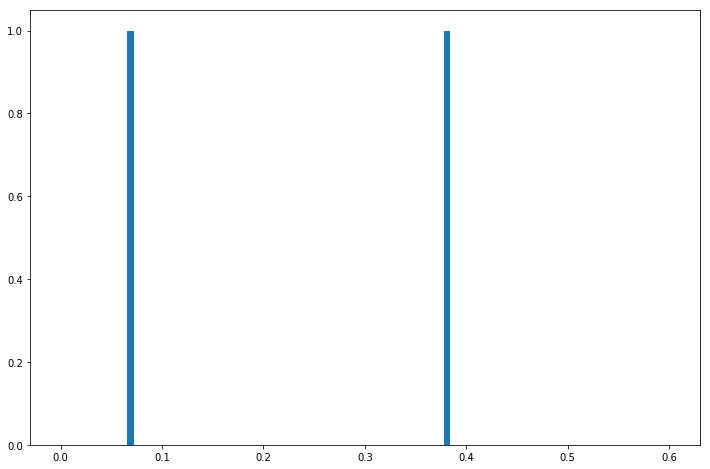

Total samples = 2
Iteration 4 SNR= 4 MEAN_ERR= 0.22604815986362214 MEDIAN_ERR= 0.22604815986362214
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384, 0.06853325110042838, 0.7716969921913064, 0.219525139612431

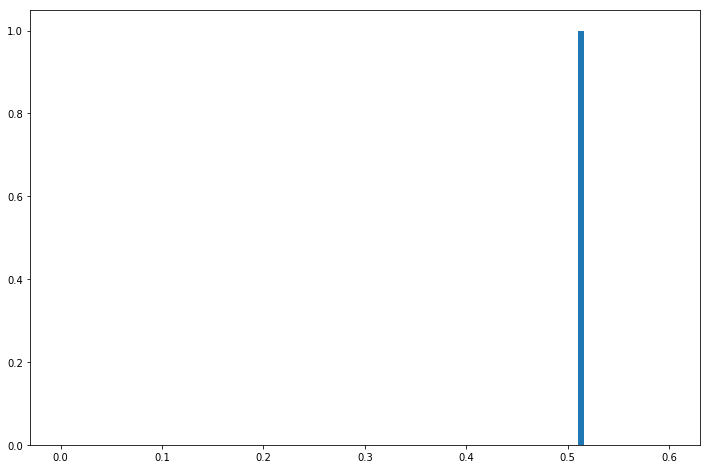

Total samples = 2
Iteration 5 SNR= 4 MEAN_ERR= 0.6512881859288229 MEDIAN_ERR= 0.6512881859288229
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384, 0.06853325110042838, 0.7716969921913064, 0.21952513961243172

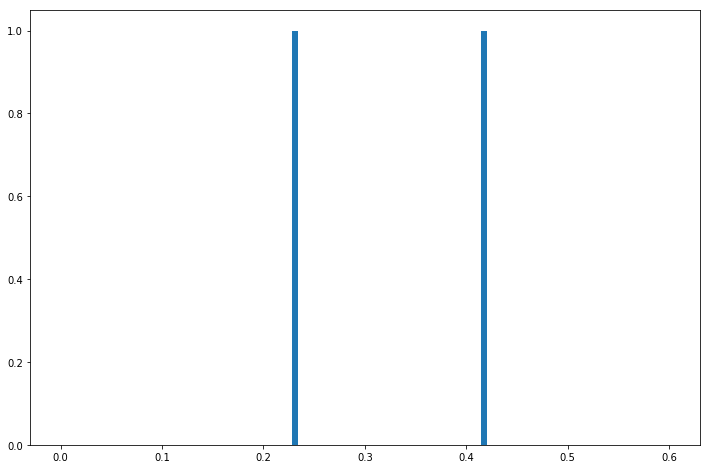

Total samples = 2
Iteration 6 SNR= 4 MEAN_ERR= 0.3240411900848883 MEDIAN_ERR= 0.3240411900848883
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384, 0.06853325110042838, 0.7716969921913064, 0.21952513961243172

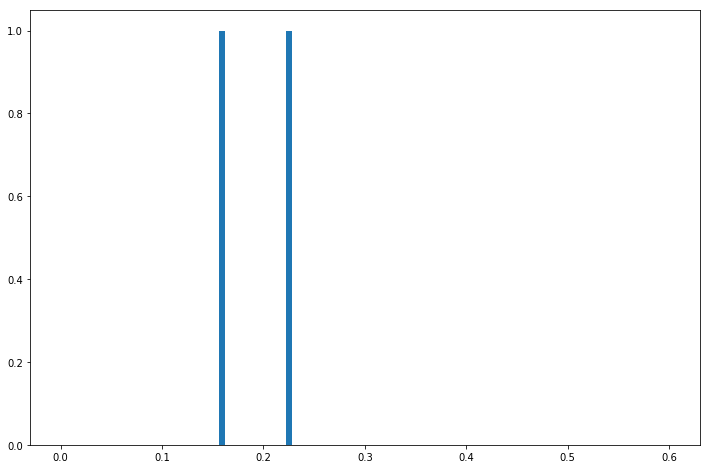

Total samples = 2
Iteration 7 SNR= 4 MEAN_ERR= 0.192830704991925 MEDIAN_ERR= 0.192830704991925
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384, 0.06853325110042838, 0.7716969921913064, 0.21952513961243172, 

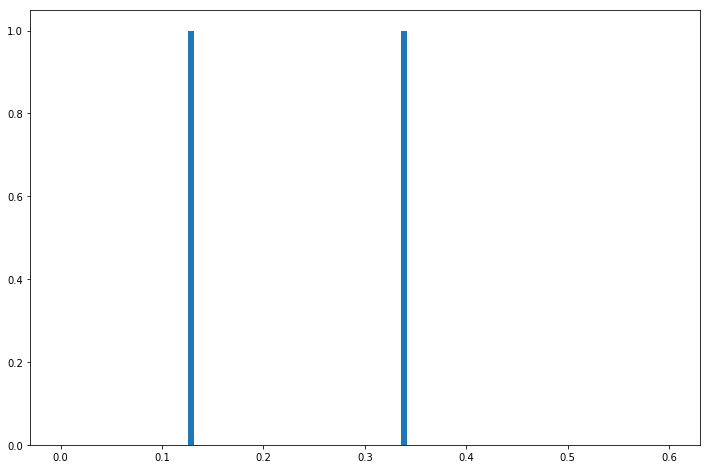

Total samples = 2
Iteration 8 SNR= 4 MEAN_ERR= 0.23589054853214858 MEDIAN_ERR= 0.23589054853214858
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384, 0.06853325110042838, 0.7716969921913064, 0.219525139612431

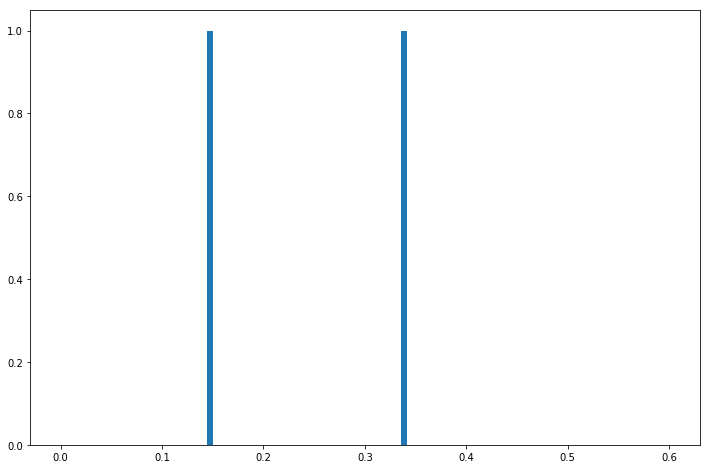

Total samples = 2
Iteration 9 SNR= 4 MEAN_ERR= 0.2429932407335702 MEDIAN_ERR= 0.2429932407335702
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384, 0.06853325110042838, 0.7716969921913064, 0.21952513961243172

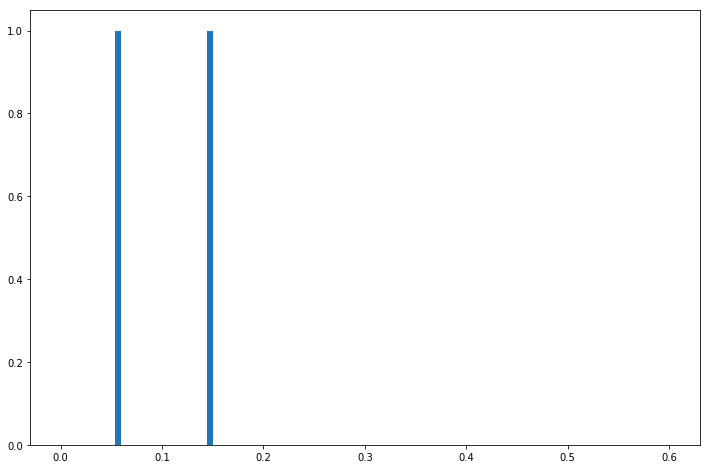

Total samples = 2
Iteration 0 SNR= 0 MEAN_ERR= 0.10106263857284258 MEDIAN_ERR= 0.10106263857284258
[0.10106263857284258]


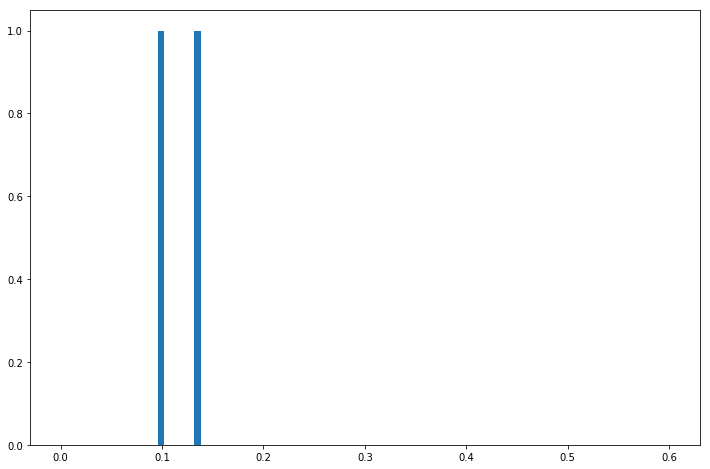

Total samples = 2
Iteration 1 SNR= 0 MEAN_ERR= 0.11729435119386444 MEDIAN_ERR= 0.11729435119386444
[0.10106263857284258, 0.11729435119386444]


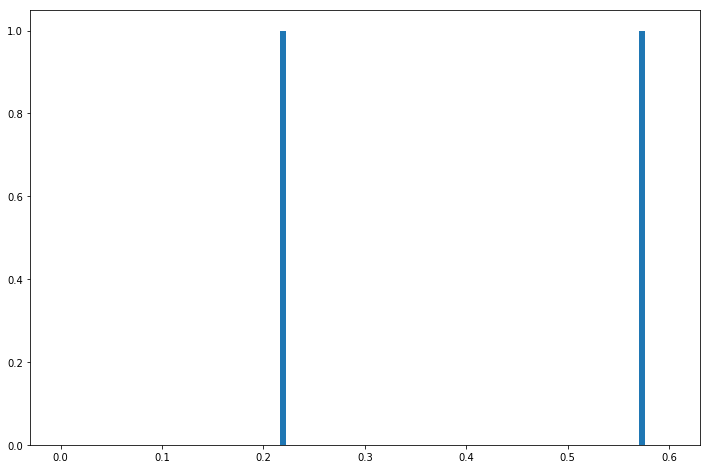

Total samples = 2
Iteration 2 SNR= 0 MEAN_ERR= 0.3980242945448038 MEDIAN_ERR= 0.3980242945448038
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038]


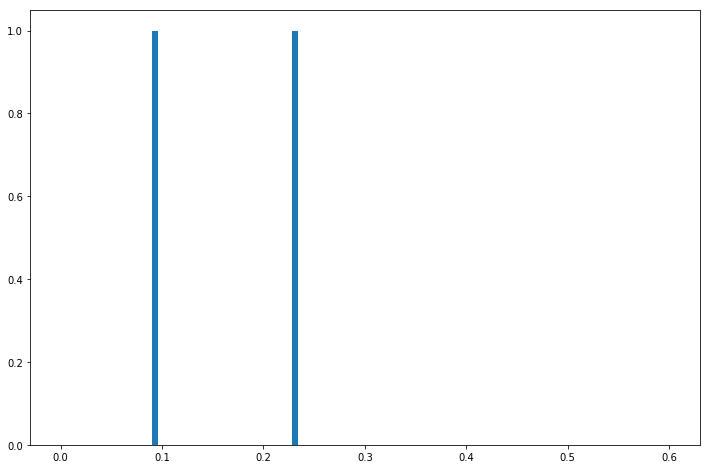

Total samples = 2
Iteration 3 SNR= 0 MEAN_ERR= 0.16124785129296867 MEDIAN_ERR= 0.16124785129296867
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867]


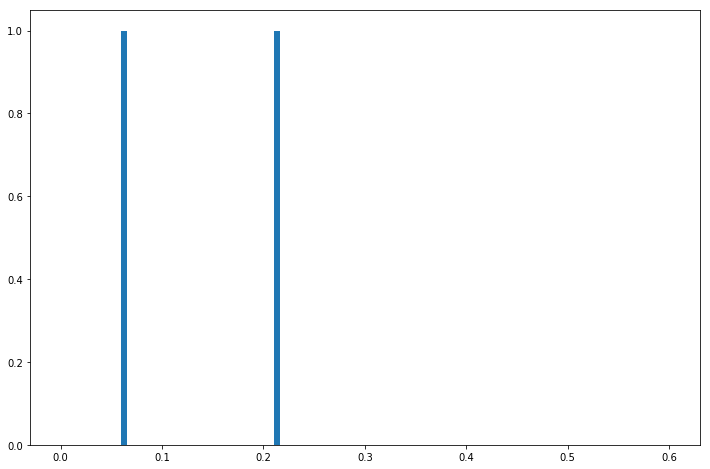

Total samples = 2
Iteration 4 SNR= 0 MEAN_ERR= 0.13682524357315362 MEDIAN_ERR= 0.13682524357315362
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362]


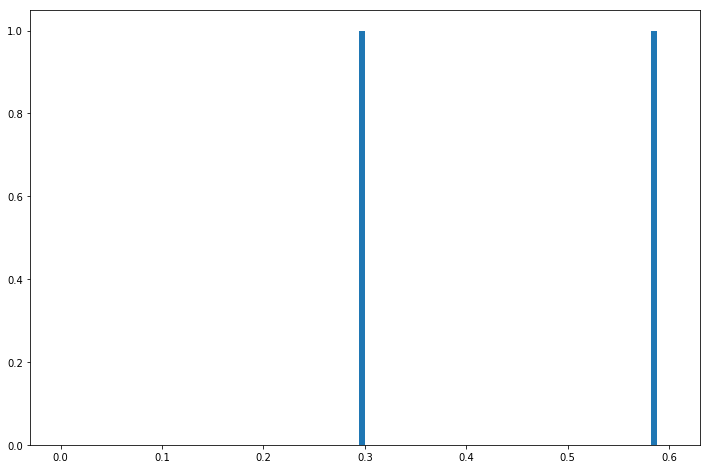

Total samples = 2
Iteration 5 SNR= 0 MEAN_ERR= 0.44071808964659265 MEDIAN_ERR= 0.44071808964659265
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265]


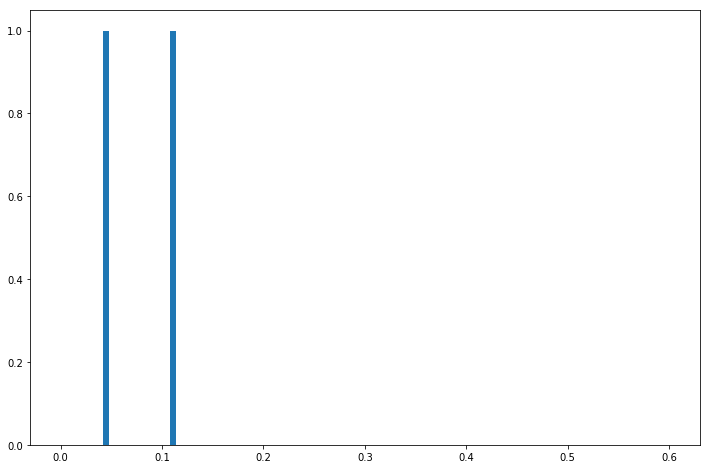

Total samples = 2
Iteration 6 SNR= 0 MEAN_ERR= 0.0780796123975655 MEDIAN_ERR= 0.0780796123975655
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655]


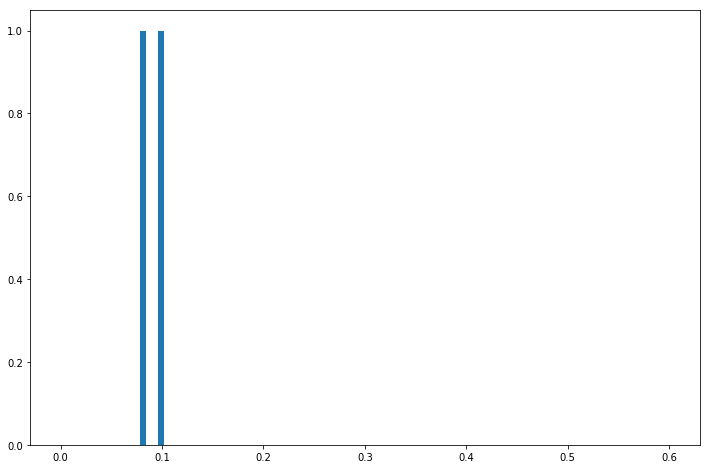

Total samples = 2
Iteration 7 SNR= 0 MEAN_ERR= 0.09236092519637118 MEDIAN_ERR= 0.09236092519637118
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118]


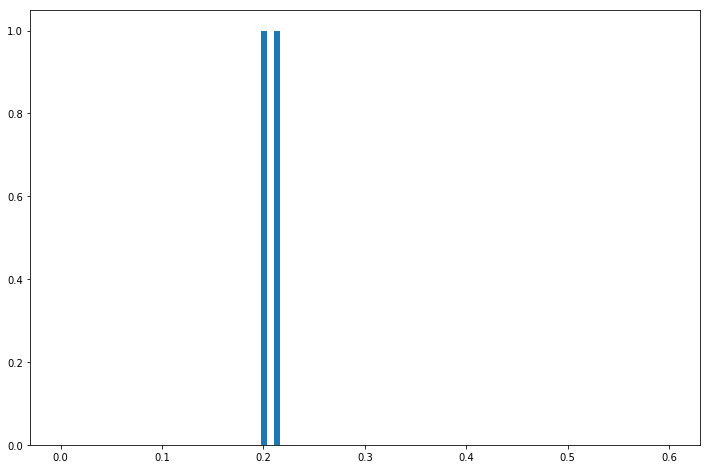

Total samples = 2
Iteration 8 SNR= 0 MEAN_ERR= 0.20711364494306927 MEDIAN_ERR= 0.20711364494306927
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927]


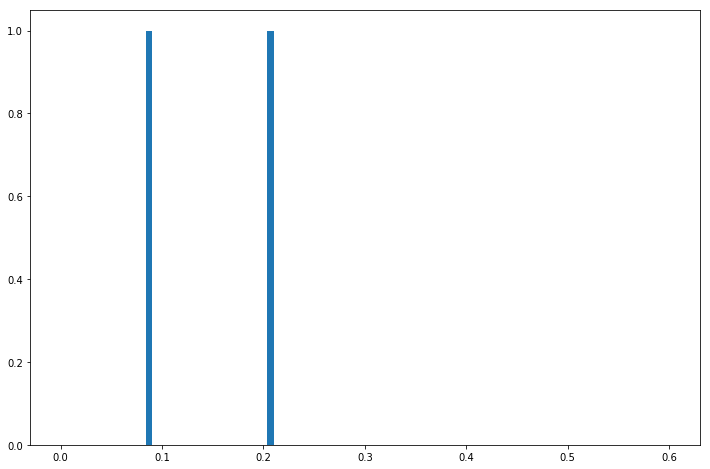

Total samples = 2
Iteration 9 SNR= 0 MEAN_ERR= 0.14726491818779022 MEDIAN_ERR= 0.14726491818779022
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022]


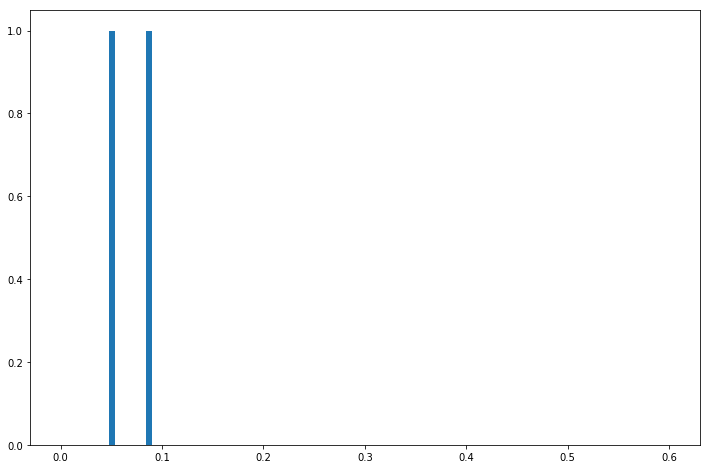

Total samples = 2
Iteration 0 SNR= 1 MEAN_ERR= 0.06844930013322181 MEDIAN_ERR= 0.06844930013322181
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181]


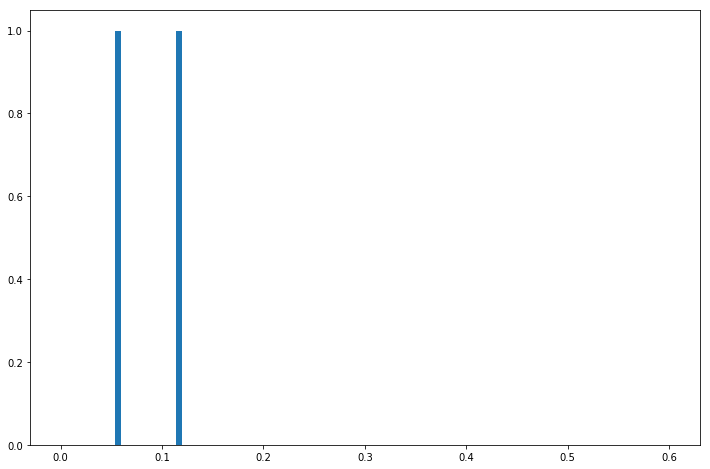

Total samples = 2
Iteration 1 SNR= 1 MEAN_ERR= 0.08832485983101171 MEDIAN_ERR= 0.08832485983101171
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171]


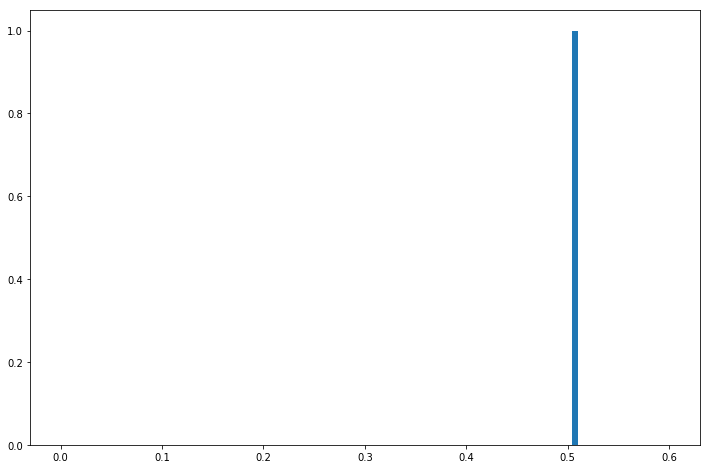

Total samples = 2
Iteration 2 SNR= 1 MEAN_ERR= 0.733366620299108 MEDIAN_ERR= 0.733366620299108
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108]


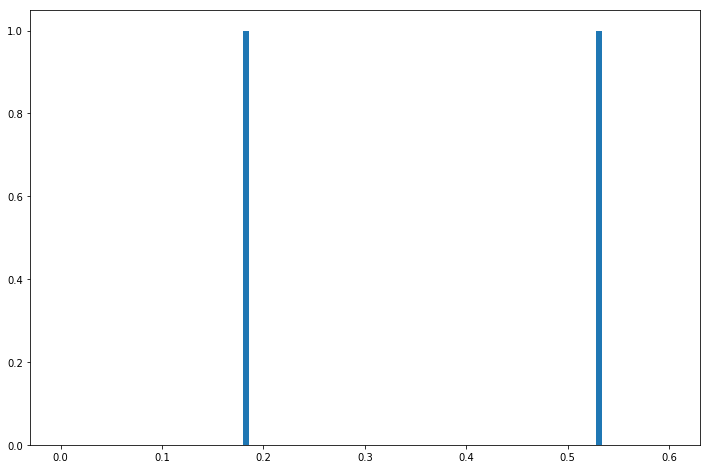

Total samples = 2
Iteration 3 SNR= 1 MEAN_ERR= 0.3578281738505456 MEDIAN_ERR= 0.3578281738505456
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456]


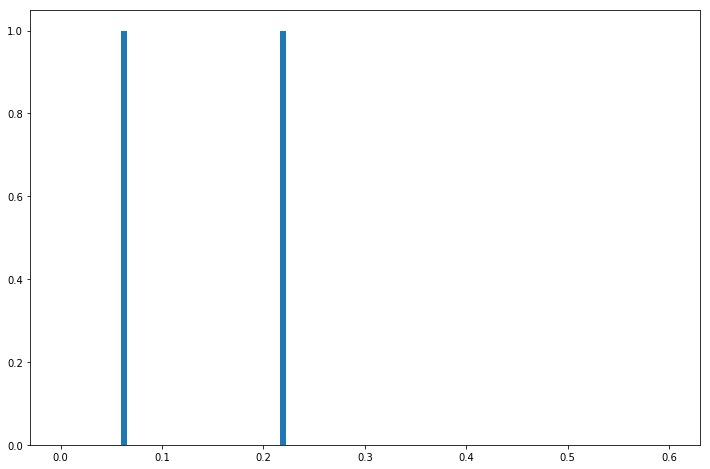

Total samples = 2
Iteration 4 SNR= 1 MEAN_ERR= 0.14328990014011167 MEDIAN_ERR= 0.14328990014011167
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167]


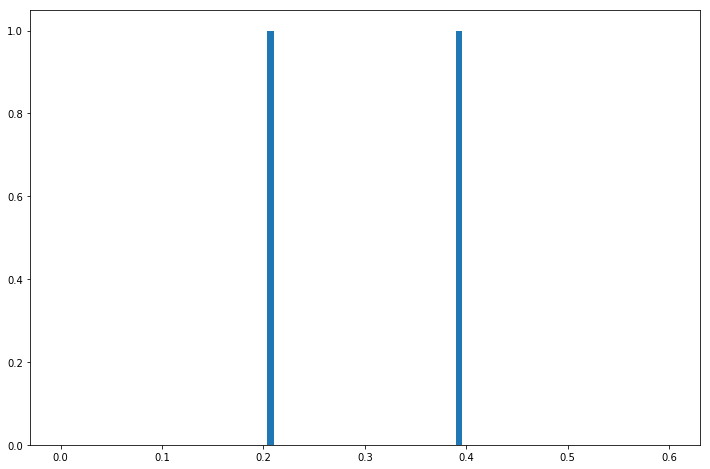

Total samples = 2
Iteration 5 SNR= 1 MEAN_ERR= 0.2996861234810617 MEDIAN_ERR= 0.2996861234810617
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617]


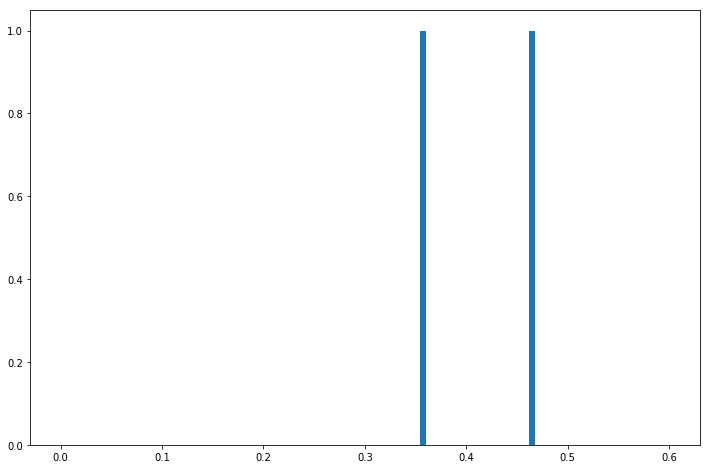

Total samples = 2
Iteration 6 SNR= 1 MEAN_ERR= 0.41072922411034174 MEDIAN_ERR= 0.41072922411034174
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174]


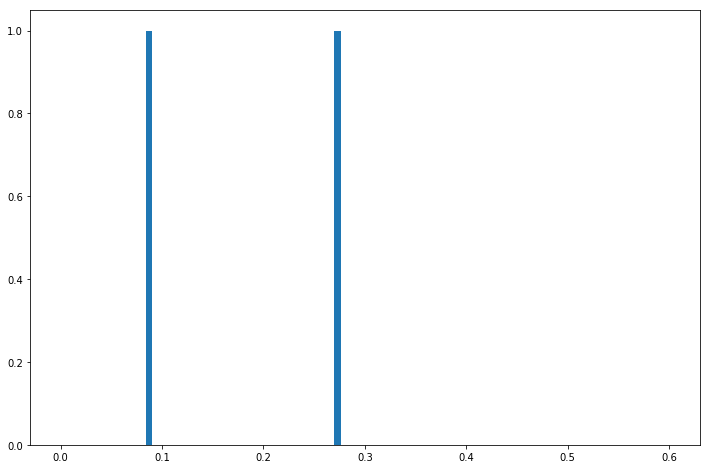

Total samples = 2
Iteration 7 SNR= 1 MEAN_ERR= 0.17853147634330668 MEDIAN_ERR= 0.17853147634330668
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668]


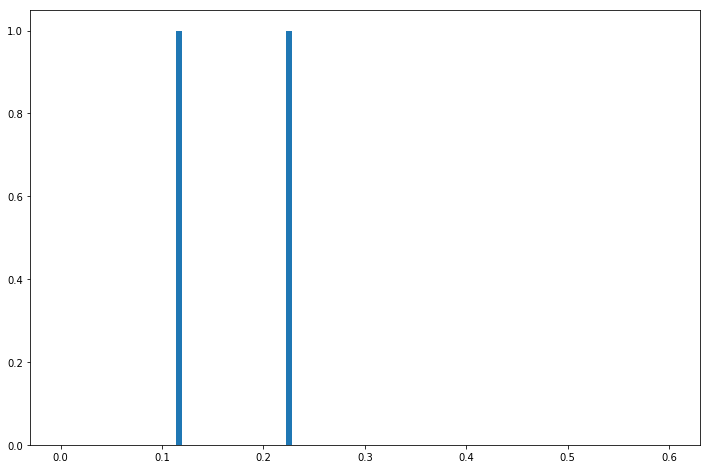

Total samples = 2
Iteration 8 SNR= 1 MEAN_ERR= 0.1714512935761042 MEDIAN_ERR= 0.1714512935761042
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042]


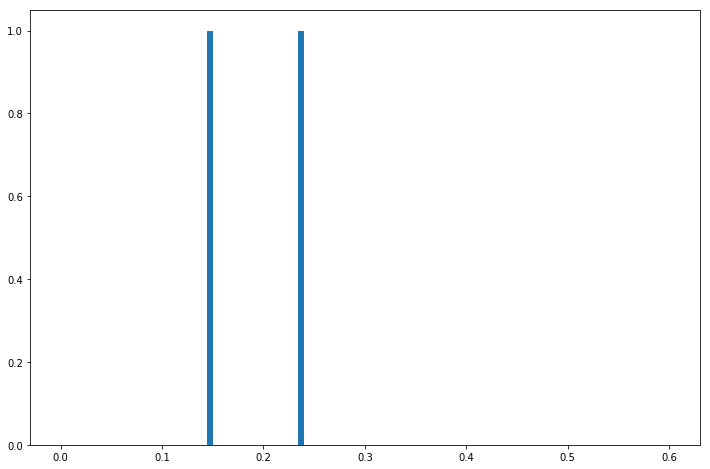

Total samples = 2
Iteration 9 SNR= 1 MEAN_ERR= 0.18995946354295323 MEDIAN_ERR= 0.18995946354295323
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323]


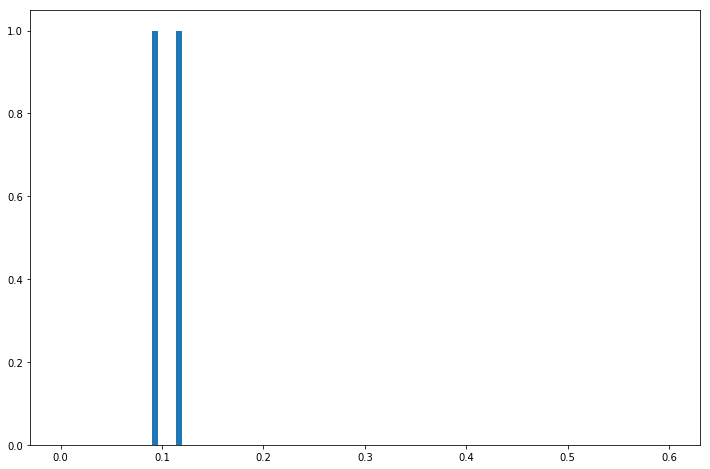

Total samples = 2
Iteration 0 SNR= 2 MEAN_ERR= 0.10456895021348107 MEDIAN_ERR= 0.10456895021348107
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107]


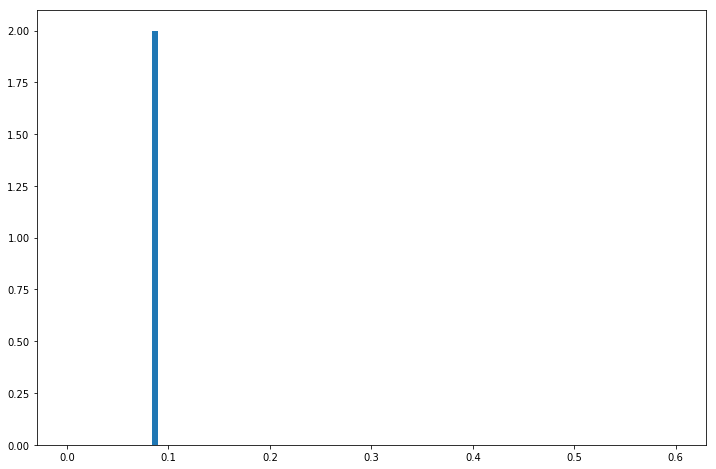

Total samples = 2
Iteration 1 SNR= 2 MEAN_ERR= 0.0862591984753549 MEDIAN_ERR= 0.0862591984753549
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549]


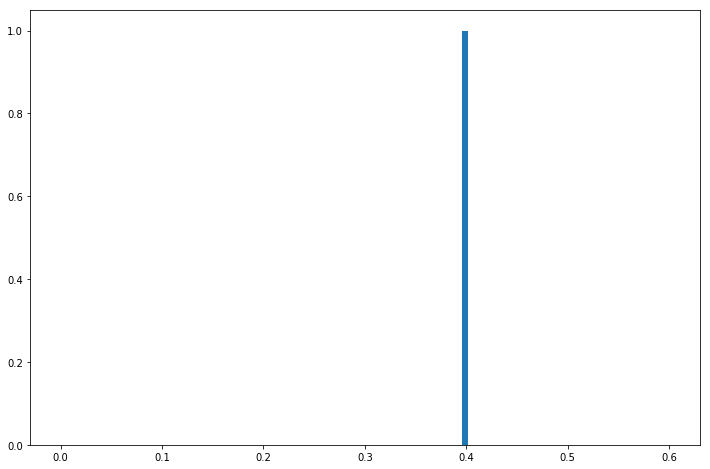

Total samples = 2
Iteration 2 SNR= 2 MEAN_ERR= 0.6286184364696512 MEDIAN_ERR= 0.6286184364696512
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512]


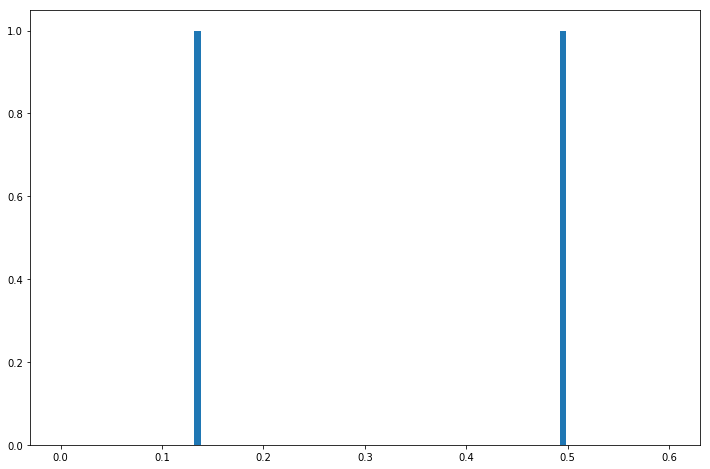

Total samples = 2
Iteration 3 SNR= 2 MEAN_ERR= 0.3150419217152967 MEDIAN_ERR= 0.3150419217152967
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967]


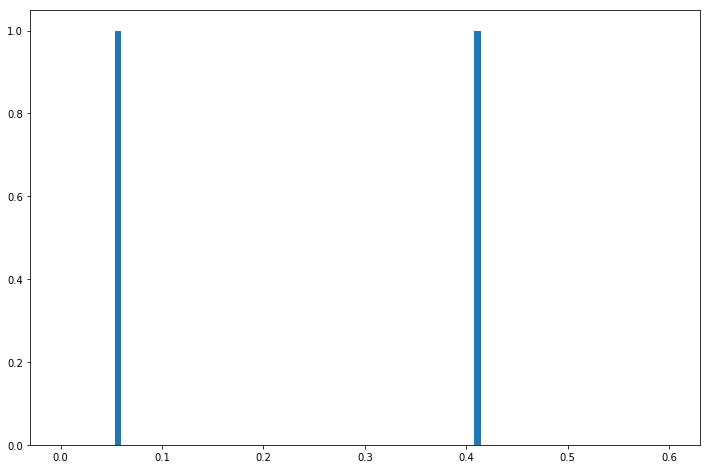

Total samples = 2
Iteration 4 SNR= 2 MEAN_ERR= 0.23468871082824835 MEDIAN_ERR= 0.23468871082824835
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835]


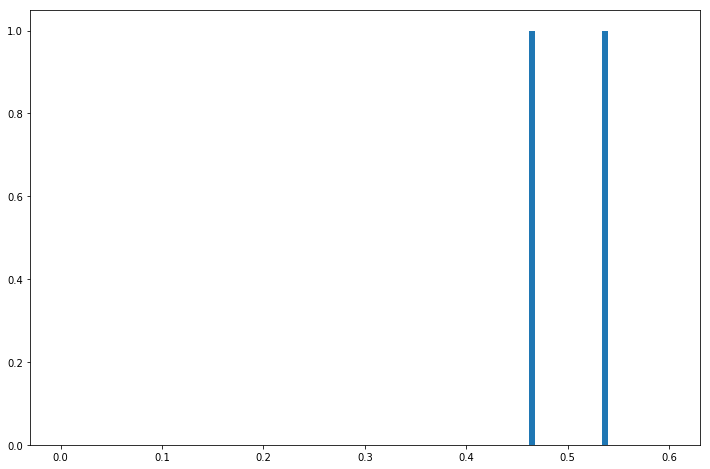

Total samples = 2
Iteration 5 SNR= 2 MEAN_ERR= 0.5000534980349756 MEDIAN_ERR= 0.5000534980349756
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756]


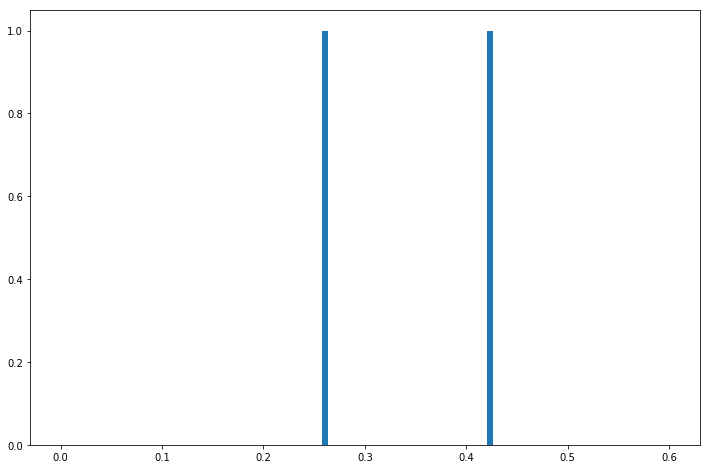

Total samples = 2
Iteration 6 SNR= 2 MEAN_ERR= 0.3418074080836877 MEDIAN_ERR= 0.3418074080836877
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877]


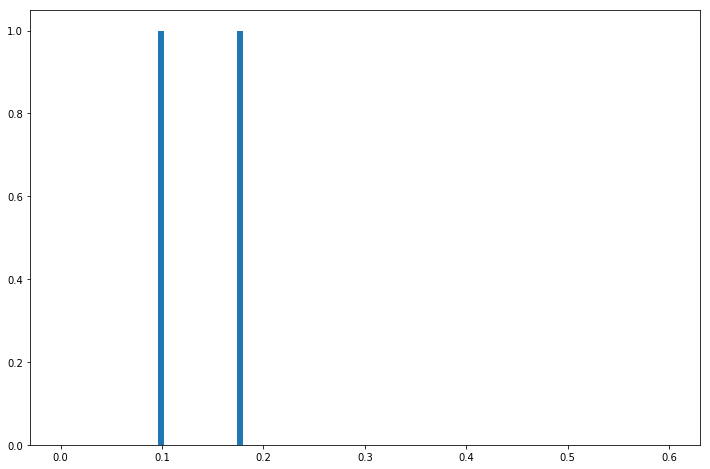

Total samples = 2
Iteration 7 SNR= 2 MEAN_ERR= 0.13925952077986636 MEDIAN_ERR= 0.13925952077986636
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636]


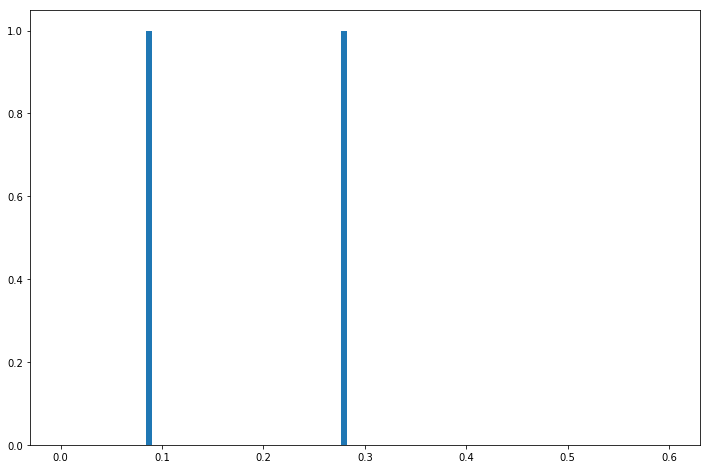

Total samples = 2
Iteration 8 SNR= 2 MEAN_ERR= 0.18268270478464319 MEDIAN_ERR= 0.18268270478464319
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319]


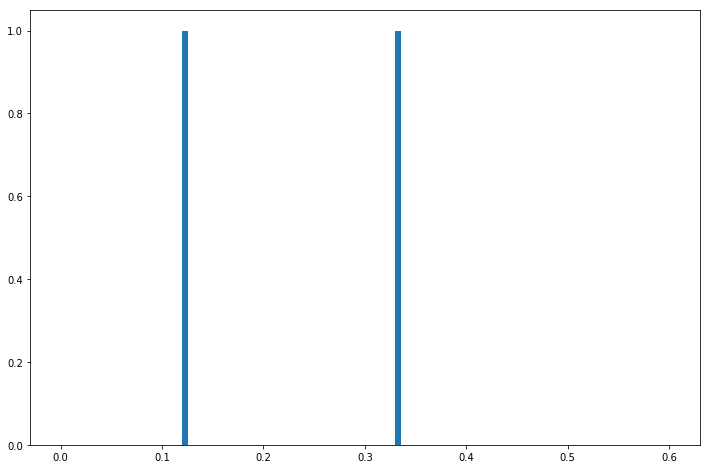

Total samples = 2
Iteration 9 SNR= 2 MEAN_ERR= 0.2277137020332186 MEDIAN_ERR= 0.2277137020332186
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186]


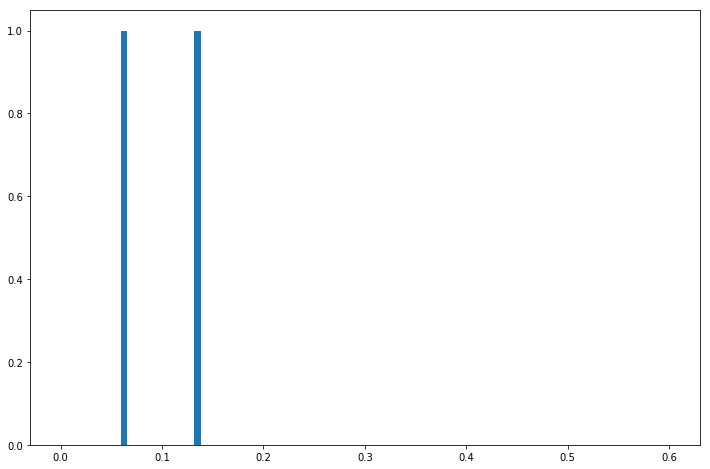

Total samples = 2
Iteration 0 SNR= 3 MEAN_ERR= 0.09982195460650325 MEDIAN_ERR= 0.09982195460650325
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325]


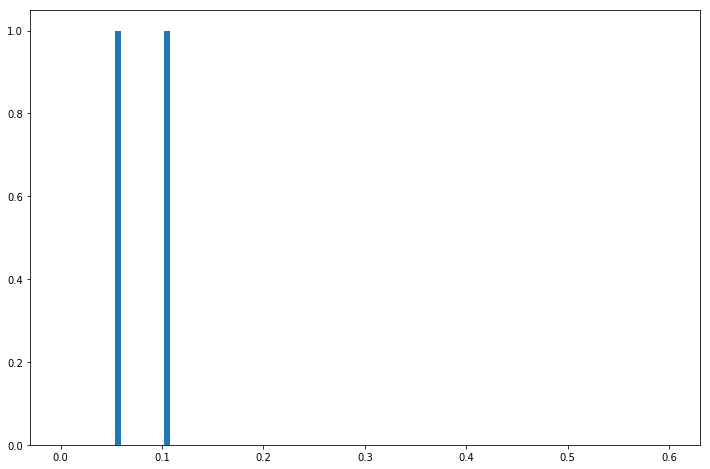

Total samples = 2
Iteration 1 SNR= 3 MEAN_ERR= 0.07887321202931827 MEDIAN_ERR= 0.07887321202931827
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827]


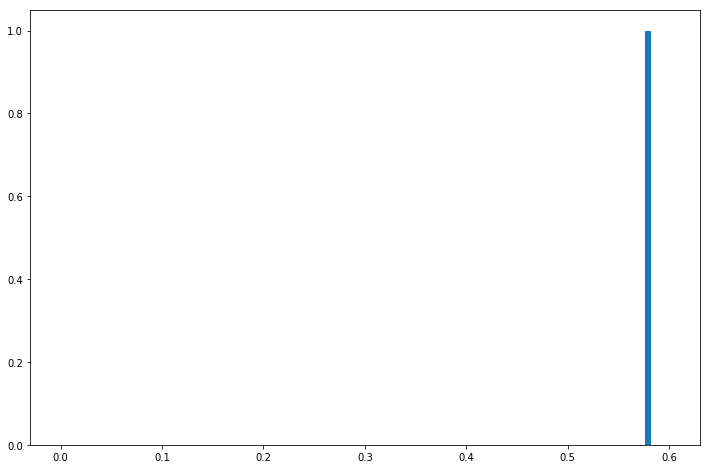

Total samples = 2
Iteration 2 SNR= 3 MEAN_ERR= 0.7898498541422374 MEDIAN_ERR= 0.7898498541422374
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374]


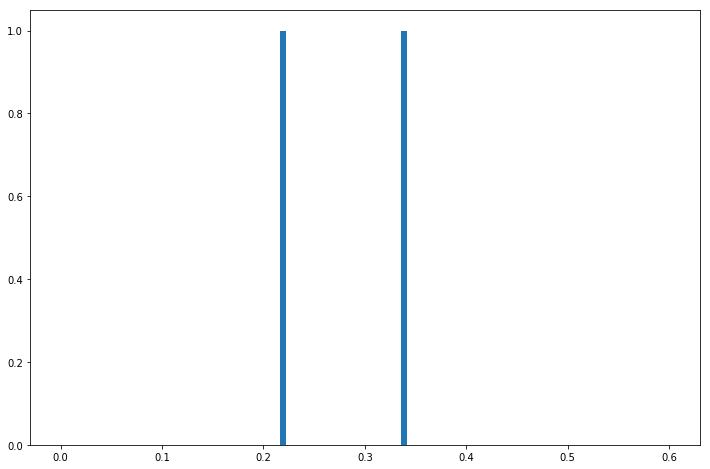

Total samples = 2
Iteration 3 SNR= 3 MEAN_ERR= 0.276819226599406 MEDIAN_ERR= 0.276819226599406
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406]


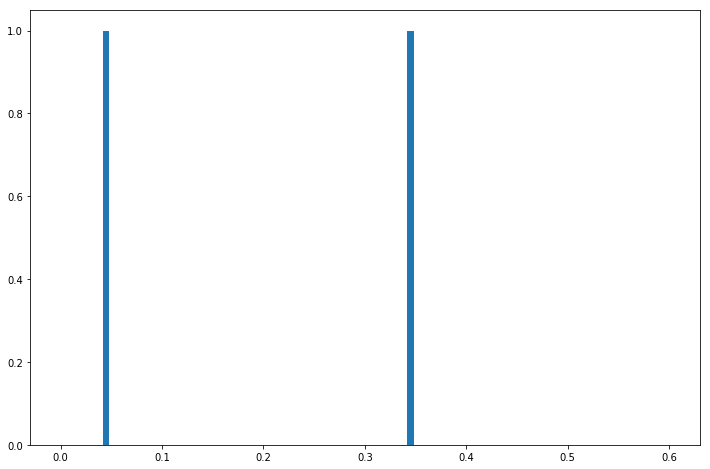

Total samples = 2
Iteration 4 SNR= 3 MEAN_ERR= 0.19484338741507085 MEDIAN_ERR= 0.19484338741507085
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085]


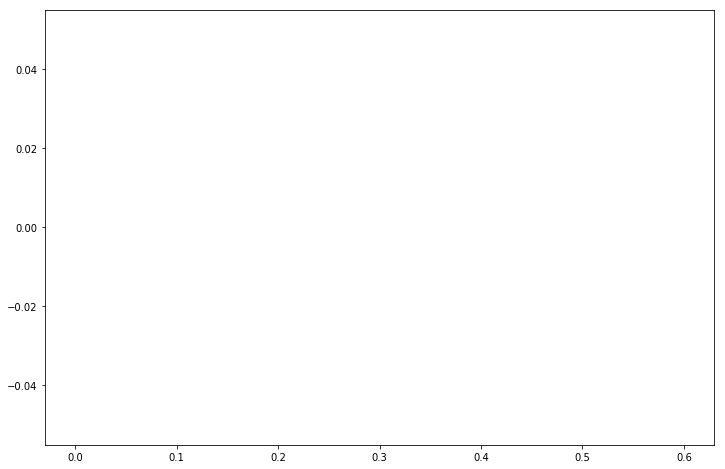

Total samples = 2
Iteration 5 SNR= 3 MEAN_ERR= 1.0100965022983899 MEDIAN_ERR= 1.0100965022983899
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899]


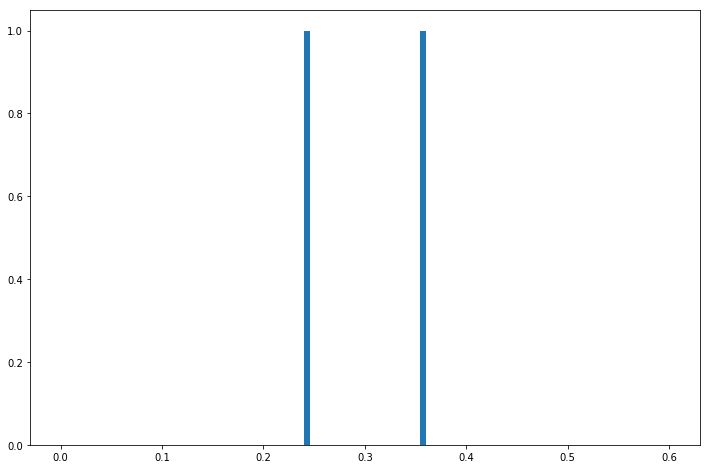

Total samples = 2
Iteration 6 SNR= 3 MEAN_ERR= 0.3003479011392206 MEDIAN_ERR= 0.3003479011392206
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206]


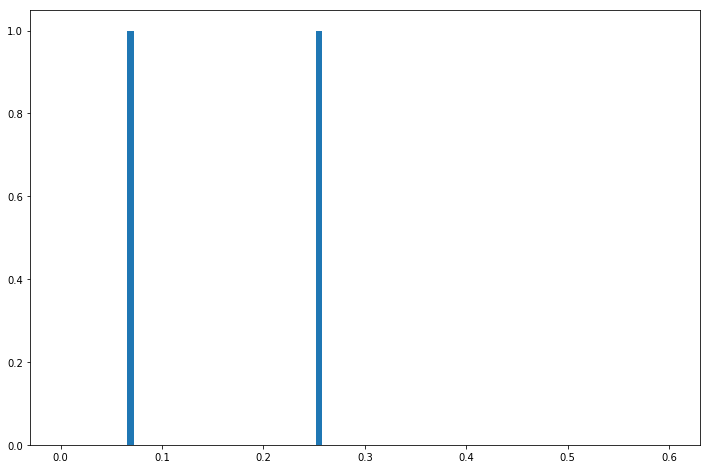

Total samples = 2
Iteration 7 SNR= 3 MEAN_ERR= 0.16003242522313776 MEDIAN_ERR= 0.16003242522313776
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776]


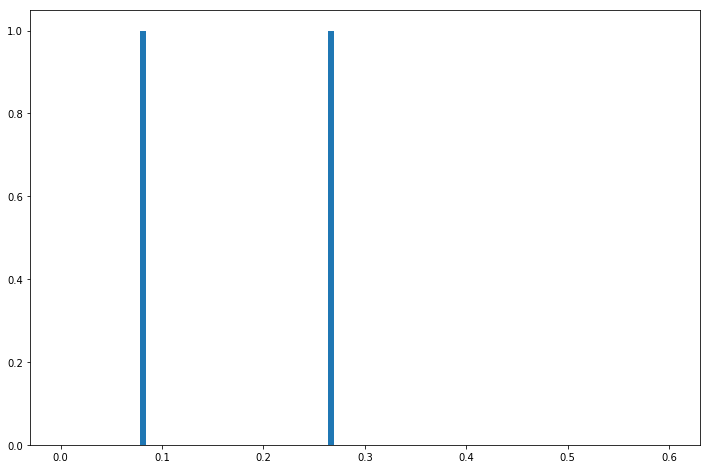

Total samples = 2
Iteration 8 SNR= 3 MEAN_ERR= 0.17409888362616727 MEDIAN_ERR= 0.17409888362616727
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727]


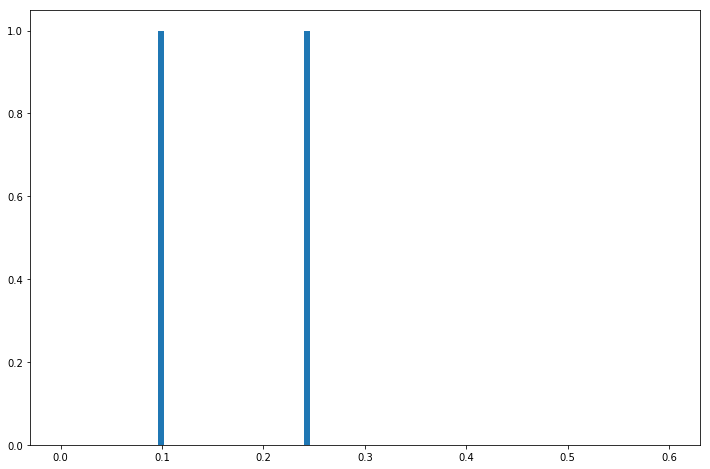

Total samples = 2
Iteration 9 SNR= 3 MEAN_ERR= 0.1709127895516728 MEDIAN_ERR= 0.1709127895516728
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728]


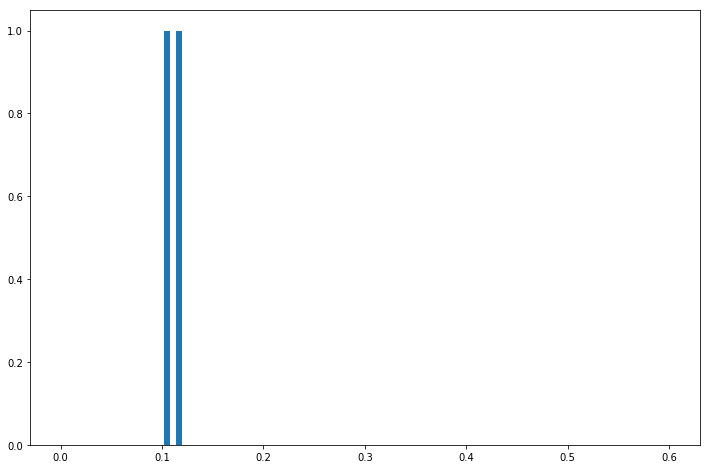

Total samples = 2
Iteration 0 SNR= 4 MEAN_ERR= 0.11141756883496384 MEDIAN_ERR= 0.11141756883496384
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384]


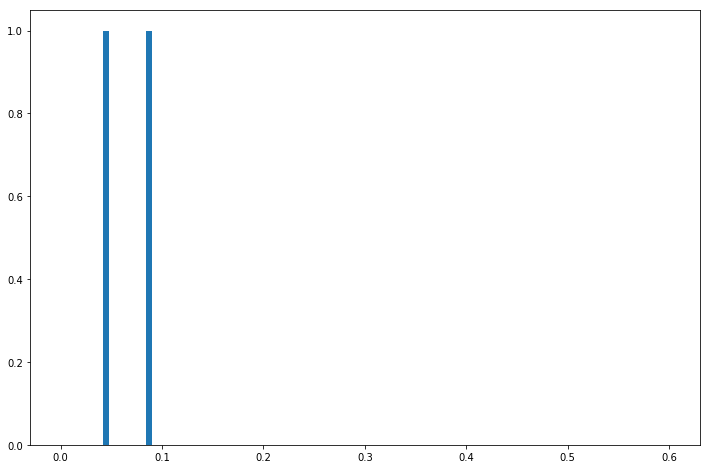

Total samples = 2
Iteration 1 SNR= 4 MEAN_ERR= 0.06853325110042838 MEDIAN_ERR= 0.06853325110042838
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384, 0.06853325110042838]


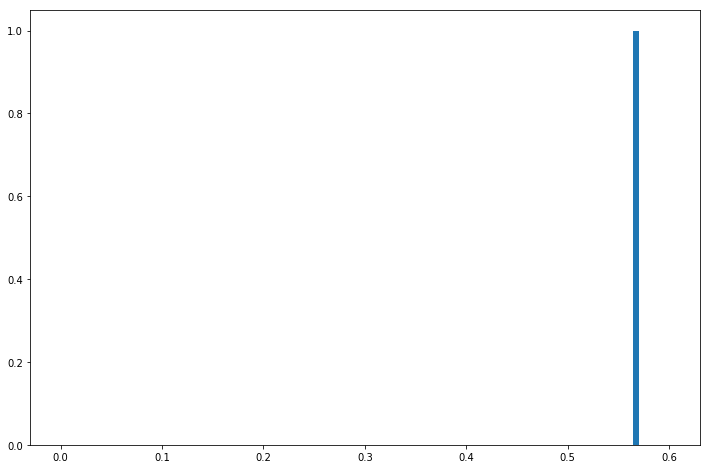

Total samples = 2
Iteration 2 SNR= 4 MEAN_ERR= 0.7716969921913064 MEDIAN_ERR= 0.7716969921913064
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384, 0.06853325110042838, 0.7716969921913064]


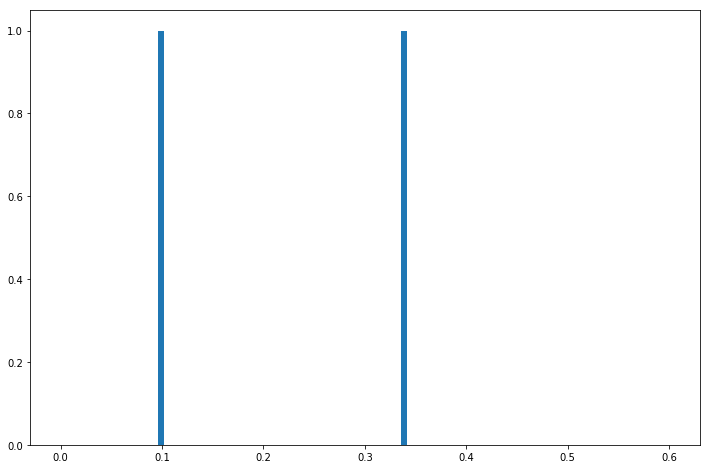

Total samples = 2
Iteration 3 SNR= 4 MEAN_ERR= 0.21952513961243172 MEDIAN_ERR= 0.21952513961243172
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384, 0.06853325110042838, 0.7716969921913064, 0.219525139612431

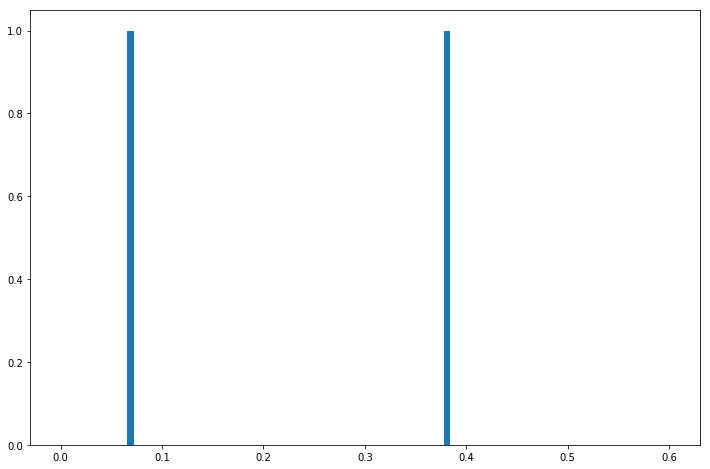

Total samples = 2
Iteration 4 SNR= 4 MEAN_ERR= 0.22604815986362214 MEDIAN_ERR= 0.22604815986362214
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384, 0.06853325110042838, 0.7716969921913064, 0.219525139612431

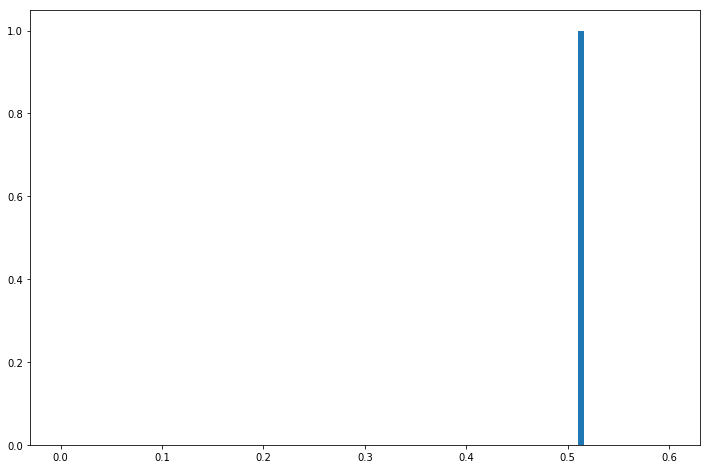

Total samples = 2
Iteration 5 SNR= 4 MEAN_ERR= 0.6512881859288229 MEDIAN_ERR= 0.6512881859288229
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384, 0.06853325110042838, 0.7716969921913064, 0.21952513961243172

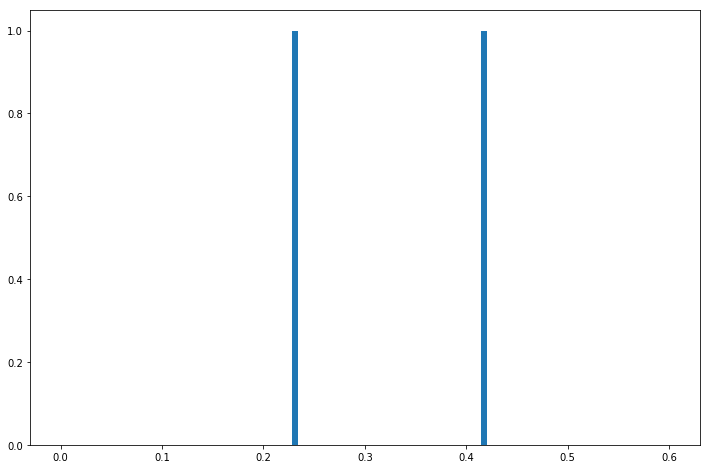

Total samples = 2
Iteration 6 SNR= 4 MEAN_ERR= 0.3240411900848883 MEDIAN_ERR= 0.3240411900848883
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384, 0.06853325110042838, 0.7716969921913064, 0.21952513961243172

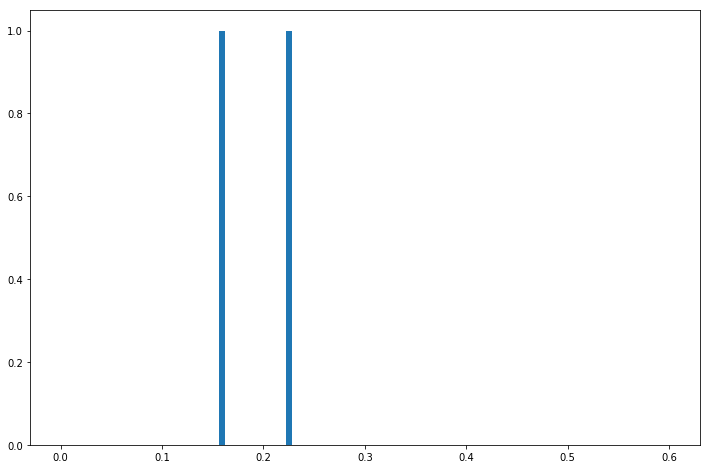

Total samples = 2
Iteration 7 SNR= 4 MEAN_ERR= 0.192830704991925 MEDIAN_ERR= 0.192830704991925
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384, 0.06853325110042838, 0.7716969921913064, 0.21952513961243172, 

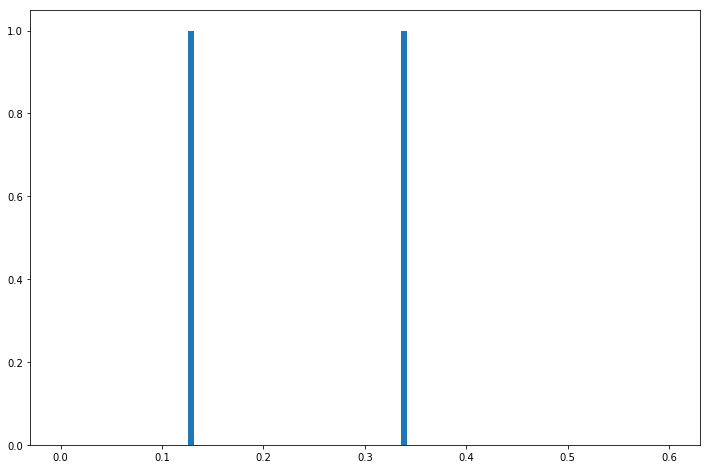

Total samples = 2
Iteration 8 SNR= 4 MEAN_ERR= 0.23589054853214858 MEDIAN_ERR= 0.23589054853214858
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384, 0.06853325110042838, 0.7716969921913064, 0.219525139612431

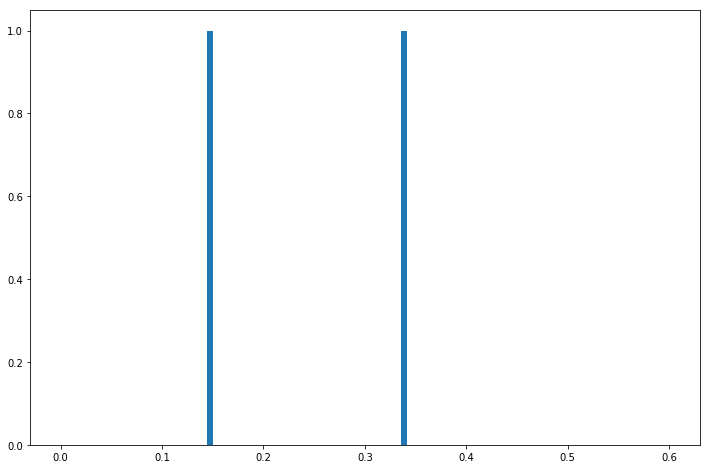

Total samples = 2
Iteration 9 SNR= 4 MEAN_ERR= 0.2429932407335702 MEDIAN_ERR= 0.2429932407335702
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384, 0.06853325110042838, 0.7716969921913064, 0.21952513961243172

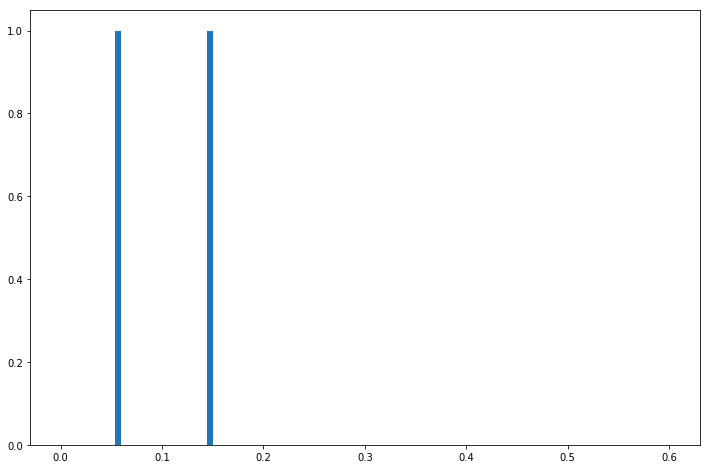

Total samples = 2
Iteration 0 SNR= 0 MEAN_ERR= 0.10106263857284258 MEDIAN_ERR= 0.10106263857284258
[0.10106263857284258]


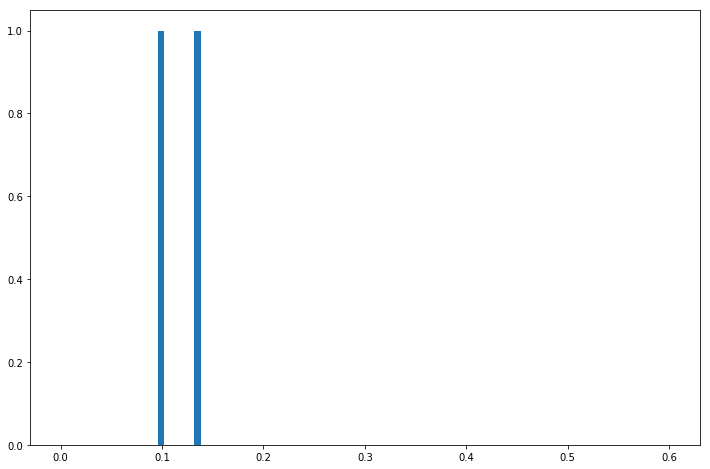

Total samples = 2
Iteration 1 SNR= 0 MEAN_ERR= 0.11729435119386444 MEDIAN_ERR= 0.11729435119386444
[0.10106263857284258, 0.11729435119386444]


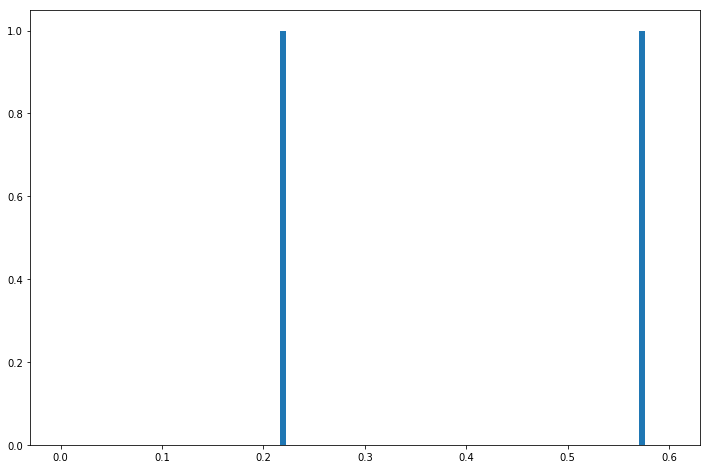

Total samples = 2
Iteration 2 SNR= 0 MEAN_ERR= 0.3980242945448038 MEDIAN_ERR= 0.3980242945448038
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038]


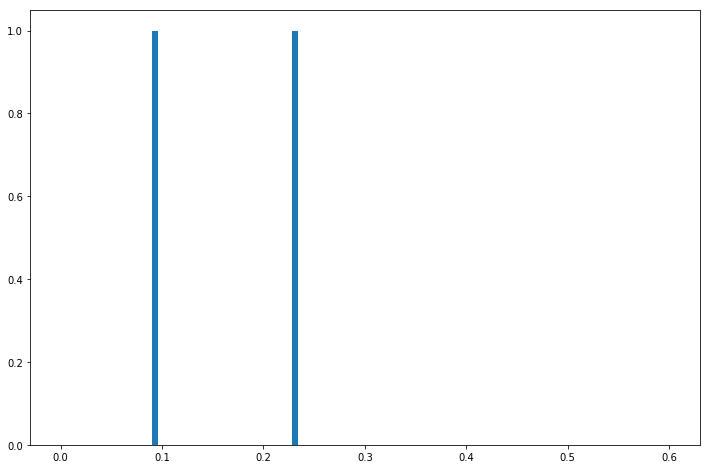

Total samples = 2
Iteration 3 SNR= 0 MEAN_ERR= 0.16124785129296867 MEDIAN_ERR= 0.16124785129296867
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867]


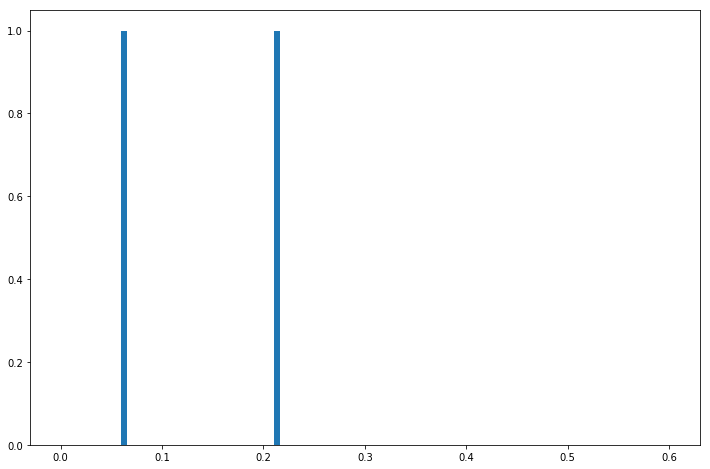

Total samples = 2
Iteration 4 SNR= 0 MEAN_ERR= 0.13682524357315362 MEDIAN_ERR= 0.13682524357315362
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362]


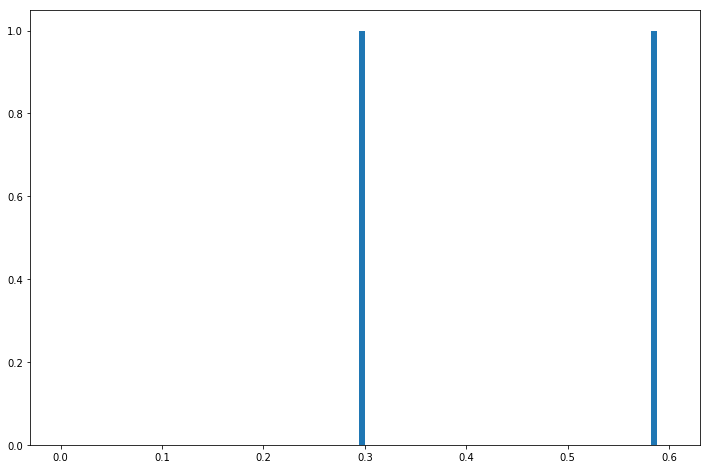

Total samples = 2
Iteration 5 SNR= 0 MEAN_ERR= 0.44071808964659265 MEDIAN_ERR= 0.44071808964659265
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265]


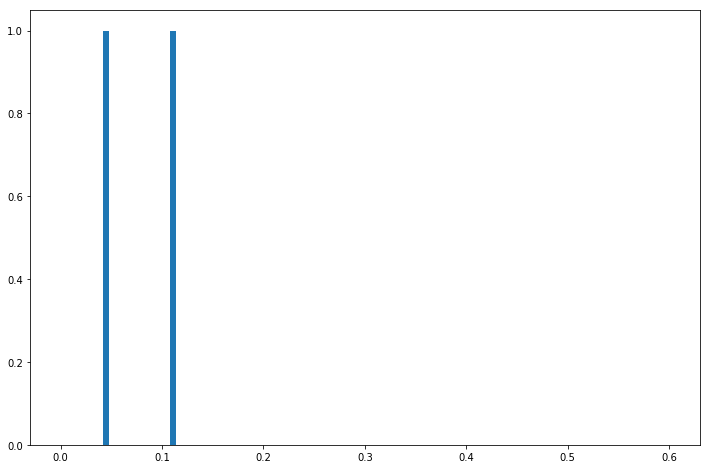

Total samples = 2
Iteration 6 SNR= 0 MEAN_ERR= 0.0780796123975655 MEDIAN_ERR= 0.0780796123975655
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655]


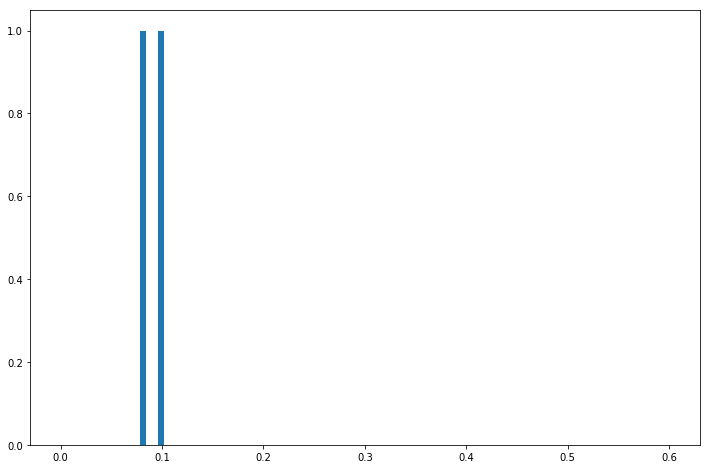

Total samples = 2
Iteration 7 SNR= 0 MEAN_ERR= 0.09236092519637118 MEDIAN_ERR= 0.09236092519637118
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118]


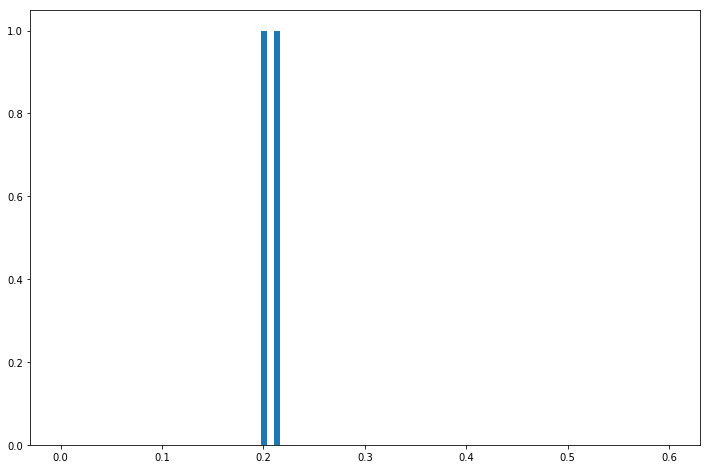

Total samples = 2
Iteration 8 SNR= 0 MEAN_ERR= 0.20711364494306927 MEDIAN_ERR= 0.20711364494306927
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927]


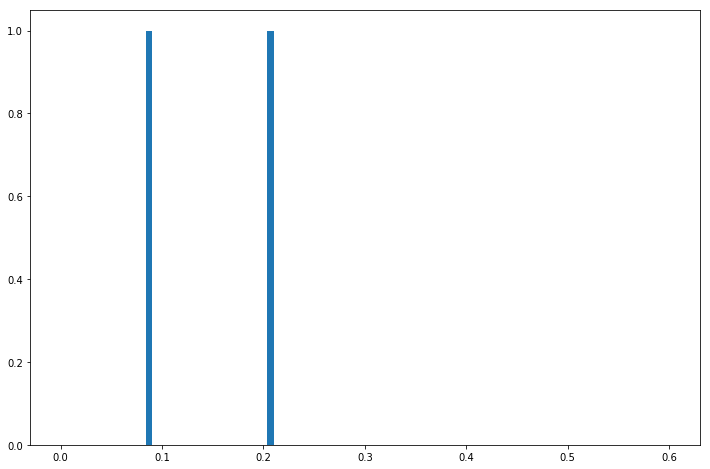

Total samples = 2
Iteration 9 SNR= 0 MEAN_ERR= 0.14726491818779022 MEDIAN_ERR= 0.14726491818779022
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022]


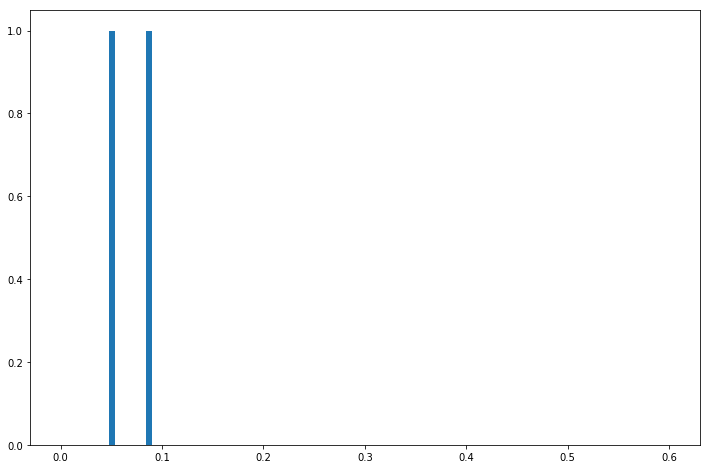

Total samples = 2
Iteration 0 SNR= 1 MEAN_ERR= 0.06844930013322181 MEDIAN_ERR= 0.06844930013322181
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181]


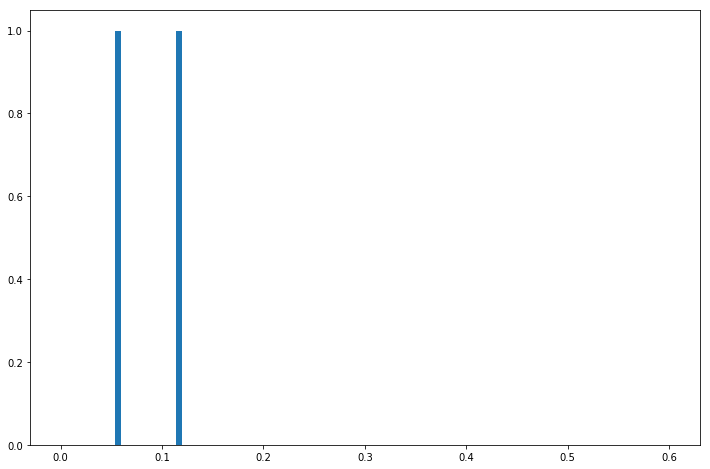

Total samples = 2
Iteration 1 SNR= 1 MEAN_ERR= 0.08832485983101171 MEDIAN_ERR= 0.08832485983101171
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171]


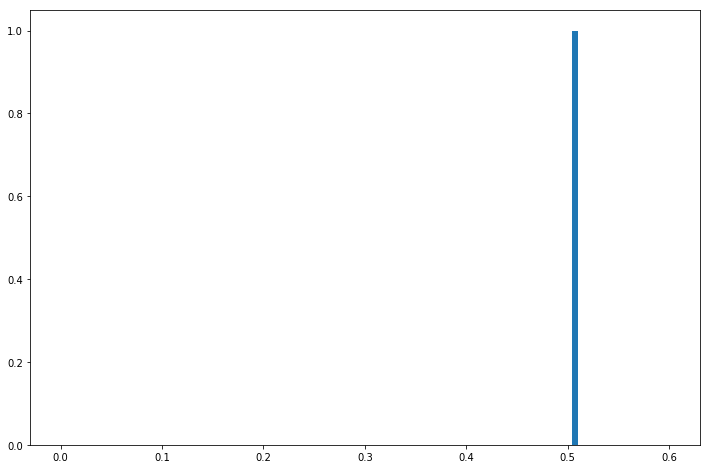

Total samples = 2
Iteration 2 SNR= 1 MEAN_ERR= 0.733366620299108 MEDIAN_ERR= 0.733366620299108
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108]


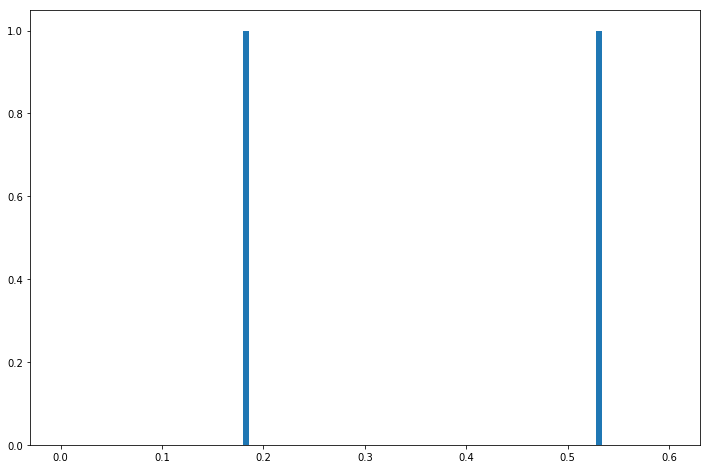

Total samples = 2
Iteration 3 SNR= 1 MEAN_ERR= 0.3578281738505456 MEDIAN_ERR= 0.3578281738505456
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456]


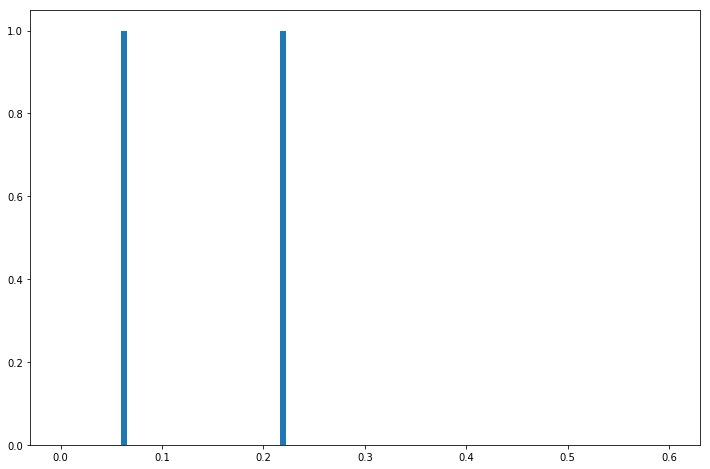

Total samples = 2
Iteration 4 SNR= 1 MEAN_ERR= 0.14328990014011167 MEDIAN_ERR= 0.14328990014011167
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167]


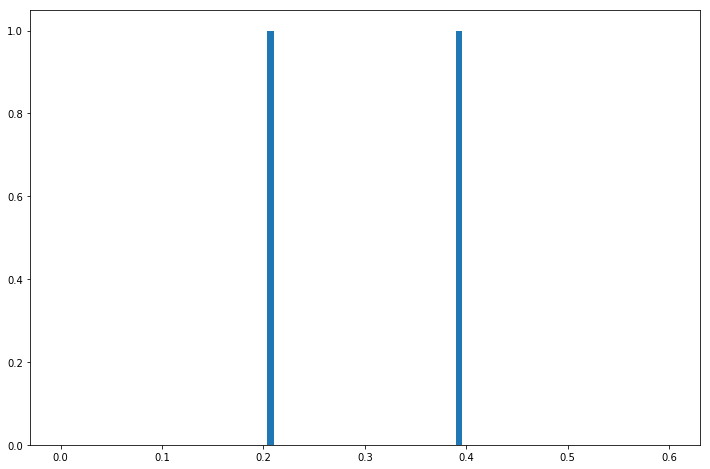

Total samples = 2
Iteration 5 SNR= 1 MEAN_ERR= 0.2996861234810617 MEDIAN_ERR= 0.2996861234810617
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617]


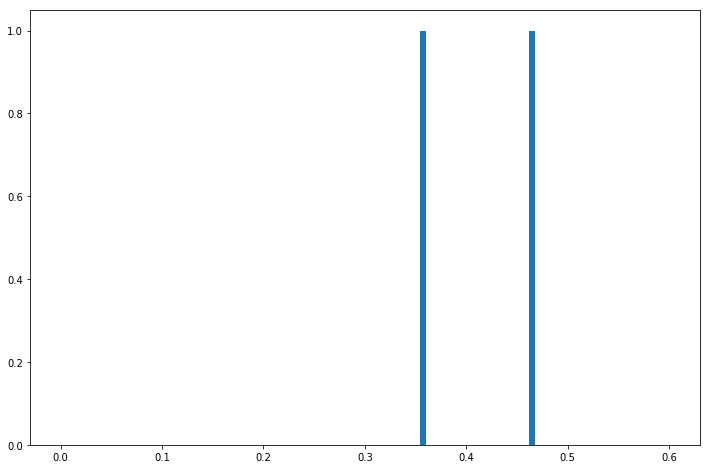

Total samples = 2
Iteration 6 SNR= 1 MEAN_ERR= 0.41072922411034174 MEDIAN_ERR= 0.41072922411034174
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174]


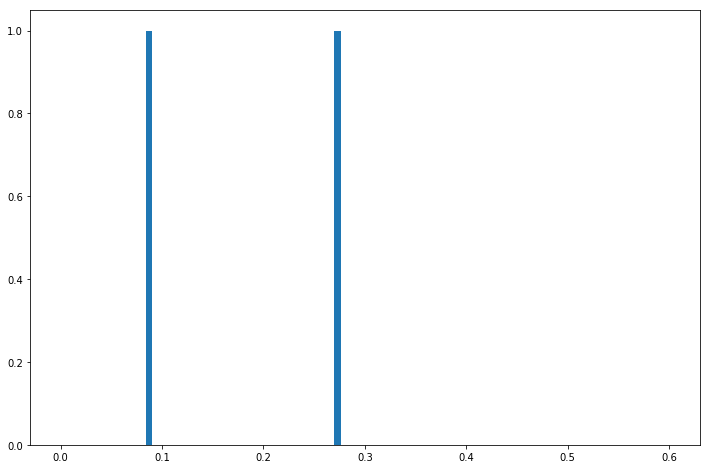

Total samples = 2
Iteration 7 SNR= 1 MEAN_ERR= 0.17853147634330668 MEDIAN_ERR= 0.17853147634330668
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668]


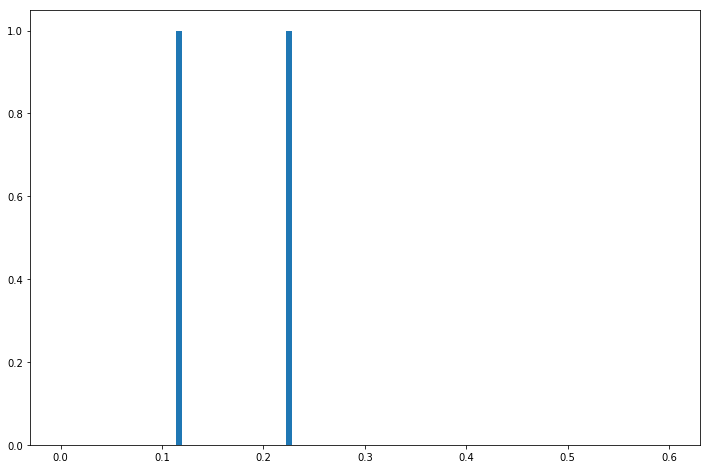

Total samples = 2
Iteration 8 SNR= 1 MEAN_ERR= 0.1714512935761042 MEDIAN_ERR= 0.1714512935761042
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042]


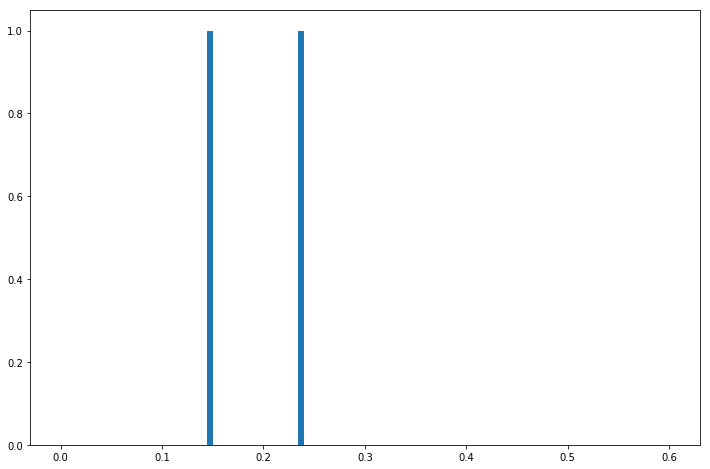

Total samples = 2
Iteration 9 SNR= 1 MEAN_ERR= 0.18995946354295323 MEDIAN_ERR= 0.18995946354295323
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323]


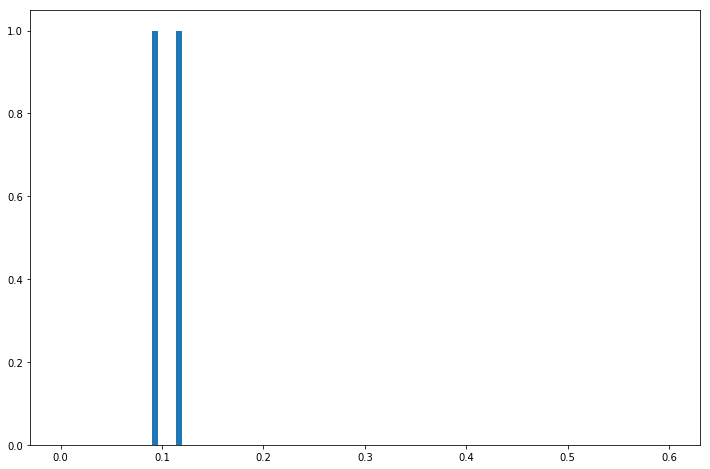

Total samples = 2
Iteration 0 SNR= 2 MEAN_ERR= 0.10456895021348107 MEDIAN_ERR= 0.10456895021348107
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107]


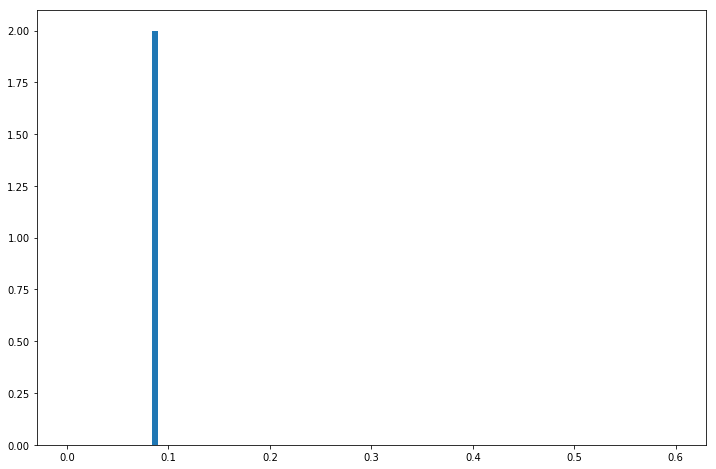

Total samples = 2
Iteration 1 SNR= 2 MEAN_ERR= 0.0862591984753549 MEDIAN_ERR= 0.0862591984753549
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549]


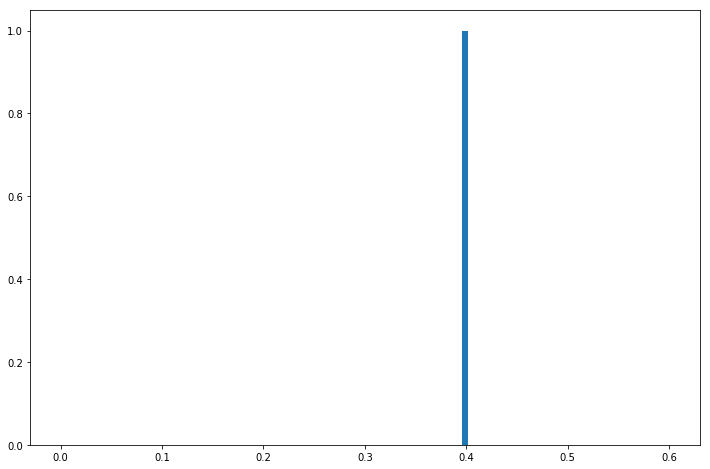

Total samples = 2
Iteration 2 SNR= 2 MEAN_ERR= 0.6286184364696512 MEDIAN_ERR= 0.6286184364696512
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512]


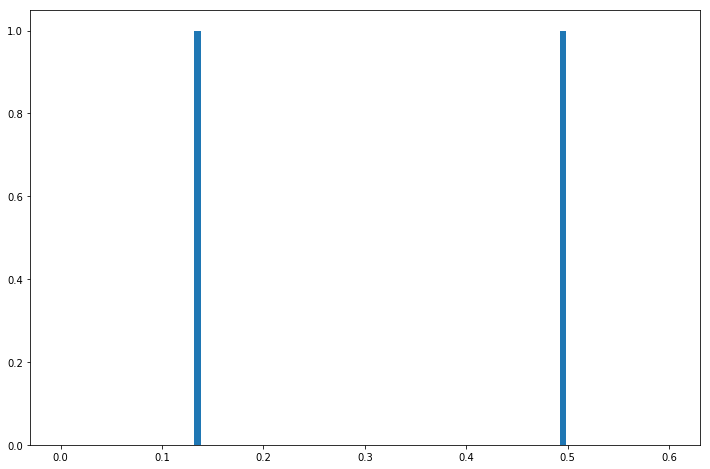

Total samples = 2
Iteration 3 SNR= 2 MEAN_ERR= 0.3150419217152967 MEDIAN_ERR= 0.3150419217152967
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967]


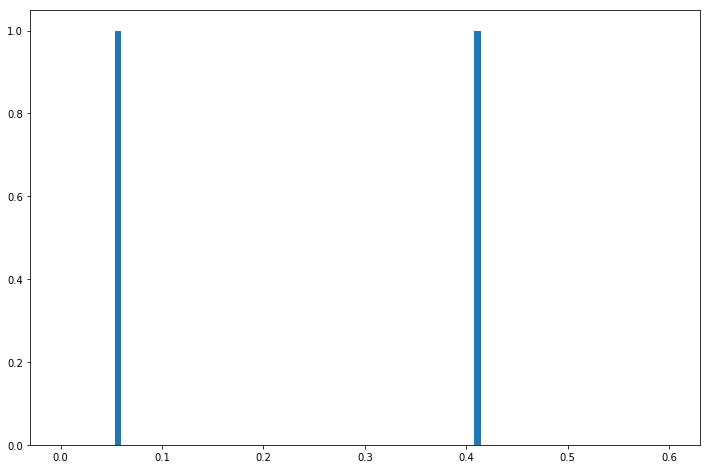

Total samples = 2
Iteration 4 SNR= 2 MEAN_ERR= 0.23468871082824835 MEDIAN_ERR= 0.23468871082824835
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835]


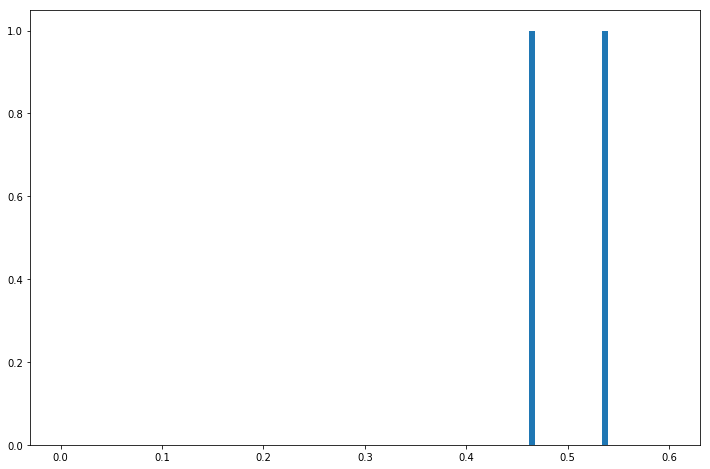

Total samples = 2
Iteration 5 SNR= 2 MEAN_ERR= 0.5000534980349756 MEDIAN_ERR= 0.5000534980349756
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756]


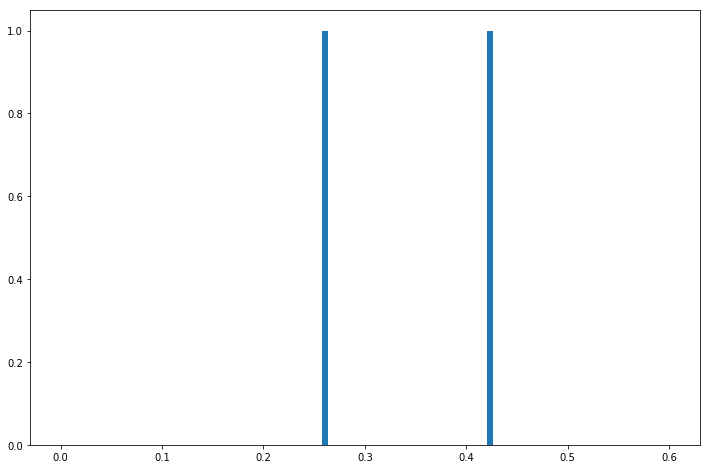

Total samples = 2
Iteration 6 SNR= 2 MEAN_ERR= 0.3418074080836877 MEDIAN_ERR= 0.3418074080836877
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877]


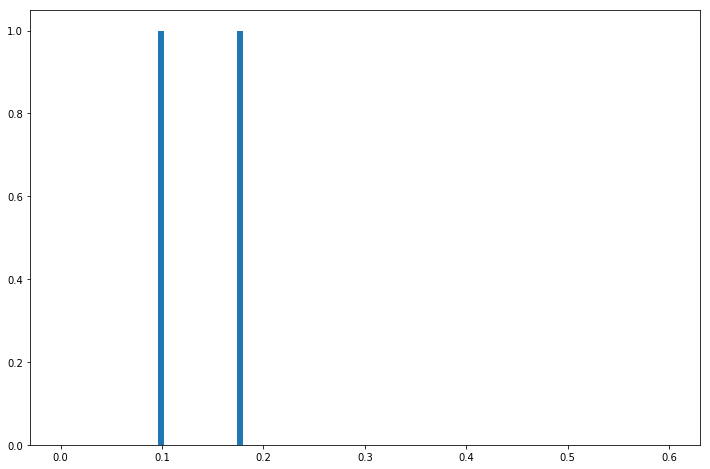

Total samples = 2
Iteration 7 SNR= 2 MEAN_ERR= 0.13925952077986636 MEDIAN_ERR= 0.13925952077986636
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636]


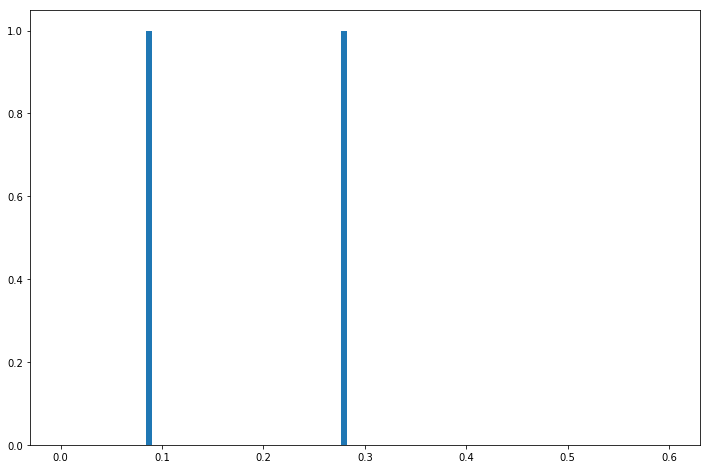

Total samples = 2
Iteration 8 SNR= 2 MEAN_ERR= 0.18268270478464319 MEDIAN_ERR= 0.18268270478464319
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319]


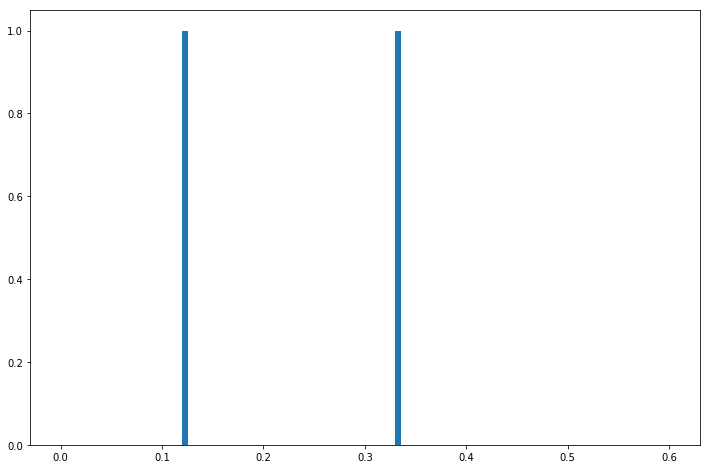

Total samples = 2
Iteration 9 SNR= 2 MEAN_ERR= 0.2277137020332186 MEDIAN_ERR= 0.2277137020332186
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186]


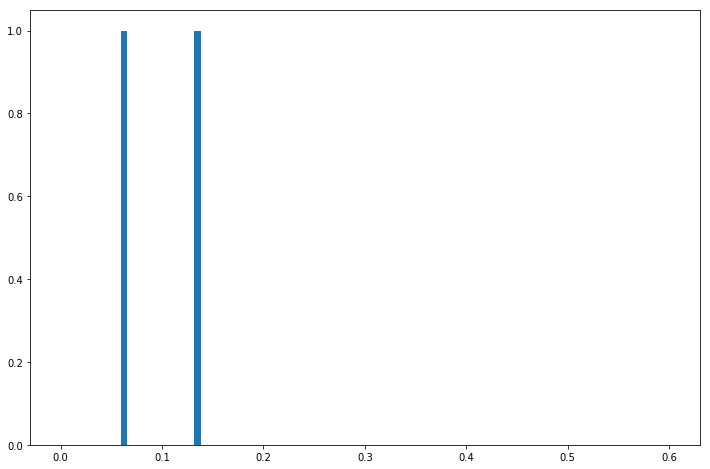

Total samples = 2
Iteration 0 SNR= 3 MEAN_ERR= 0.09982195460650325 MEDIAN_ERR= 0.09982195460650325
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325]


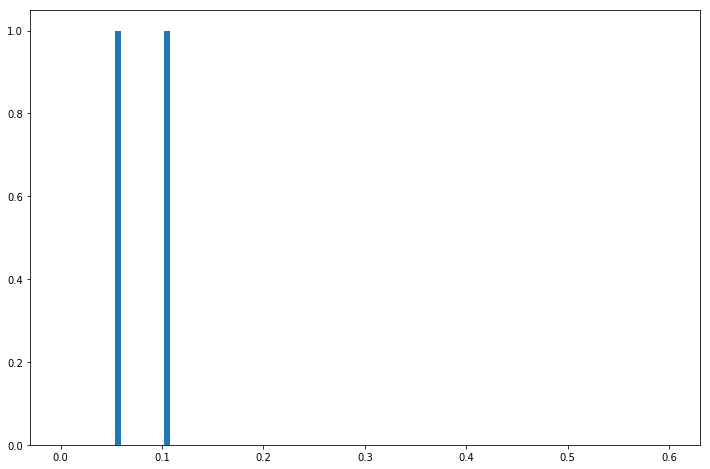

Total samples = 2
Iteration 1 SNR= 3 MEAN_ERR= 0.07887321202931827 MEDIAN_ERR= 0.07887321202931827
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827]


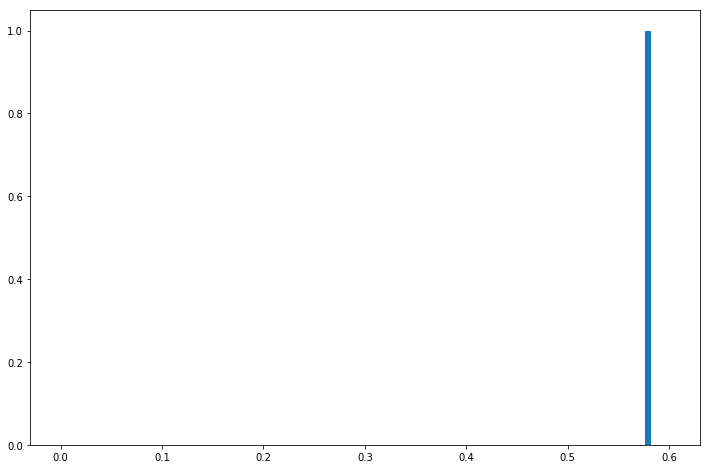

Total samples = 2
Iteration 2 SNR= 3 MEAN_ERR= 0.7898498541422374 MEDIAN_ERR= 0.7898498541422374
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374]


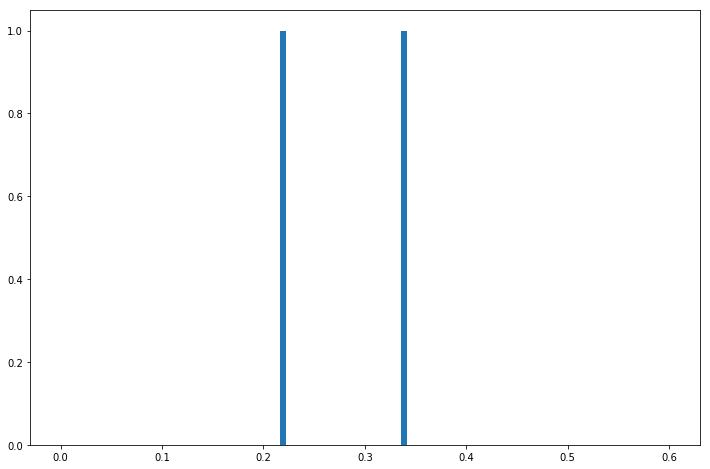

Total samples = 2
Iteration 3 SNR= 3 MEAN_ERR= 0.276819226599406 MEDIAN_ERR= 0.276819226599406
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406]


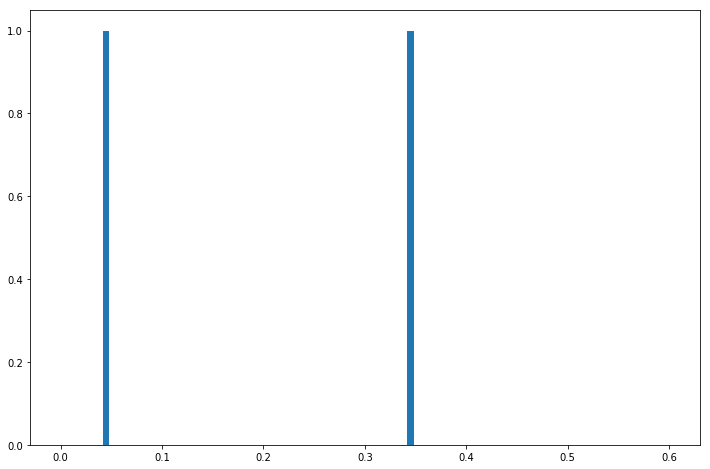

Total samples = 2
Iteration 4 SNR= 3 MEAN_ERR= 0.19484338741507085 MEDIAN_ERR= 0.19484338741507085
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085]


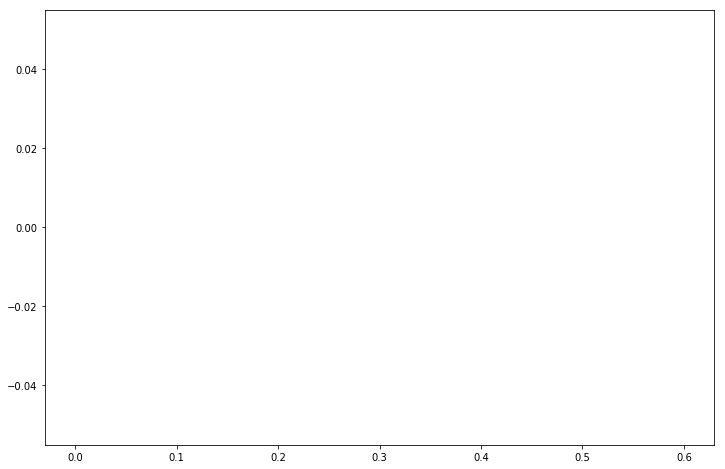

Total samples = 2
Iteration 5 SNR= 3 MEAN_ERR= 1.0100965022983899 MEDIAN_ERR= 1.0100965022983899
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899]


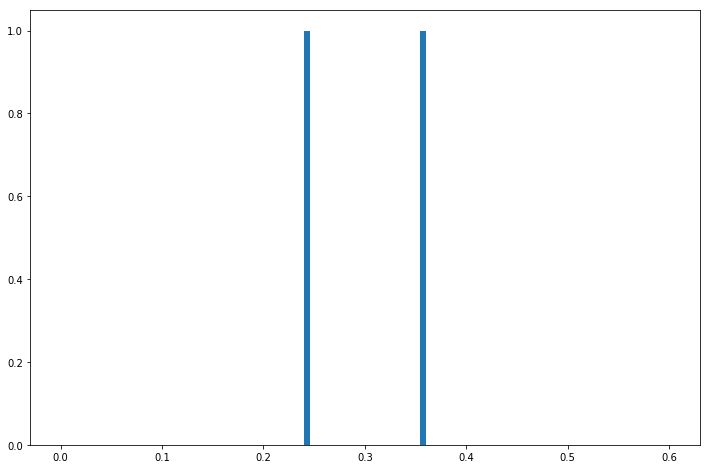

Total samples = 2
Iteration 6 SNR= 3 MEAN_ERR= 0.3003479011392206 MEDIAN_ERR= 0.3003479011392206
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206]


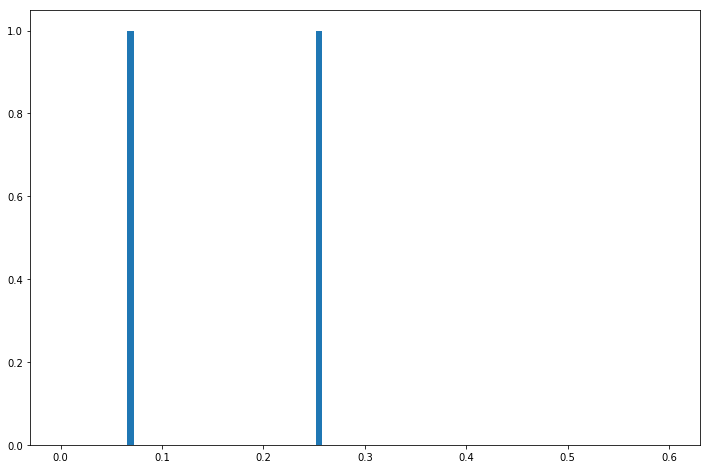

Total samples = 2
Iteration 7 SNR= 3 MEAN_ERR= 0.16003242522313776 MEDIAN_ERR= 0.16003242522313776
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776]


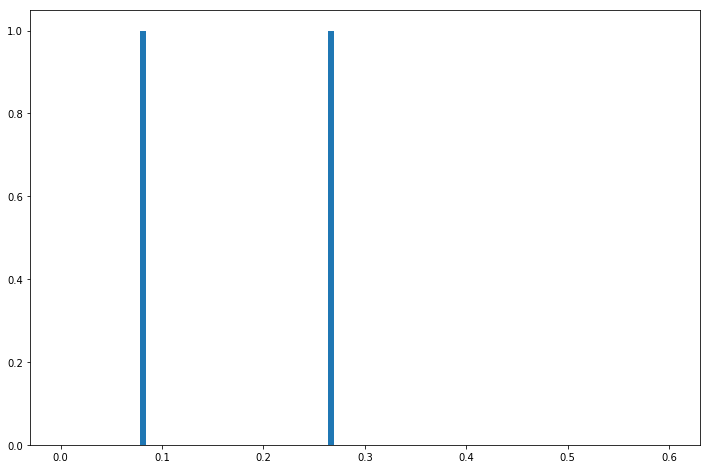

Total samples = 2
Iteration 8 SNR= 3 MEAN_ERR= 0.17409888362616727 MEDIAN_ERR= 0.17409888362616727
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727]


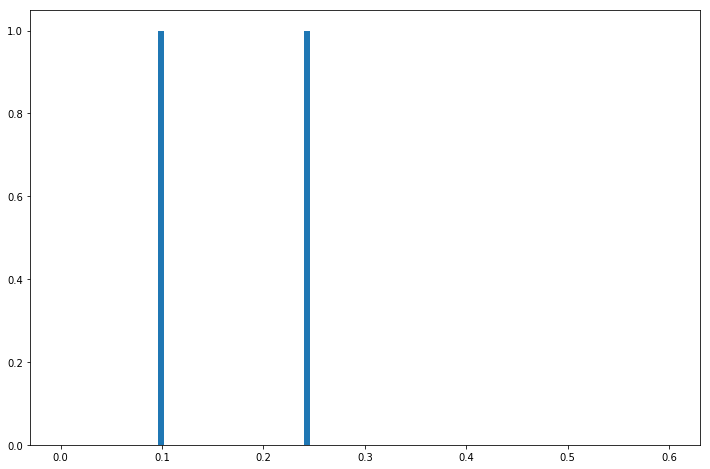

Total samples = 2
Iteration 9 SNR= 3 MEAN_ERR= 0.1709127895516728 MEDIAN_ERR= 0.1709127895516728
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728]


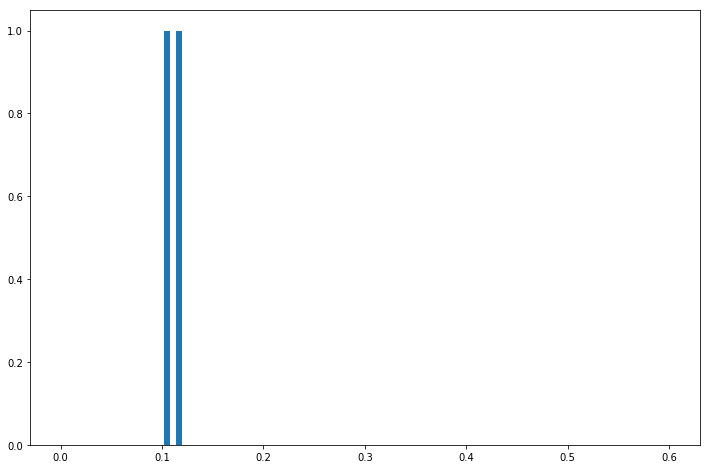

Total samples = 2
Iteration 0 SNR= 4 MEAN_ERR= 0.11141756883496384 MEDIAN_ERR= 0.11141756883496384
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384]


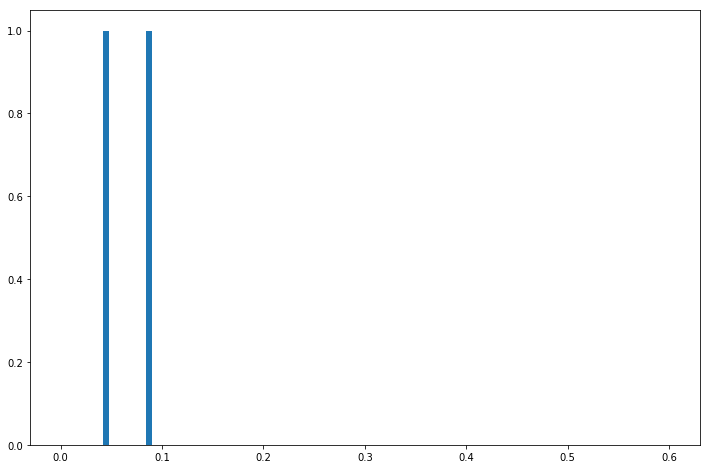

Total samples = 2
Iteration 1 SNR= 4 MEAN_ERR= 0.06853325110042838 MEDIAN_ERR= 0.06853325110042838
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384, 0.06853325110042838]


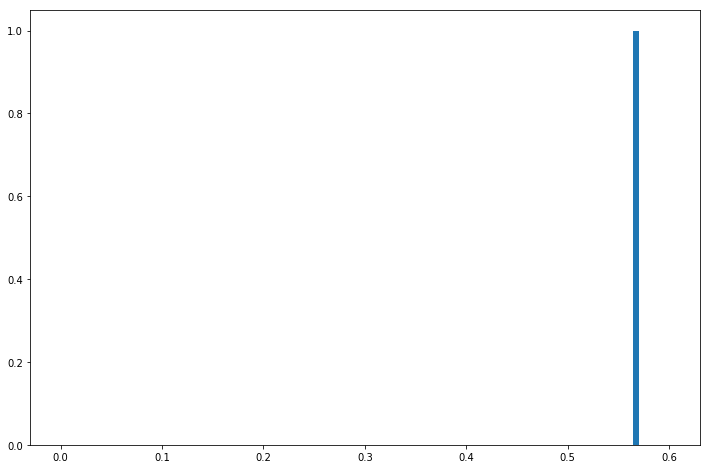

Total samples = 2
Iteration 2 SNR= 4 MEAN_ERR= 0.7716969921913064 MEDIAN_ERR= 0.7716969921913064
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384, 0.06853325110042838, 0.7716969921913064]


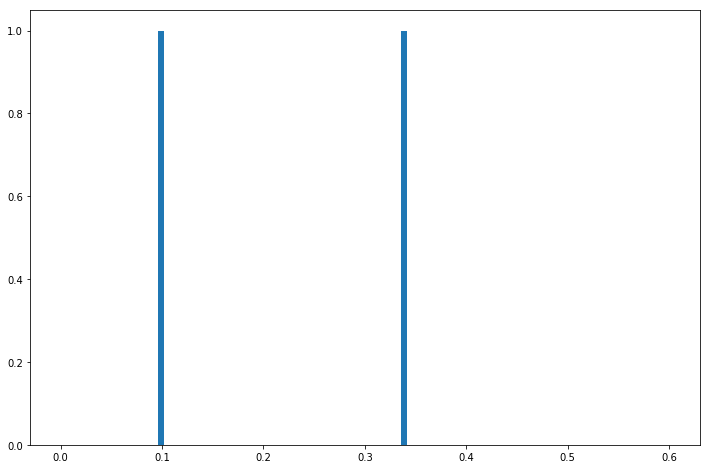

Total samples = 2
Iteration 3 SNR= 4 MEAN_ERR= 0.21952513961243172 MEDIAN_ERR= 0.21952513961243172
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384, 0.06853325110042838, 0.7716969921913064, 0.219525139612431

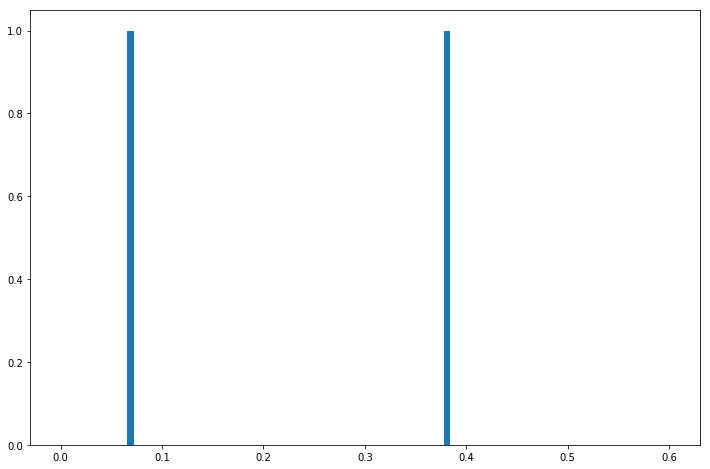

Total samples = 2
Iteration 4 SNR= 4 MEAN_ERR= 0.22604815986362214 MEDIAN_ERR= 0.22604815986362214
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384, 0.06853325110042838, 0.7716969921913064, 0.219525139612431

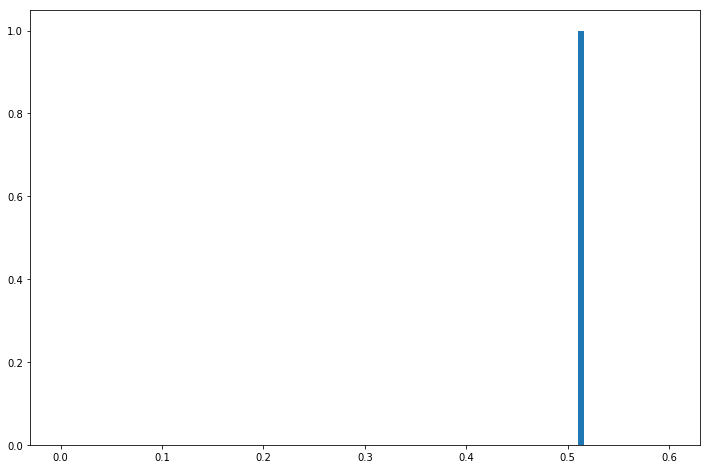

Total samples = 2
Iteration 5 SNR= 4 MEAN_ERR= 0.6512881859288229 MEDIAN_ERR= 0.6512881859288229
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384, 0.06853325110042838, 0.7716969921913064, 0.21952513961243172

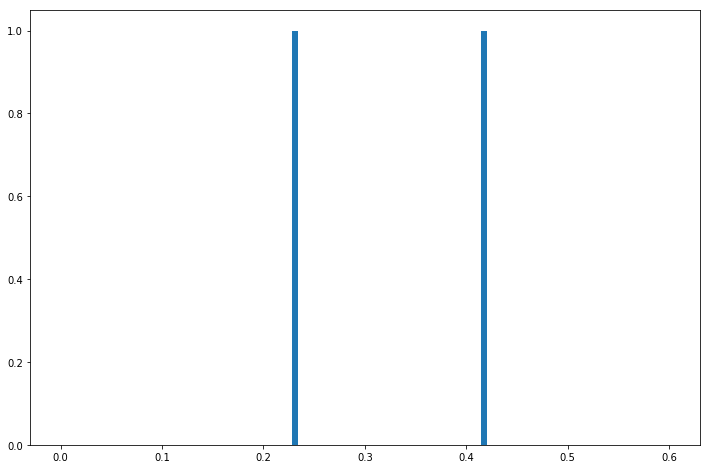

Total samples = 2
Iteration 6 SNR= 4 MEAN_ERR= 0.3240411900848883 MEDIAN_ERR= 0.3240411900848883
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384, 0.06853325110042838, 0.7716969921913064, 0.21952513961243172

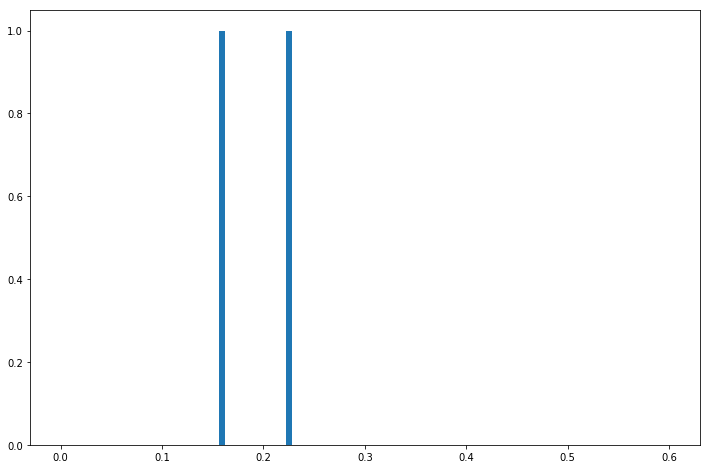

Total samples = 2
Iteration 7 SNR= 4 MEAN_ERR= 0.192830704991925 MEDIAN_ERR= 0.192830704991925
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384, 0.06853325110042838, 0.7716969921913064, 0.21952513961243172, 

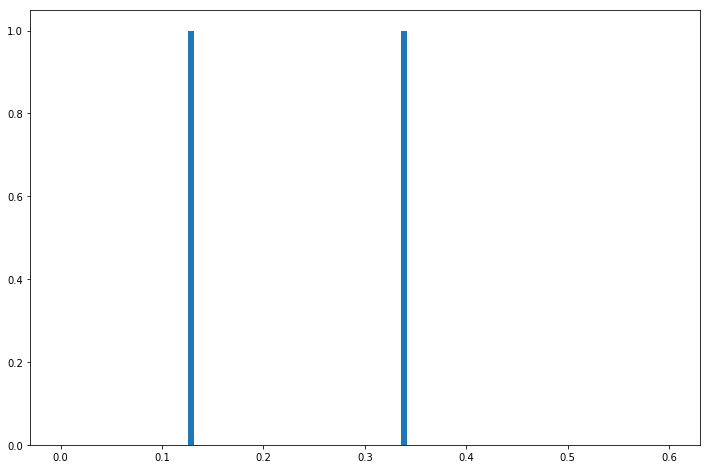

Total samples = 2
Iteration 8 SNR= 4 MEAN_ERR= 0.23589054853214858 MEDIAN_ERR= 0.23589054853214858
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384, 0.06853325110042838, 0.7716969921913064, 0.219525139612431

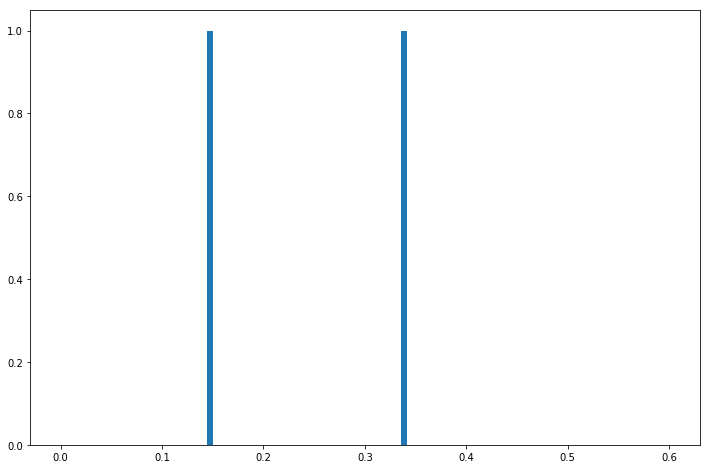

Total samples = 2
Iteration 9 SNR= 4 MEAN_ERR= 0.2429932407335702 MEDIAN_ERR= 0.2429932407335702
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384, 0.06853325110042838, 0.7716969921913064, 0.21952513961243172

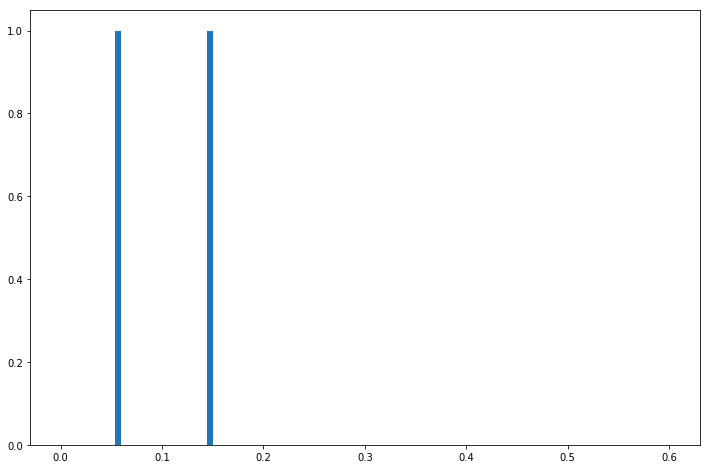

Total samples = 2
Iteration 0 SNR= 0 MEAN_ERR= 0.10106263857284258 MEDIAN_ERR= 0.10106263857284258
[0.10106263857284258]


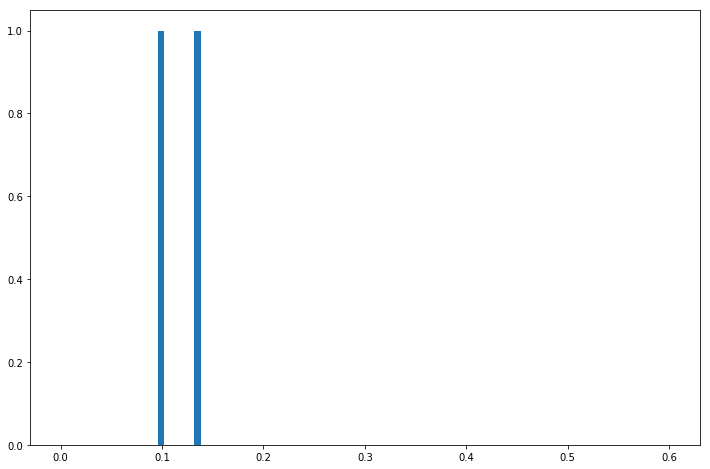

Total samples = 2
Iteration 1 SNR= 0 MEAN_ERR= 0.11729435119386444 MEDIAN_ERR= 0.11729435119386444
[0.10106263857284258, 0.11729435119386444]


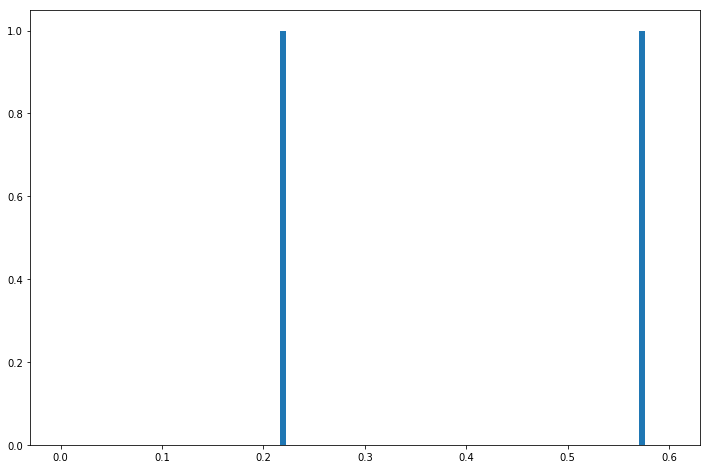

Total samples = 2
Iteration 2 SNR= 0 MEAN_ERR= 0.3980242945448038 MEDIAN_ERR= 0.3980242945448038
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038]


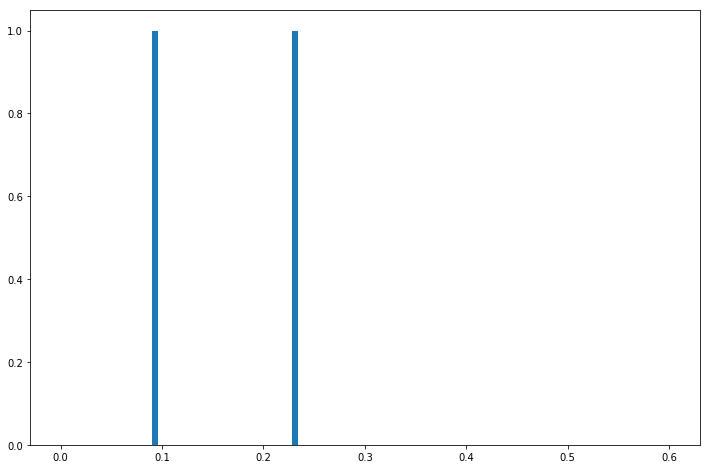

Total samples = 2
Iteration 3 SNR= 0 MEAN_ERR= 0.16124785129296867 MEDIAN_ERR= 0.16124785129296867
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867]


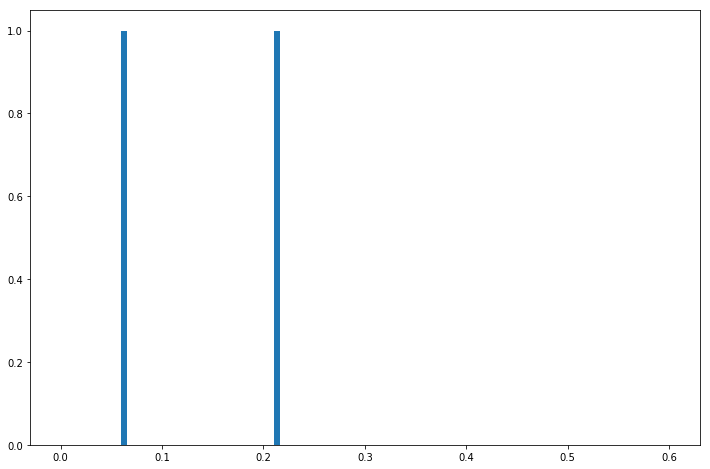

Total samples = 2
Iteration 4 SNR= 0 MEAN_ERR= 0.13682524357315362 MEDIAN_ERR= 0.13682524357315362
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362]


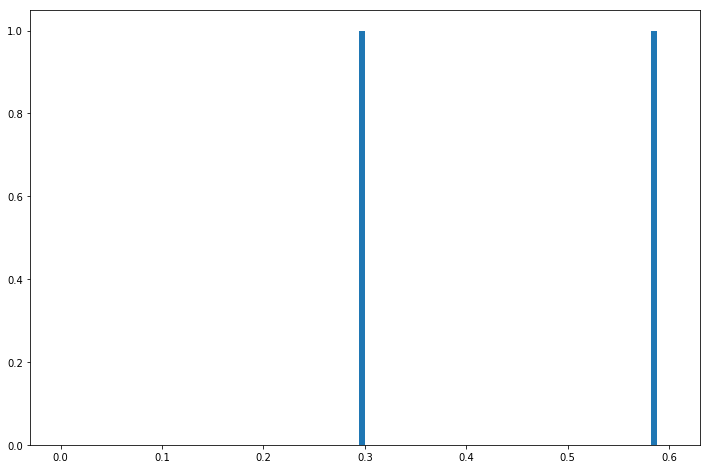

Total samples = 2
Iteration 5 SNR= 0 MEAN_ERR= 0.44071808964659265 MEDIAN_ERR= 0.44071808964659265
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265]


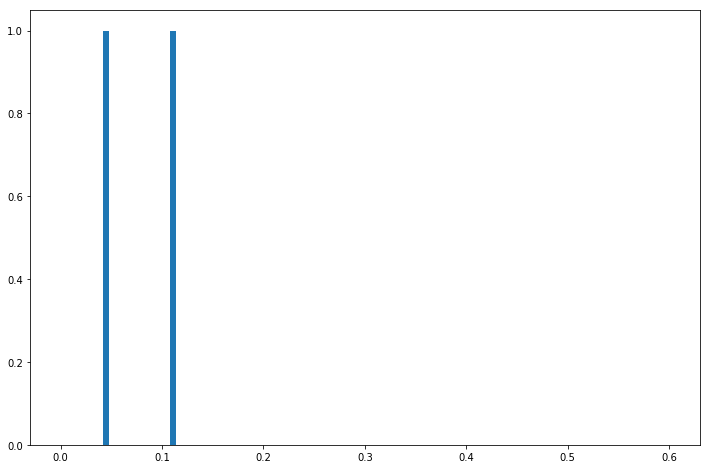

Total samples = 2
Iteration 6 SNR= 0 MEAN_ERR= 0.0780796123975655 MEDIAN_ERR= 0.0780796123975655
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655]


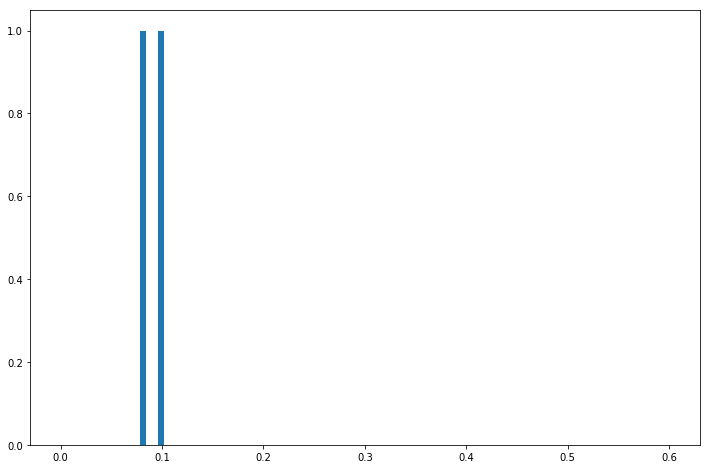

Total samples = 2
Iteration 7 SNR= 0 MEAN_ERR= 0.09236092519637118 MEDIAN_ERR= 0.09236092519637118
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118]


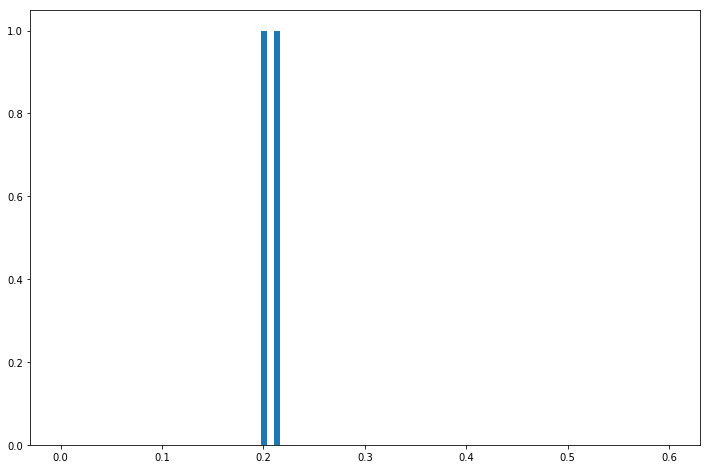

Total samples = 2
Iteration 8 SNR= 0 MEAN_ERR= 0.20711364494306927 MEDIAN_ERR= 0.20711364494306927
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927]


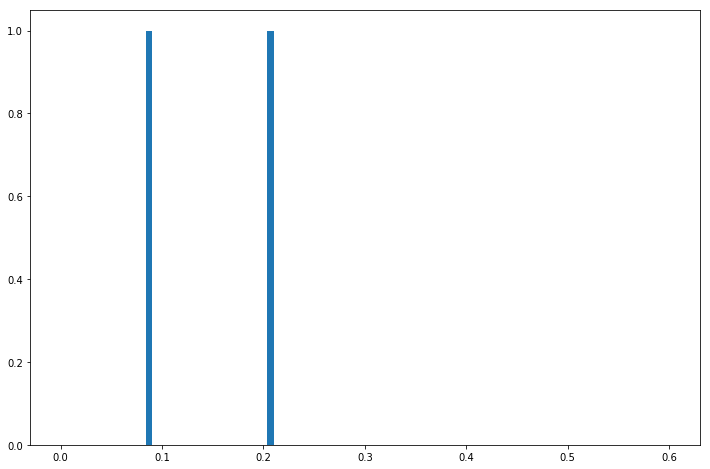

Total samples = 2
Iteration 9 SNR= 0 MEAN_ERR= 0.14726491818779022 MEDIAN_ERR= 0.14726491818779022
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022]


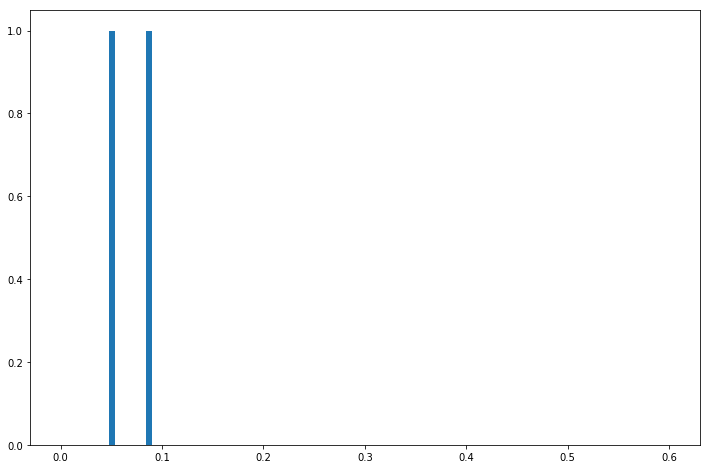

Total samples = 2
Iteration 0 SNR= 1 MEAN_ERR= 0.06844930013322181 MEDIAN_ERR= 0.06844930013322181
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181]


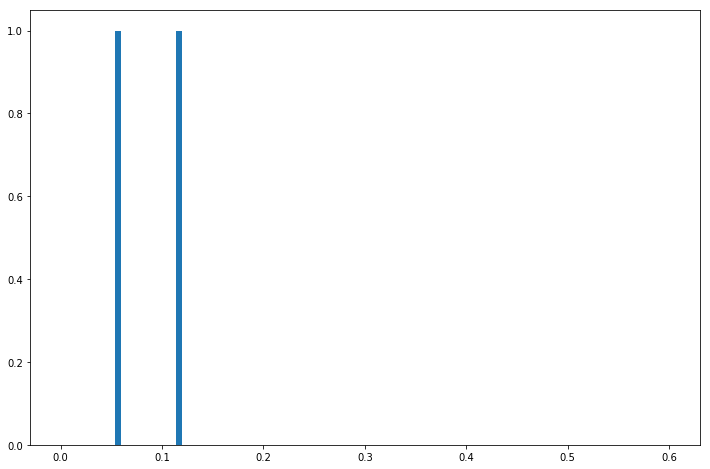

Total samples = 2
Iteration 1 SNR= 1 MEAN_ERR= 0.08832485983101171 MEDIAN_ERR= 0.08832485983101171
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171]


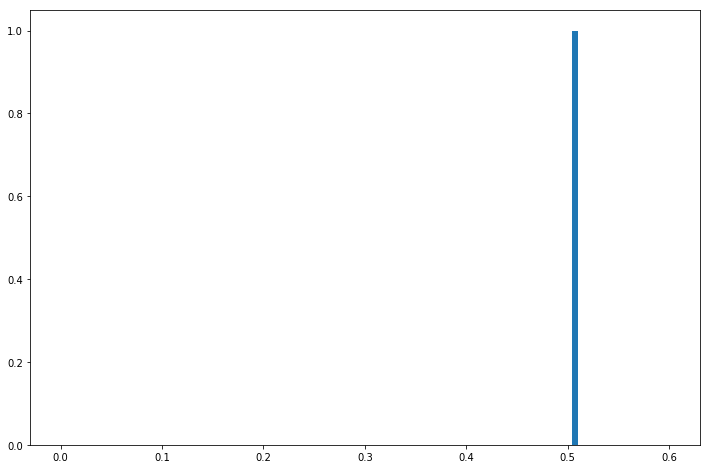

Total samples = 2
Iteration 2 SNR= 1 MEAN_ERR= 0.733366620299108 MEDIAN_ERR= 0.733366620299108
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108]


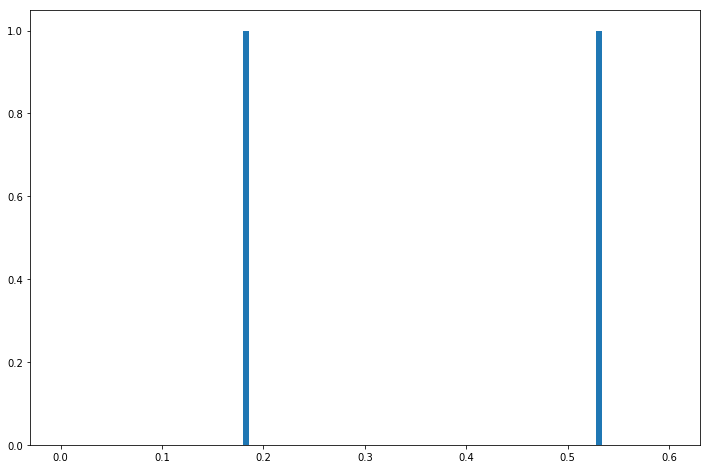

Total samples = 2
Iteration 3 SNR= 1 MEAN_ERR= 0.3578281738505456 MEDIAN_ERR= 0.3578281738505456
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456]


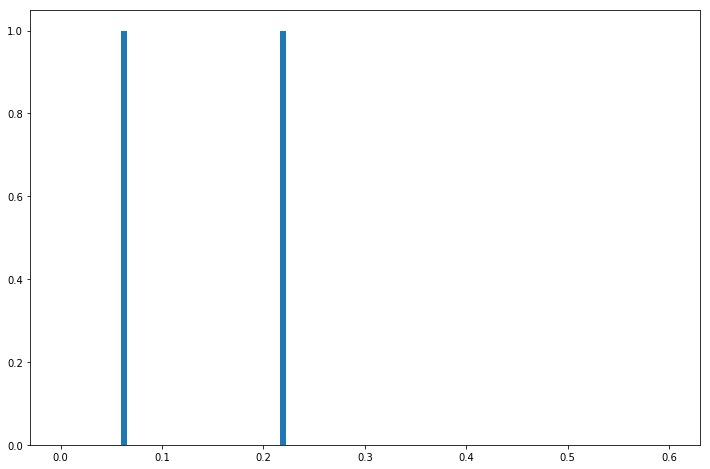

Total samples = 2
Iteration 4 SNR= 1 MEAN_ERR= 0.14328990014011167 MEDIAN_ERR= 0.14328990014011167
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167]


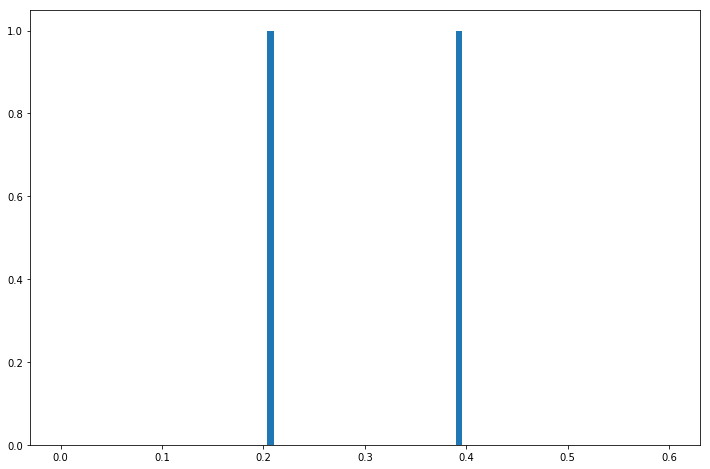

Total samples = 2
Iteration 5 SNR= 1 MEAN_ERR= 0.2996861234810617 MEDIAN_ERR= 0.2996861234810617
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617]


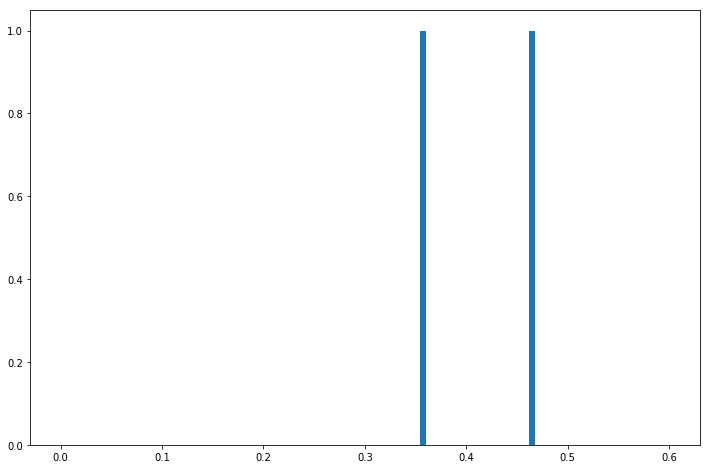

Total samples = 2
Iteration 6 SNR= 1 MEAN_ERR= 0.41072922411034174 MEDIAN_ERR= 0.41072922411034174
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174]


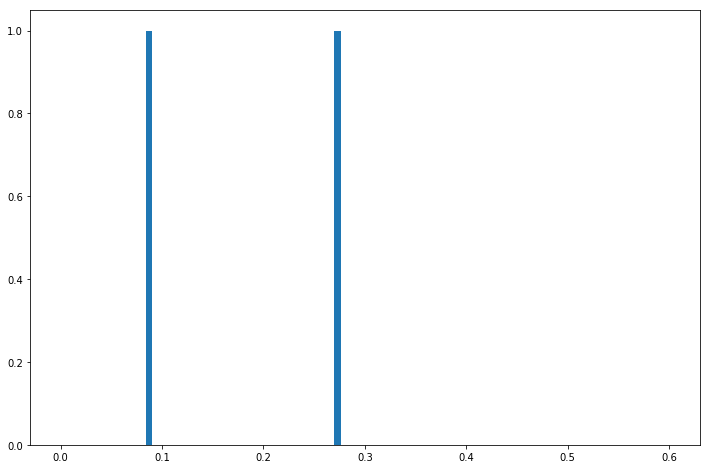

Total samples = 2
Iteration 7 SNR= 1 MEAN_ERR= 0.17853147634330668 MEDIAN_ERR= 0.17853147634330668
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668]


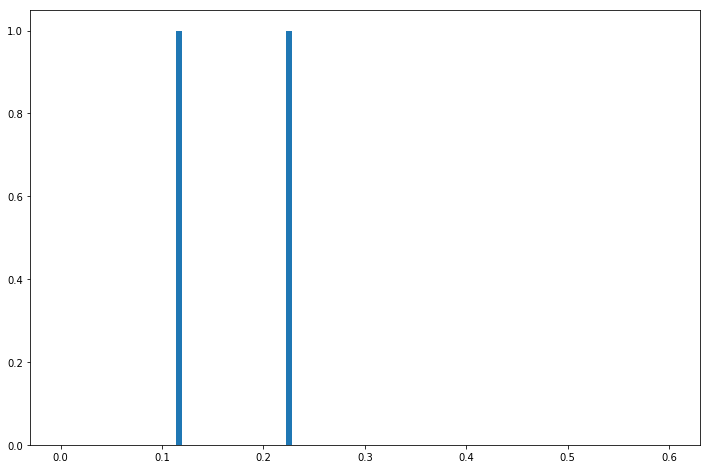

Total samples = 2
Iteration 8 SNR= 1 MEAN_ERR= 0.1714512935761042 MEDIAN_ERR= 0.1714512935761042
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042]


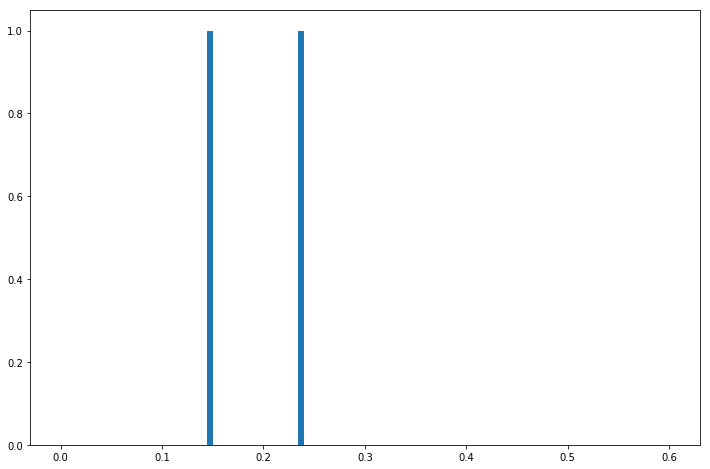

Total samples = 2
Iteration 9 SNR= 1 MEAN_ERR= 0.18995946354295323 MEDIAN_ERR= 0.18995946354295323
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323]


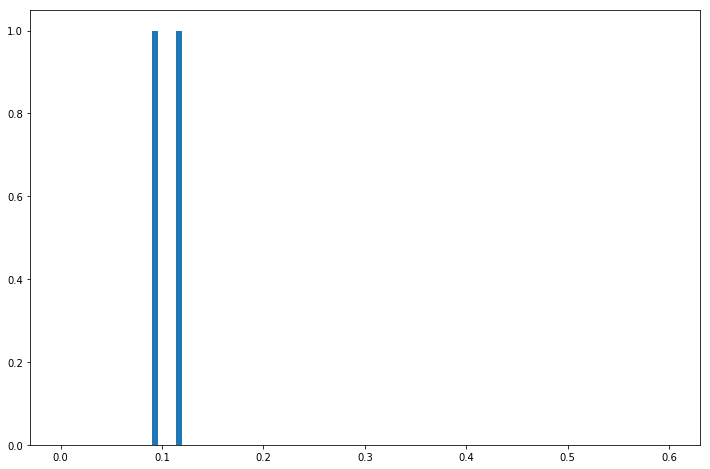

Total samples = 2
Iteration 0 SNR= 2 MEAN_ERR= 0.10456895021348107 MEDIAN_ERR= 0.10456895021348107
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107]


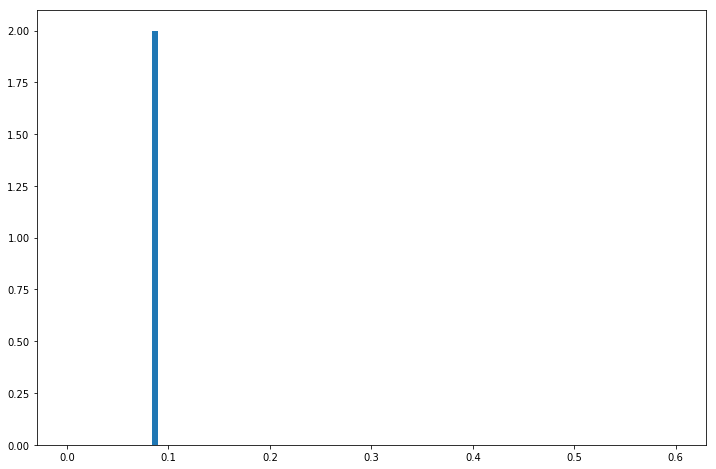

Total samples = 2
Iteration 1 SNR= 2 MEAN_ERR= 0.0862591984753549 MEDIAN_ERR= 0.0862591984753549
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549]


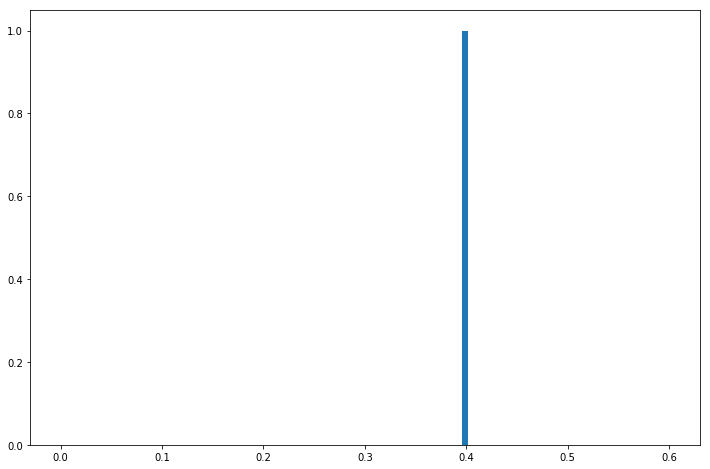

Total samples = 2
Iteration 2 SNR= 2 MEAN_ERR= 0.6286184364696512 MEDIAN_ERR= 0.6286184364696512
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512]


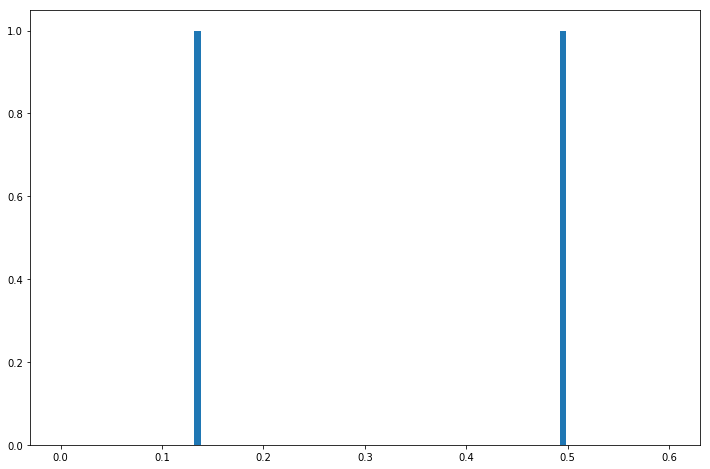

Total samples = 2
Iteration 3 SNR= 2 MEAN_ERR= 0.3150419217152967 MEDIAN_ERR= 0.3150419217152967
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967]


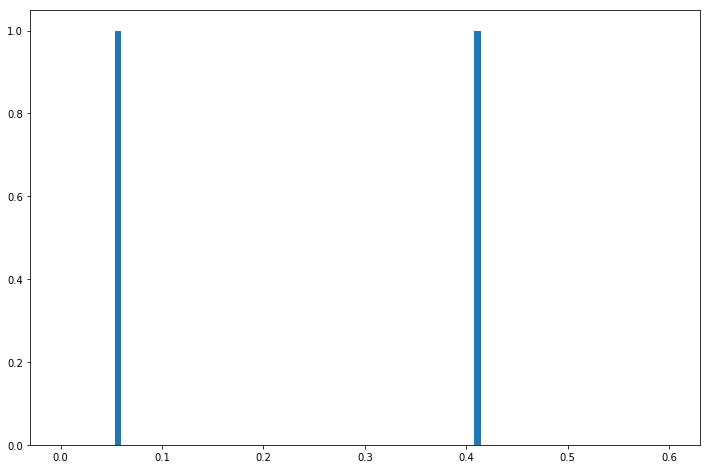

Total samples = 2
Iteration 4 SNR= 2 MEAN_ERR= 0.23468871082824835 MEDIAN_ERR= 0.23468871082824835
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835]


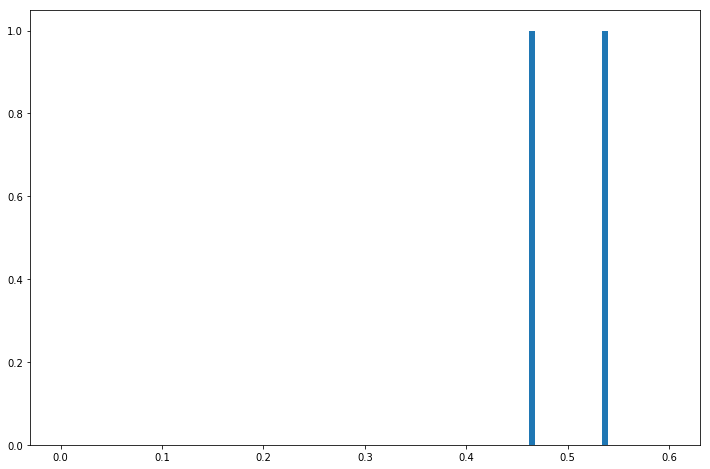

Total samples = 2
Iteration 5 SNR= 2 MEAN_ERR= 0.5000534980349756 MEDIAN_ERR= 0.5000534980349756
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756]


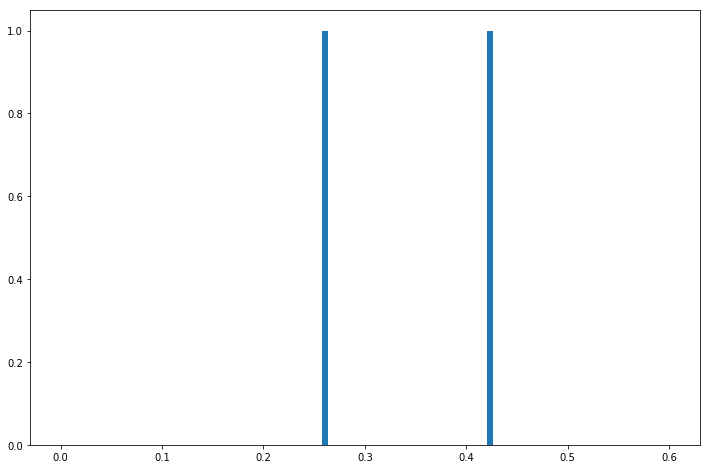

Total samples = 2
Iteration 6 SNR= 2 MEAN_ERR= 0.3418074080836877 MEDIAN_ERR= 0.3418074080836877
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877]


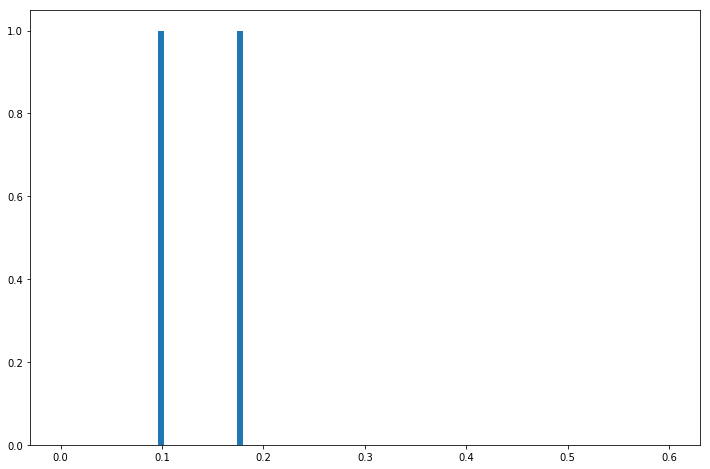

Total samples = 2
Iteration 7 SNR= 2 MEAN_ERR= 0.13925952077986636 MEDIAN_ERR= 0.13925952077986636
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636]


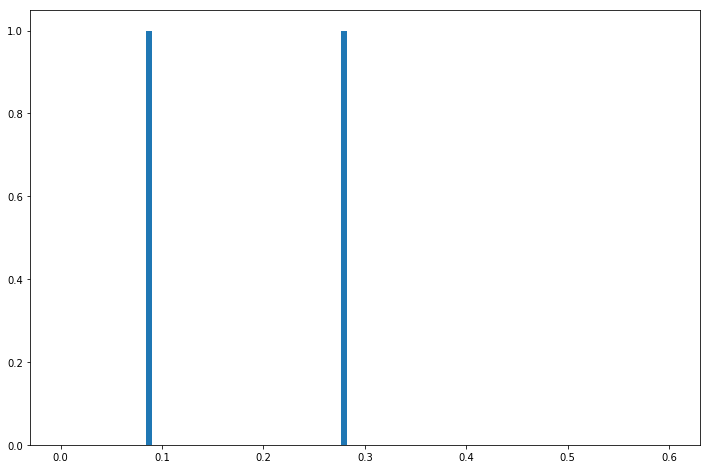

Total samples = 2
Iteration 8 SNR= 2 MEAN_ERR= 0.18268270478464319 MEDIAN_ERR= 0.18268270478464319
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319]


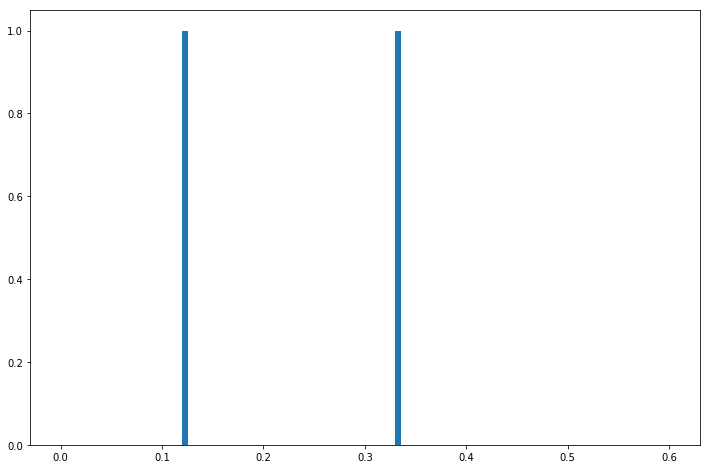

Total samples = 2
Iteration 9 SNR= 2 MEAN_ERR= 0.2277137020332186 MEDIAN_ERR= 0.2277137020332186
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186]


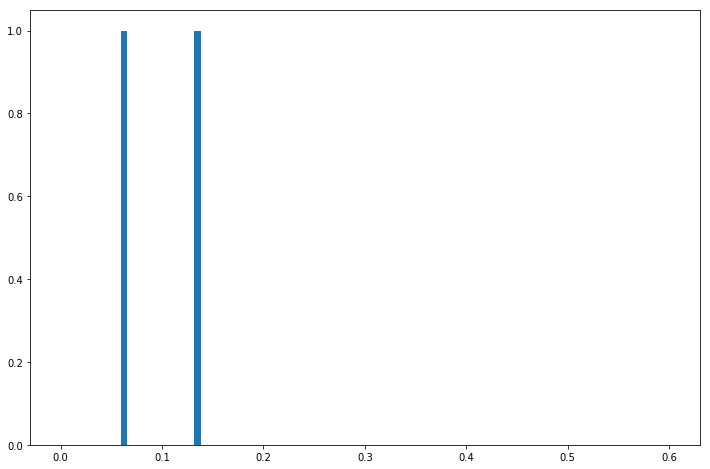

Total samples = 2
Iteration 0 SNR= 3 MEAN_ERR= 0.09982195460650325 MEDIAN_ERR= 0.09982195460650325
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325]


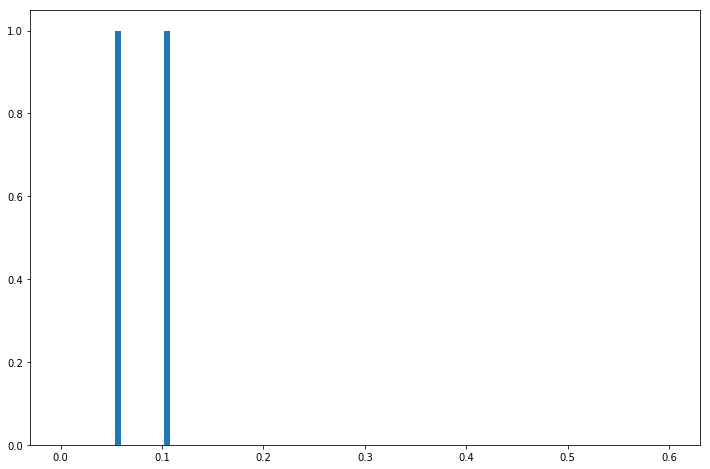

Total samples = 2
Iteration 1 SNR= 3 MEAN_ERR= 0.07887321202931827 MEDIAN_ERR= 0.07887321202931827
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827]


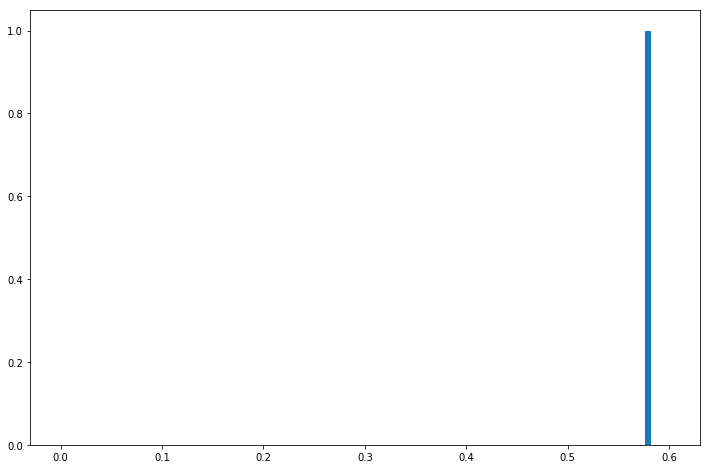

Total samples = 2
Iteration 2 SNR= 3 MEAN_ERR= 0.7898498541422374 MEDIAN_ERR= 0.7898498541422374
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374]


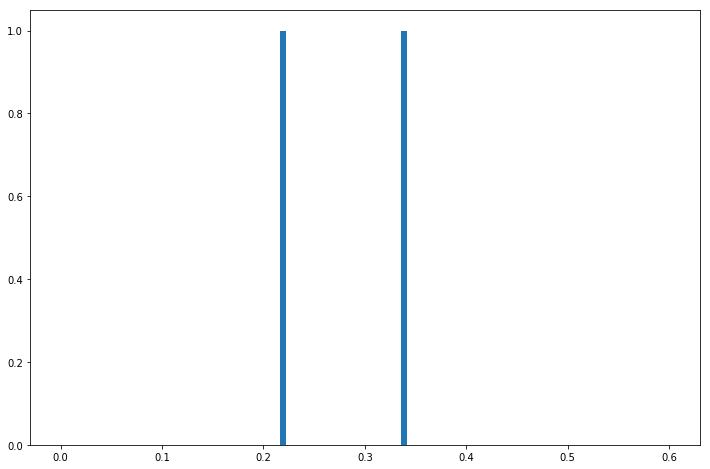

Total samples = 2
Iteration 3 SNR= 3 MEAN_ERR= 0.276819226599406 MEDIAN_ERR= 0.276819226599406
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406]


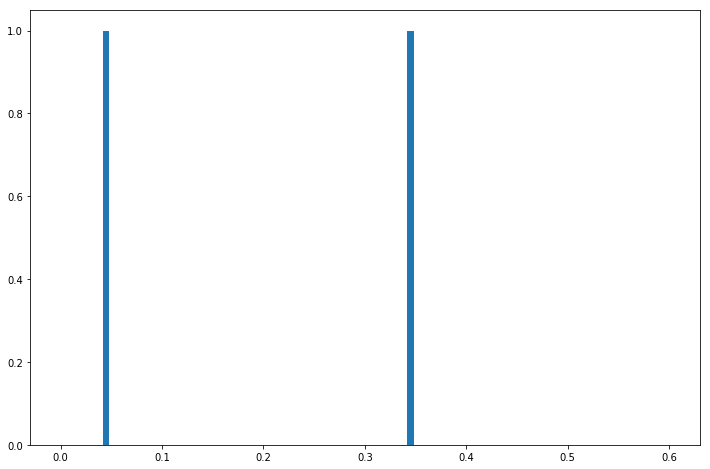

Total samples = 2
Iteration 4 SNR= 3 MEAN_ERR= 0.19484338741507085 MEDIAN_ERR= 0.19484338741507085
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085]


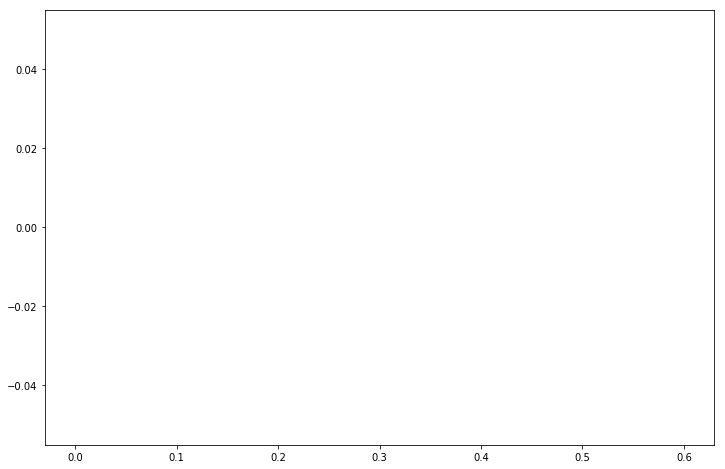

Total samples = 2
Iteration 5 SNR= 3 MEAN_ERR= 1.0100965022983899 MEDIAN_ERR= 1.0100965022983899
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899]


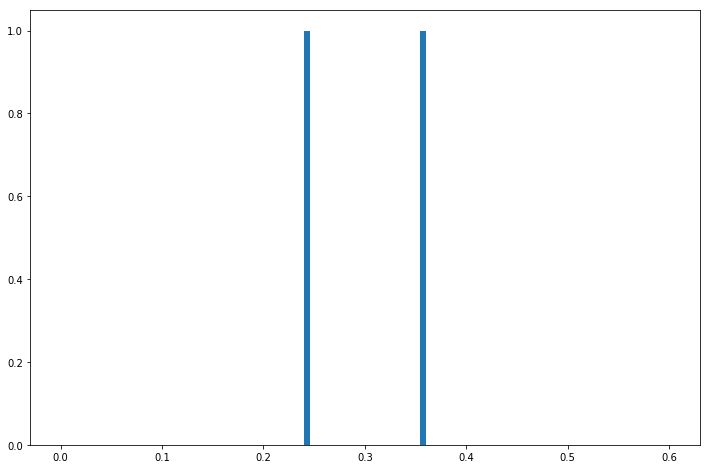

Total samples = 2
Iteration 6 SNR= 3 MEAN_ERR= 0.3003479011392206 MEDIAN_ERR= 0.3003479011392206
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206]


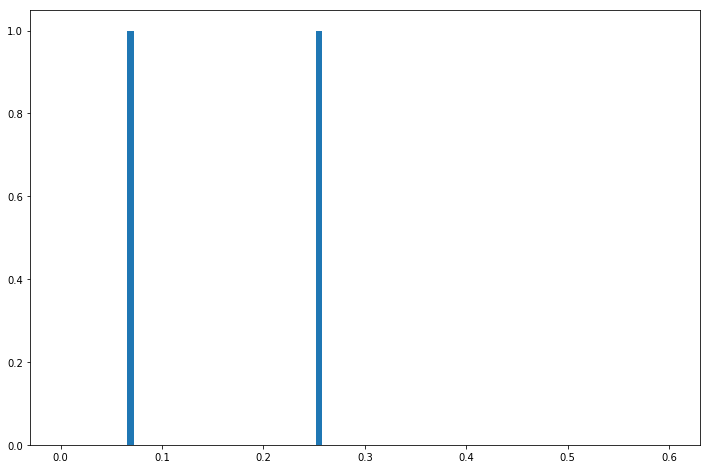

Total samples = 2
Iteration 7 SNR= 3 MEAN_ERR= 0.16003242522313776 MEDIAN_ERR= 0.16003242522313776
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776]


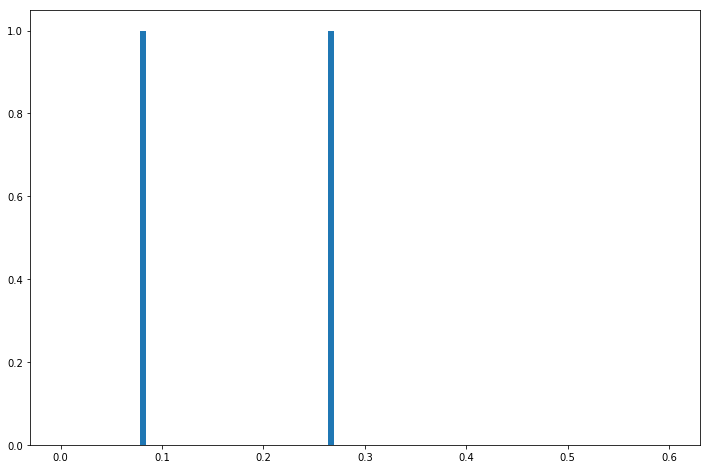

Total samples = 2
Iteration 8 SNR= 3 MEAN_ERR= 0.17409888362616727 MEDIAN_ERR= 0.17409888362616727
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727]


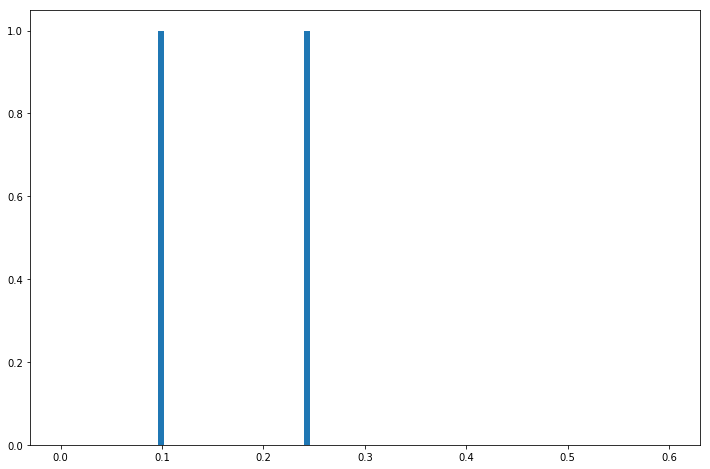

Total samples = 2
Iteration 9 SNR= 3 MEAN_ERR= 0.1709127895516728 MEDIAN_ERR= 0.1709127895516728
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728]


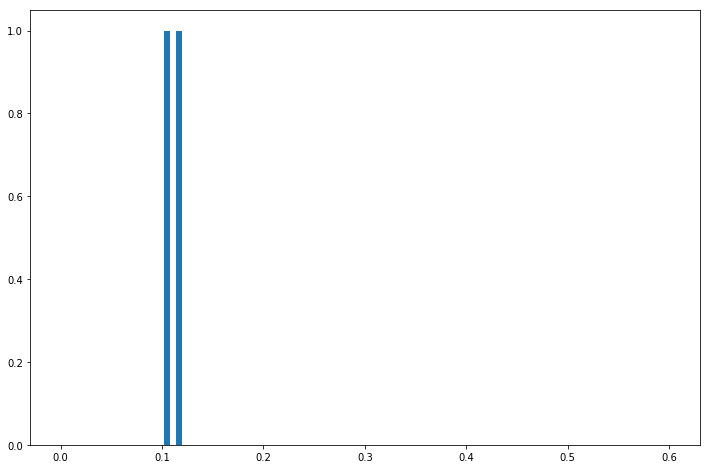

Total samples = 2
Iteration 0 SNR= 4 MEAN_ERR= 0.11141756883496384 MEDIAN_ERR= 0.11141756883496384
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384]


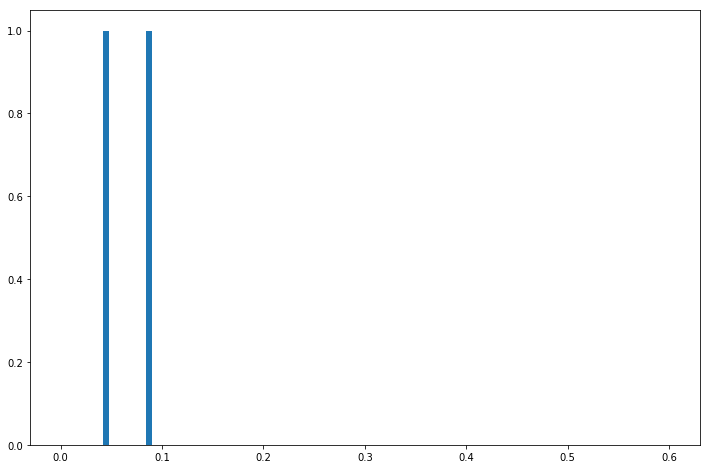

Total samples = 2
Iteration 1 SNR= 4 MEAN_ERR= 0.06853325110042838 MEDIAN_ERR= 0.06853325110042838
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384, 0.06853325110042838]


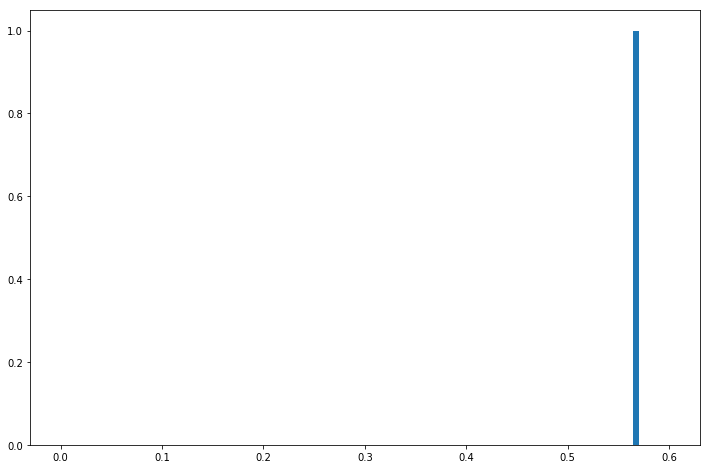

Total samples = 2
Iteration 2 SNR= 4 MEAN_ERR= 0.7716969921913064 MEDIAN_ERR= 0.7716969921913064
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384, 0.06853325110042838, 0.7716969921913064]


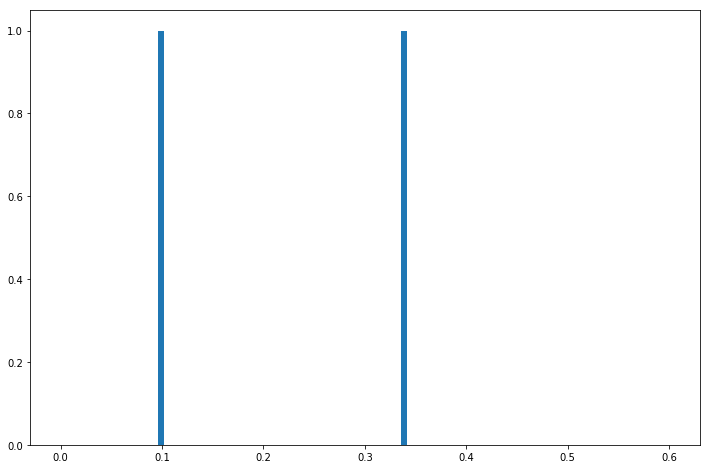

Total samples = 2
Iteration 3 SNR= 4 MEAN_ERR= 0.21952513961243172 MEDIAN_ERR= 0.21952513961243172
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384, 0.06853325110042838, 0.7716969921913064, 0.219525139612431

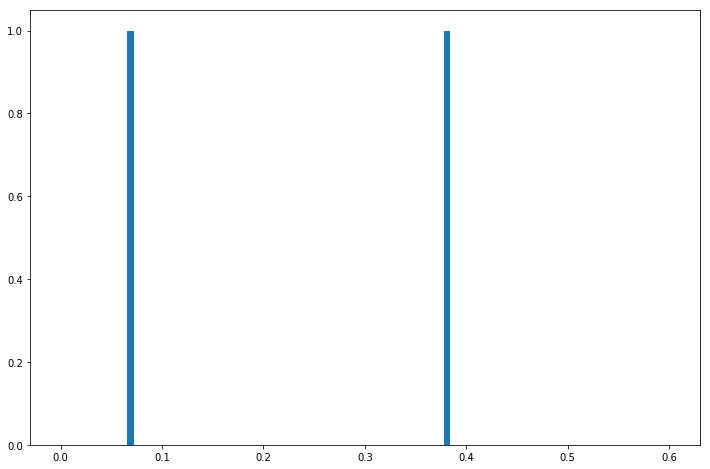

Total samples = 2
Iteration 4 SNR= 4 MEAN_ERR= 0.22604815986362214 MEDIAN_ERR= 0.22604815986362214
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384, 0.06853325110042838, 0.7716969921913064, 0.219525139612431

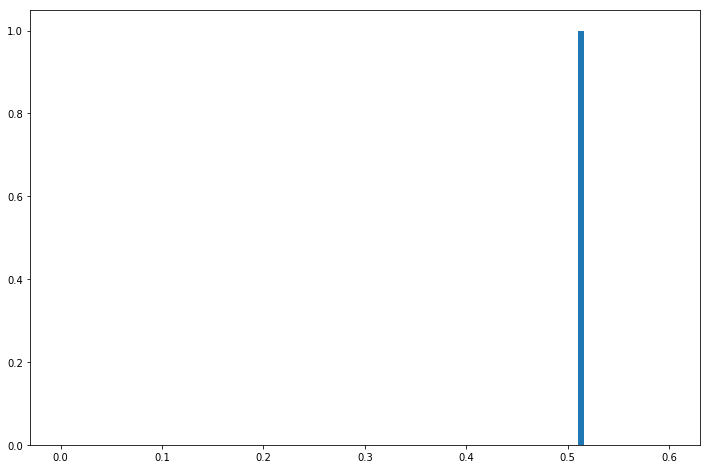

Total samples = 2
Iteration 5 SNR= 4 MEAN_ERR= 0.6512881859288229 MEDIAN_ERR= 0.6512881859288229
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384, 0.06853325110042838, 0.7716969921913064, 0.21952513961243172

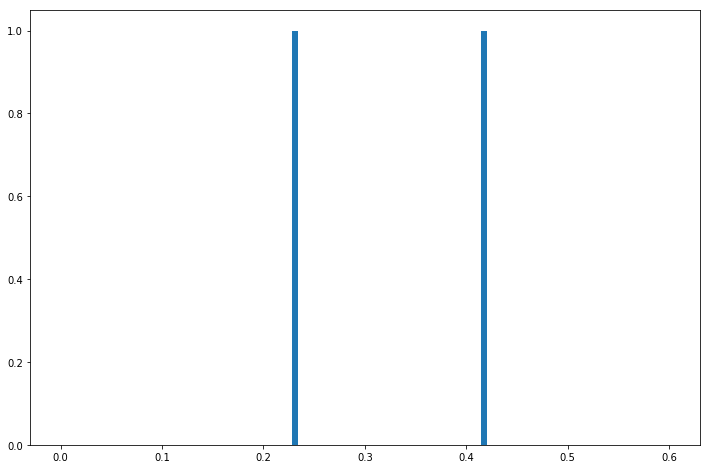

Total samples = 2
Iteration 6 SNR= 4 MEAN_ERR= 0.3240411900848883 MEDIAN_ERR= 0.3240411900848883
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384, 0.06853325110042838, 0.7716969921913064, 0.21952513961243172

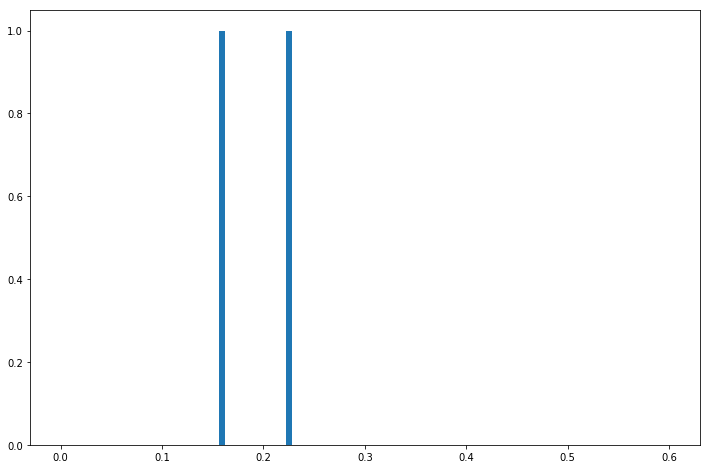

Total samples = 2
Iteration 7 SNR= 4 MEAN_ERR= 0.192830704991925 MEDIAN_ERR= 0.192830704991925
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384, 0.06853325110042838, 0.7716969921913064, 0.21952513961243172, 

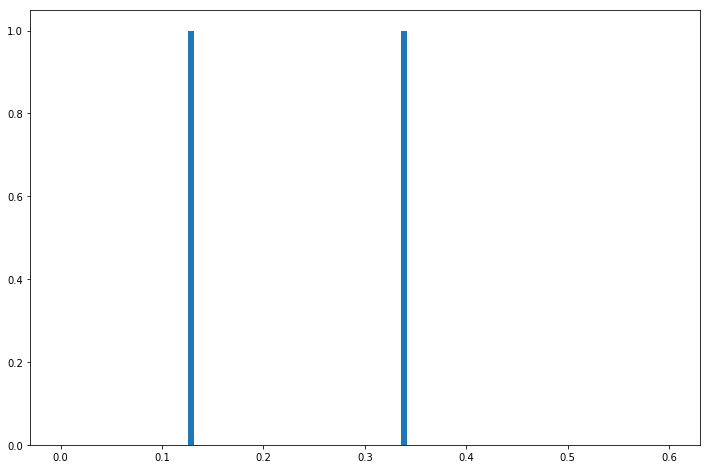

Total samples = 2
Iteration 8 SNR= 4 MEAN_ERR= 0.23589054853214858 MEDIAN_ERR= 0.23589054853214858
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384, 0.06853325110042838, 0.7716969921913064, 0.219525139612431

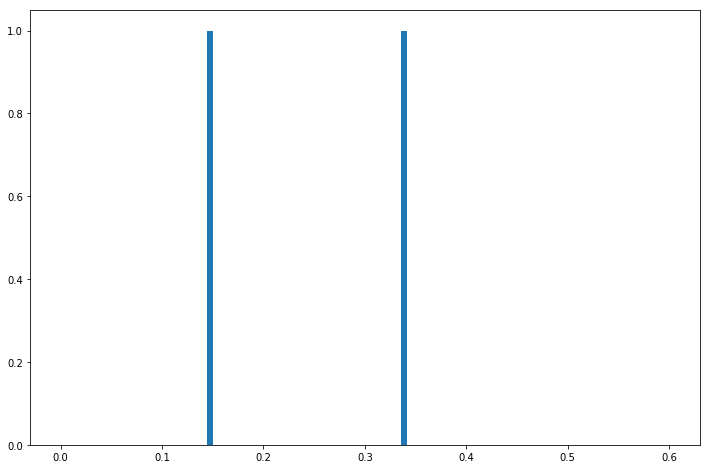

Total samples = 2
Iteration 9 SNR= 4 MEAN_ERR= 0.2429932407335702 MEDIAN_ERR= 0.2429932407335702
[0.10106263857284258, 0.11729435119386444, 0.3980242945448038, 0.16124785129296867, 0.13682524357315362, 0.44071808964659265, 0.0780796123975655, 0.09236092519637118, 0.20711364494306927, 0.14726491818779022, 0.06844930013322181, 0.08832485983101171, 0.733366620299108, 0.3578281738505456, 0.14328990014011167, 0.2996861234810617, 0.41072922411034174, 0.17853147634330668, 0.1714512935761042, 0.18995946354295323, 0.10456895021348107, 0.0862591984753549, 0.6286184364696512, 0.3150419217152967, 0.23468871082824835, 0.5000534980349756, 0.3418074080836877, 0.13925952077986636, 0.18268270478464319, 0.2277137020332186, 0.09982195460650325, 0.07887321202931827, 0.7898498541422374, 0.276819226599406, 0.19484338741507085, 1.0100965022983899, 0.3003479011392206, 0.16003242522313776, 0.17409888362616727, 0.1709127895516728, 0.11141756883496384, 0.06853325110042838, 0.7716969921913064, 0.21952513961243172

In [17]:
plot_hist=True
n=len(net_file_list)

for net_file in range(n):
    l=[]
    print(net_file_list[net_file])
    for SNR_sim in range(5):
        for j in range(10):
            ellipX = np.array(ellip_measures_target)
            ellipY = np.array(ellip_measures[net_file][SNR_sim][j])
            err = []
            for i in range(len(ellipY)):
                if (np.abs(ellipX[i]) > 1).any() or (np.abs(ellipY[i]) > 1).any():
                    continue
                err.append(np.linalg.norm(ellipX[i]-ellipY[i]))
            if plot_hist:
                plt.figure()
                plt.hist(err, 100, range=(0,0.6))
                plt.show()
                print('Total samples = %d' %len(err))
            l.append(np.median(err))
            print("Iteration",j,"SNR=",SNR_sim,"MEAN_ERR=",np.mean(err),"MEDIAN_ERR=",np.median(err))
            print(l)
            

FCS_Euclid_10000_SNR40_lowr.fits


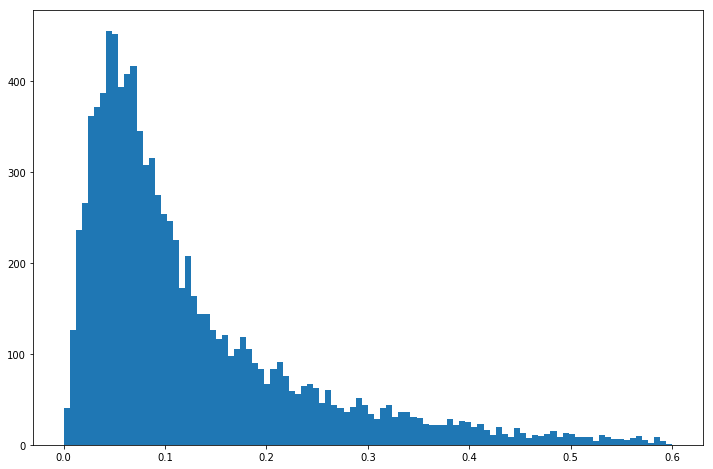

Total samples = 9645
MEAN_ERR= 0.13428713297195907 MEDIAN_ERR= 0.08858139144360357


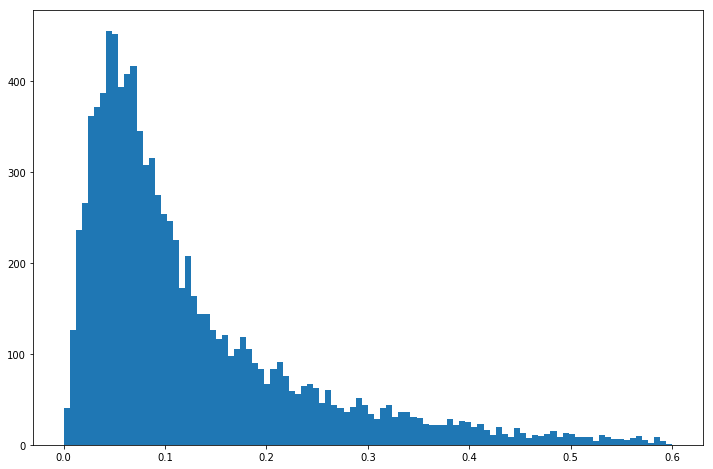

Total samples = 9645
MEAN_ERR= 0.13428713297195907 MEDIAN_ERR= 0.08858139144360357


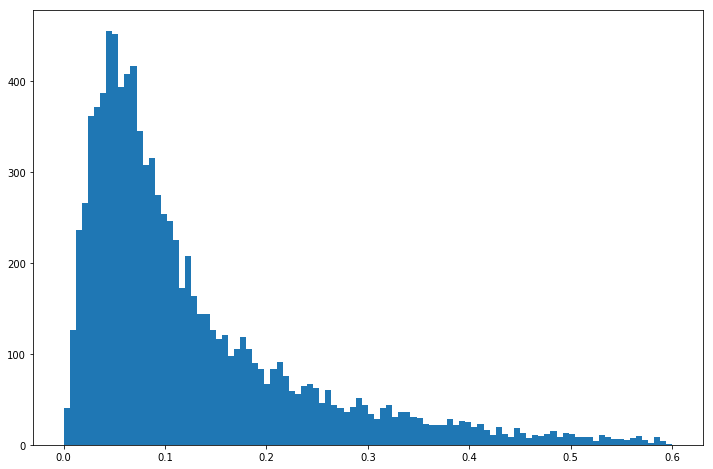

Total samples = 9645
MEAN_ERR= 0.13428713297195907 MEDIAN_ERR= 0.08858139144360357


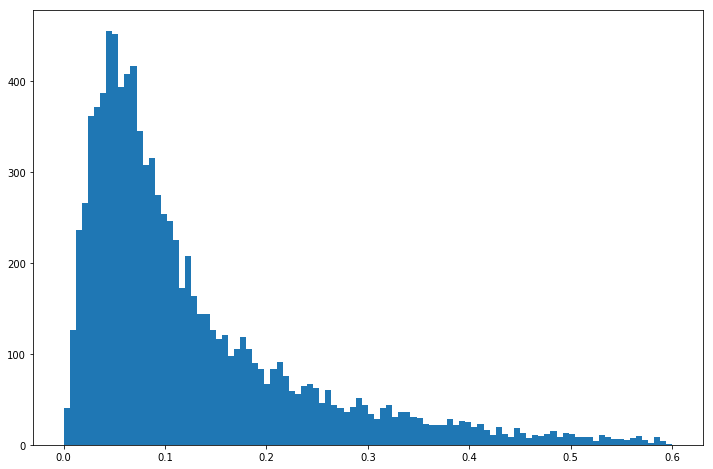

Total samples = 9645
MEAN_ERR= 0.13428713297195907 MEDIAN_ERR= 0.08858139144360357


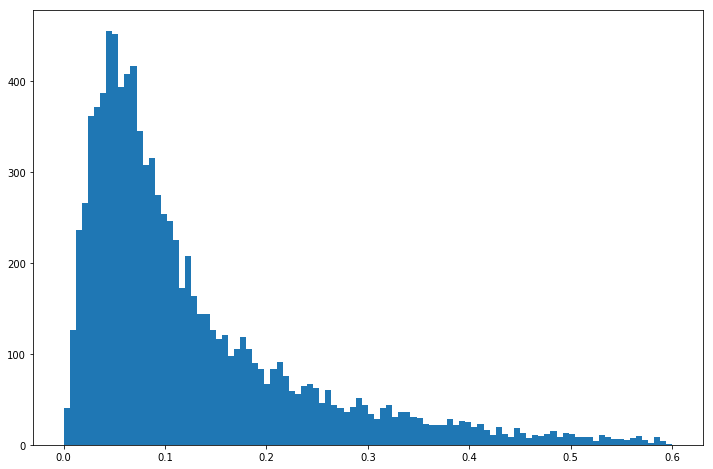

Total samples = 9645
MEAN_ERR= 0.13428713297195907 MEDIAN_ERR= 0.08858139144360357
FCS_Euclid_10000_SNR40_sparse_new.fits


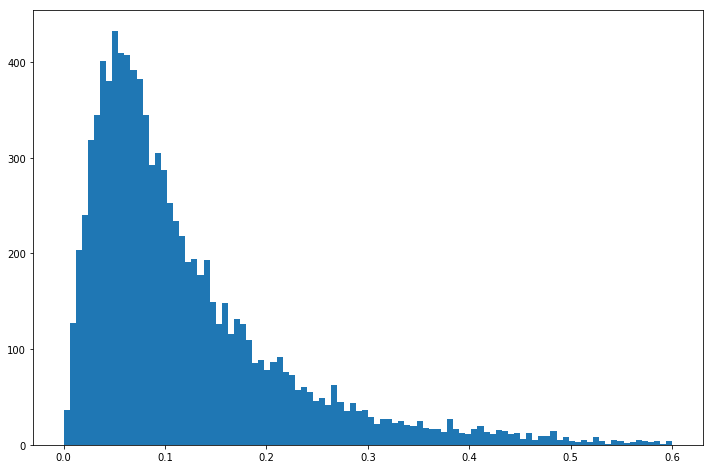

Total samples = 9529
MEAN_ERR= 0.12843595277830092 MEDIAN_ERR= 0.09097650277021248


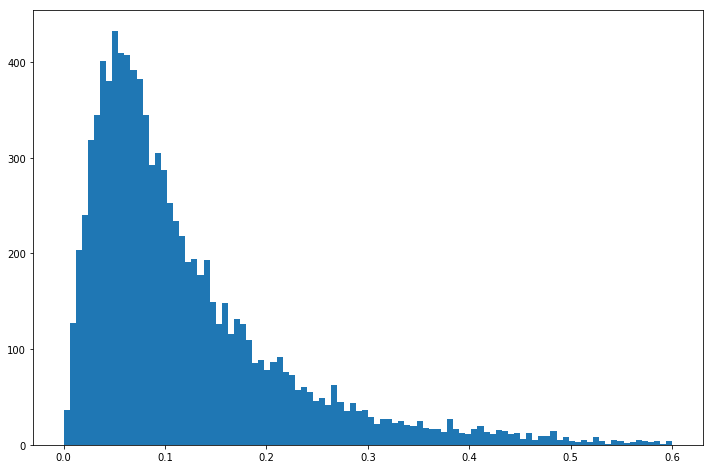

Total samples = 9529
MEAN_ERR= 0.12843595277830092 MEDIAN_ERR= 0.09097650277021248


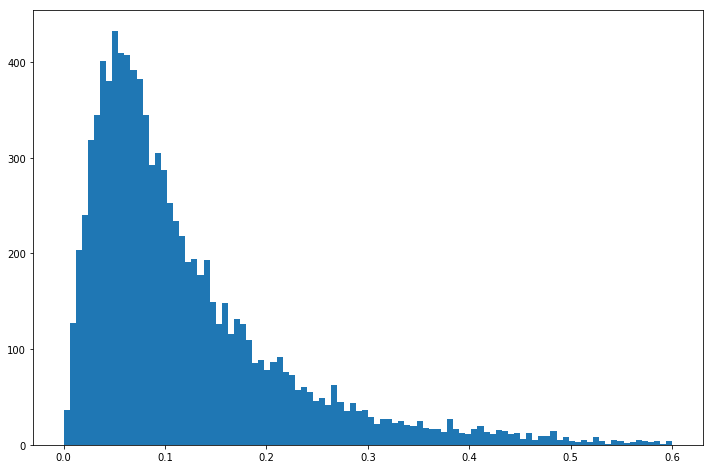

Total samples = 9529
MEAN_ERR= 0.12843595277830092 MEDIAN_ERR= 0.09097650277021248


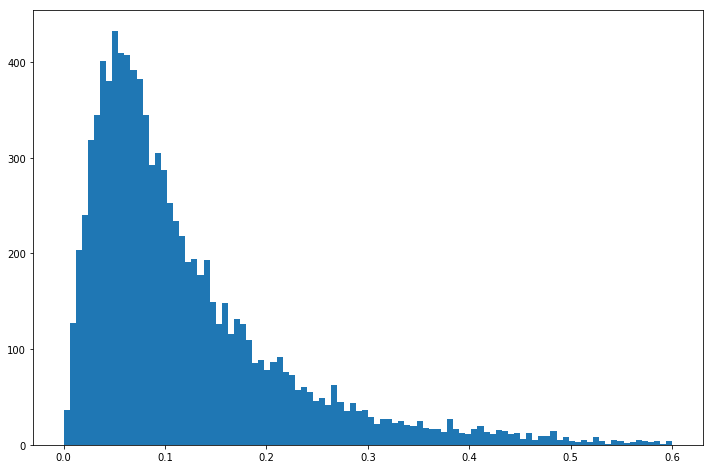

Total samples = 9529
MEAN_ERR= 0.12843595277830092 MEDIAN_ERR= 0.09097650277021248


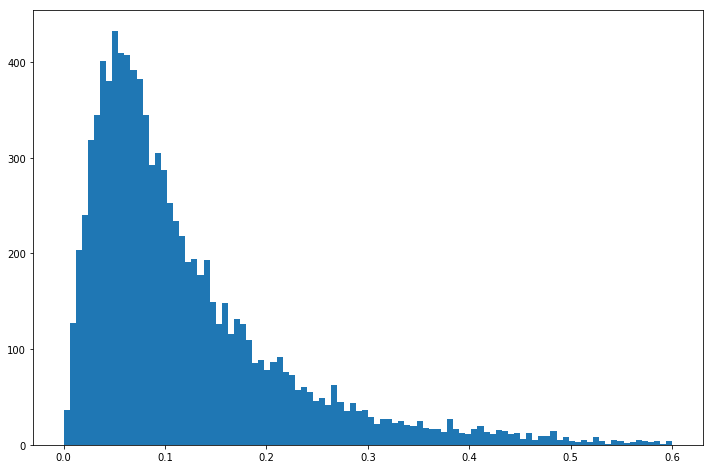

Total samples = 9529
MEAN_ERR= 0.12843595277830092 MEDIAN_ERR= 0.09097650277021248


In [25]:
plot_hist=True
n=len(sota_file_list)

for sota_file in range(n):
    print(sota_file_list[sota_file])
    for SNR_sim in range(5):
        ellipX = np.array(ellip_measures_target)
        ellipY = np.array(ellip_measures_lowr_sparse[sota_file])
        err = []
        for i in range(len(ellipY)):
            if (np.abs(ellipX[i]) > 1).any() or (np.abs(ellipY[i]) > 1).any():
                continue
            err.append(np.linalg.norm(ellipX[i]-ellipY[i]))
        if plot_hist:
            plt.figure()
            plt.hist(err, 100, range=(0,0.6))
            plt.show()
            print('Total samples = %d' %len(err))
        print("MEAN_ERR=",np.mean(err),"MEDIAN_ERR=",np.median(err))
        

In [ ]:
list_targets=fits2npy(testset_path+'window/'+target_name_win)
list_psfs=fits2npy("/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-0-multihdu.fits",psf_hdu)
ellip_target=[]
for j in range(10000):
    #we create a galsim version of Y
    target_galsim = Image(list_preds[j])
    psf_galsim = Image(list_psfs[j])
    #we estimate the moments of Y
    ellip_list.append(galsim.hsm.EstimateShear(target_galsim, psf_galsim,shear_est='KSB',strict=False))


In [27]:
used_cores=np.min((len(SNR_list_sim),sm.cpu_count()-2))  

for net_file in net_file_list:
    print(net_file)
    with sharedmem_pool(used_cores) as pool:
        def work(i):
            SNR_sim=SNR_list_sim[i]
            mosaic_name=testset_file.replace('.fits','-'+net_file.replace('.hdf5','_testSNR{0}.fits'.format(SNR_sim)))
            if os.path.isfile(write_path+'images/'+mosaic_name):
                ellip_filename=write_path+'ellip/'+mosaic_name.replace('.fits','_ellipmes_targetweights_newwin.fits'.format(SNR_sim))
                save_weights=testset_path+'window/'+'N'+target_name_win.replace('.fits','_weights_newwin.fits')
                if not os.path.isfile(ellip_filename):
                    with pool.critical:
                        print("Compte Ellip {0}".format(mosaic_name) )
                    cmd_file = '../scripts/fast_get_shape/get_shape_{0}.cmd'.format(mosaic_name.replace('.fits','_ellipmes_targetweights_newwin'))
                    #The option -i means we input the windows per galaxy in save_weights
                    _,_=fast_generate_shape(write_path+'images/'+mosaic_name, psf_file, ellip_filename,cmd_file=cmd_file, mosaic_size=100, save_weights=save_weights, weights_input='-i')
            else:
                with pool.critical:
                    print("not existing {0}".format(mosaic_name) )
        pool.map(work, range(len(SNR_list_sim)))
    






ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_gamma0.001_restart.hdf5
ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_gamma0.01_restart.hdf5
ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_with_mom_test_restart_ratio2_newtest.hdf5


#### c)  Now compute the ellipticity error based on the two measures of ellipticity

ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_gamma0.001_restart.hdf5
Compte Ellip error image-shfl-0-multihdu-ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_gamma0.001_restart_testSNR20.fits


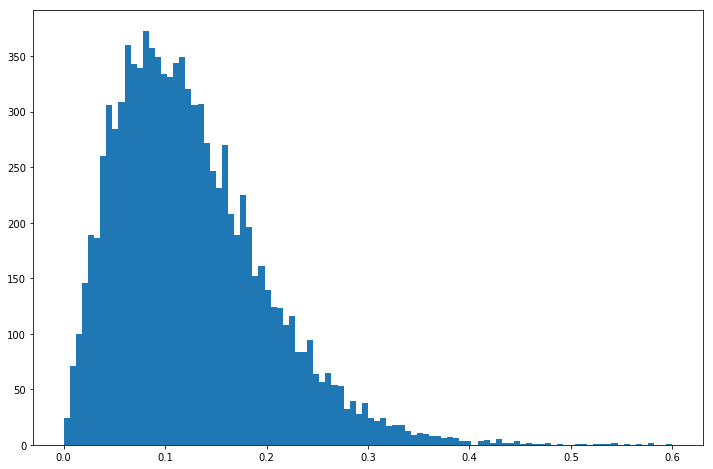

Total samples = 9987
SNR= 20 MEAN_ERR= 0.12579708 MEDIAN_ERR= 0.113859855
Compte Ellip error image-shfl-0-multihdu-ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_gamma0.001_restart_testSNR40.fits


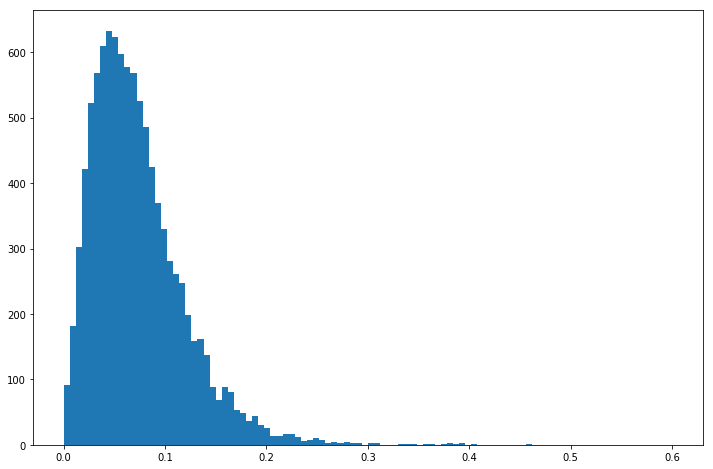

Total samples = 9984
SNR= 40 MEAN_ERR= 0.072939776 MEDIAN_ERR= 0.0645165
Compte Ellip error image-shfl-0-multihdu-ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_gamma0.001_restart_testSNR60.fits


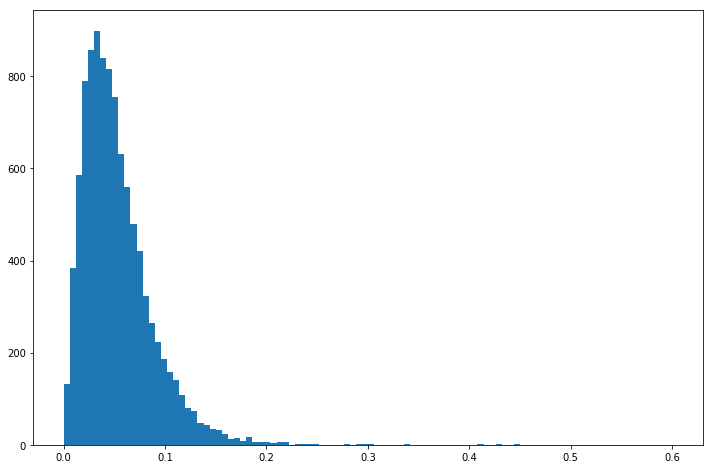

Total samples = 9986
SNR= 60 MEAN_ERR= 0.052578457 MEDIAN_ERR= 0.045715295
Compte Ellip error image-shfl-0-multihdu-ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_gamma0.001_restart_testSNR80.fits


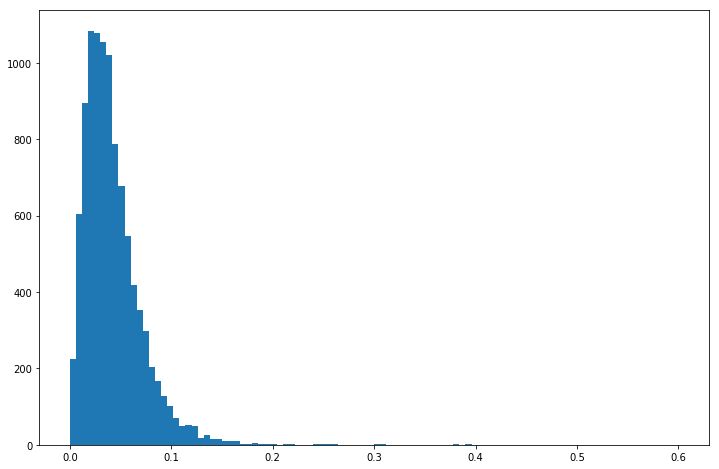

Total samples = 9987
SNR= 80 MEAN_ERR= 0.04197634 MEDIAN_ERR= 0.036292687
Compte Ellip error image-shfl-0-multihdu-ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_gamma0.001_restart_testSNR100.fits


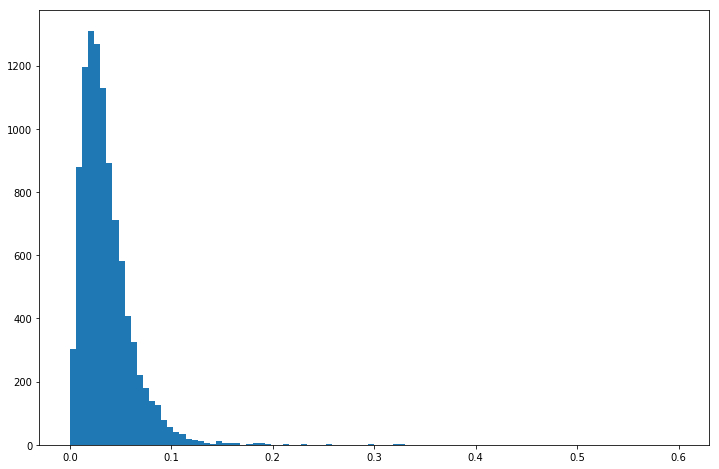

Total samples = 9985
SNR= 100 MEAN_ERR= 0.03547041 MEDIAN_ERR= 0.030213457
ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_gamma0.01_restart.hdf5
Compte Ellip error image-shfl-0-multihdu-ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_gamma0.01_restart_testSNR20.fits


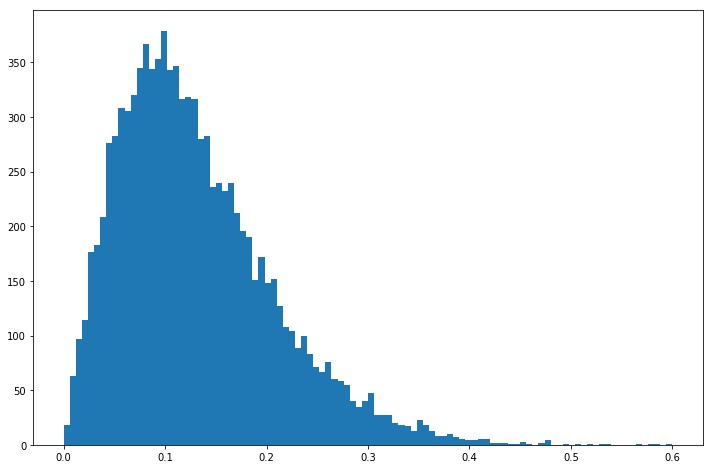

Total samples = 9968
SNR= 20 MEAN_ERR= 0.1316178 MEDIAN_ERR= 0.11686903
Compte Ellip error image-shfl-0-multihdu-ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_gamma0.01_restart_testSNR40.fits


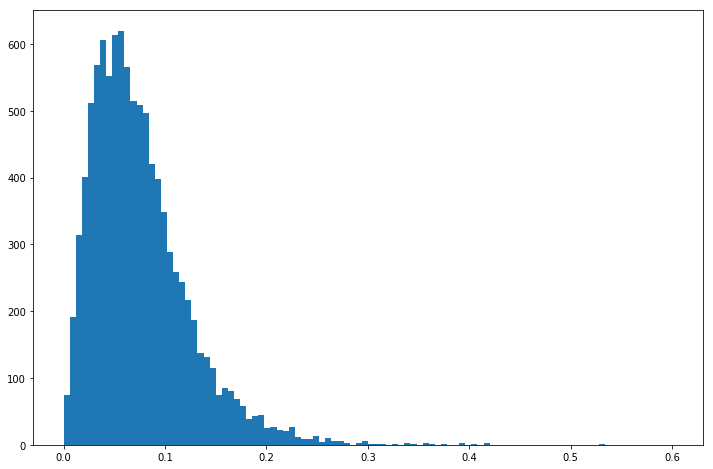

Total samples = 9988
SNR= 40 MEAN_ERR= 0.07489235 MEDIAN_ERR= 0.06572923
Compte Ellip error image-shfl-0-multihdu-ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_gamma0.01_restart_testSNR60.fits


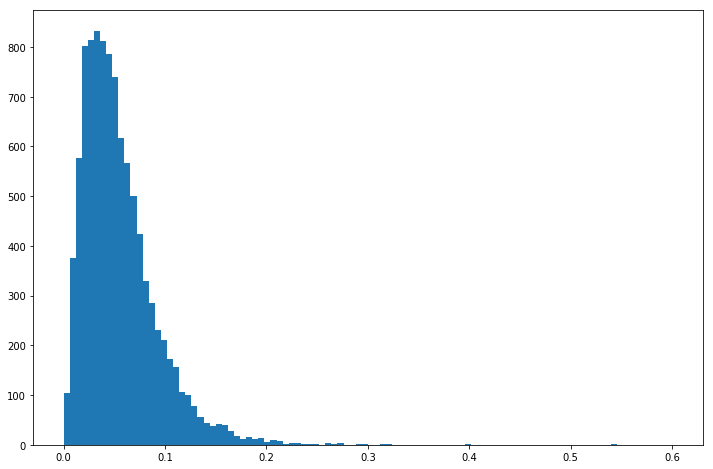

Total samples = 9986
SNR= 60 MEAN_ERR= 0.0546437 MEDIAN_ERR= 0.047158014
Compte Ellip error image-shfl-0-multihdu-ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_gamma0.01_restart_testSNR80.fits


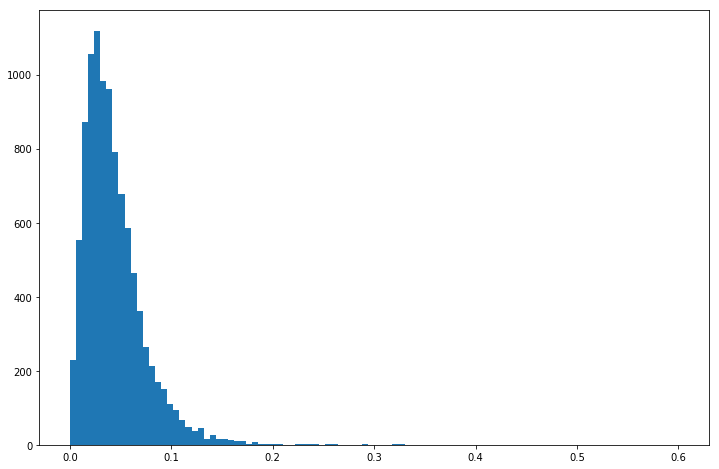

Total samples = 9986
SNR= 80 MEAN_ERR= 0.043164767 MEDIAN_ERR= 0.037094563
Compte Ellip error image-shfl-0-multihdu-ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_gamma0.01_restart_testSNR100.fits


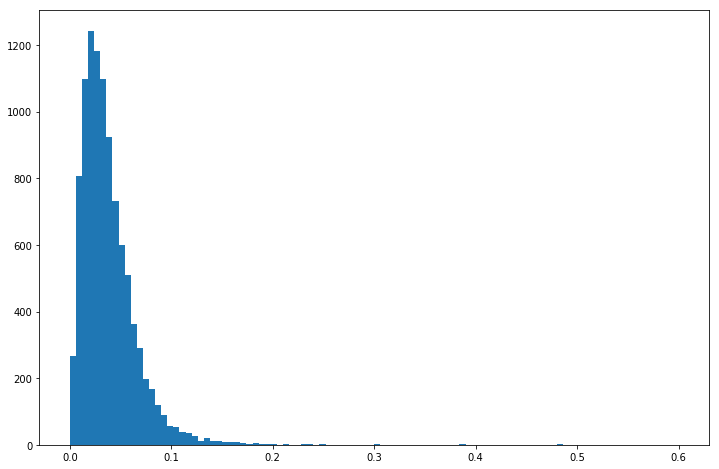

Total samples = 9988
SNR= 100 MEAN_ERR= 0.03756394 MEDIAN_ERR= 0.03208296
ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_with_mom_test_restart_ratio2_newtest.hdf5
Compte Ellip error image-shfl-0-multihdu-ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_with_mom_test_restart_ratio2_newtest_testSNR20.fits


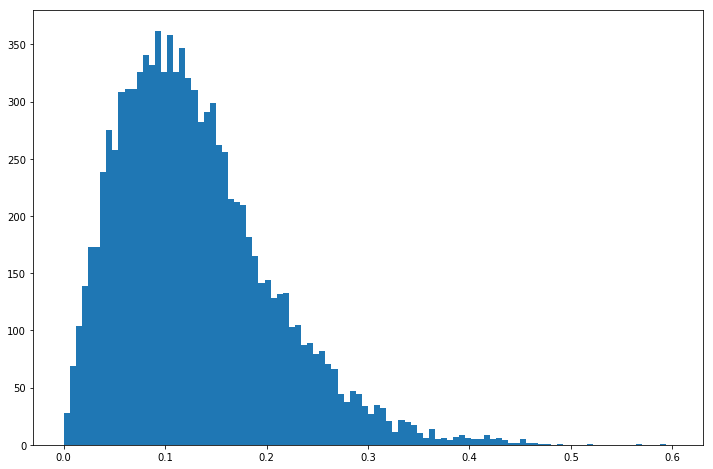

Total samples = 9984
SNR= 20 MEAN_ERR= 0.13039014 MEDIAN_ERR= 0.1181785
Compte Ellip error image-shfl-0-multihdu-ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_with_mom_test_restart_ratio2_newtest_testSNR40.fits


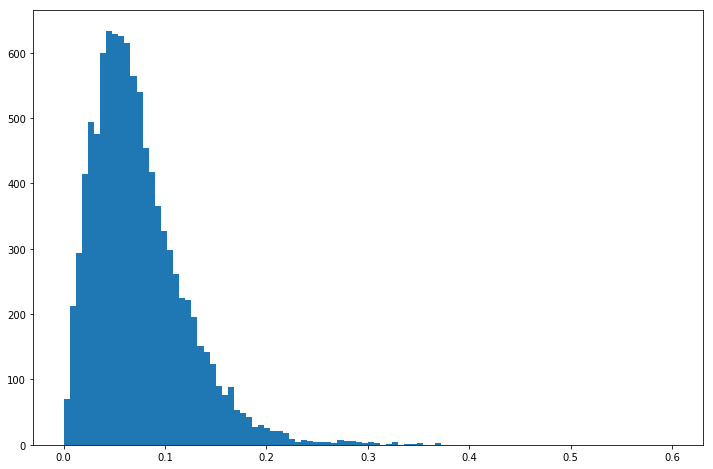

Total samples = 9985
SNR= 40 MEAN_ERR= 0.07413976 MEDIAN_ERR= 0.06527857
Compte Ellip error image-shfl-0-multihdu-ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_with_mom_test_restart_ratio2_newtest_testSNR60.fits


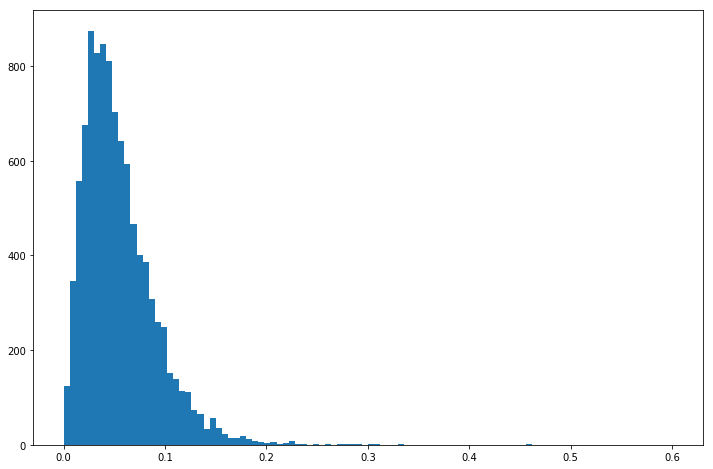

Total samples = 9984
SNR= 60 MEAN_ERR= 0.054800175 MEDIAN_ERR= 0.04738693
Compte Ellip error image-shfl-0-multihdu-ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_with_mom_test_restart_ratio2_newtest_testSNR80.fits


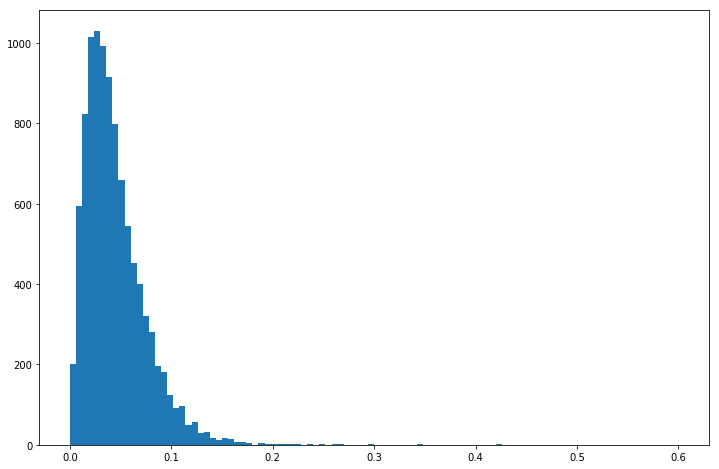

Total samples = 9985
SNR= 80 MEAN_ERR= 0.044470478 MEDIAN_ERR= 0.037961967
Compte Ellip error image-shfl-0-multihdu-ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_with_mom_test_restart_ratio2_newtest_testSNR100.fits


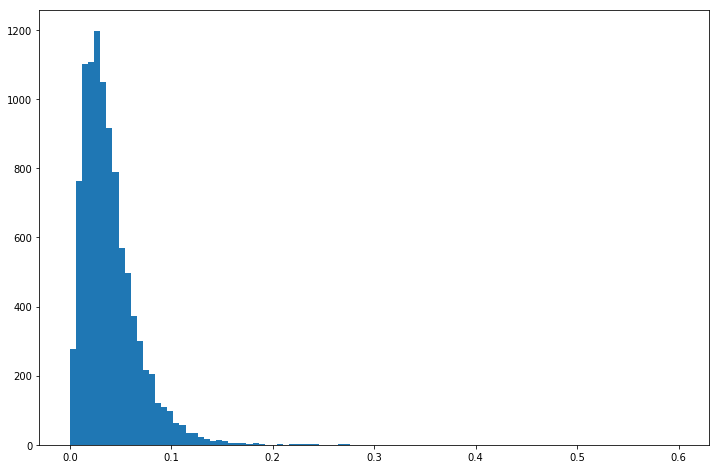

Total samples = 9985
SNR= 100 MEAN_ERR= 0.03900535 MEDIAN_ERR= 0.03303645


In [30]:
ellip_filename_ref=testset_path+'window/'+'N'+target_name_win.replace('.fits','_ellipmesnewwin.fits')

for net_file in net_file_list:
    print(net_file)
    with sharedmem_pool(1) as pool:
        def work(i):
            SNR_sim=SNR_list_sim[i]
            mosaic_name=testset_file.replace('.fits','-'+net_file.replace('.hdf5','_testSNR{0}.fits'.format(SNR_sim)))
            
            if os.path.isfile(write_path+'images/'+mosaic_name):
                ellip_filename=write_path+'ellip/'+mosaic_name.replace('.fits','_ellipmes_targetweights_newwin.fits'.format(SNR_sim))
                if os.path.isfile(ellip_filename):
                    with pool.critical:
                        print("Compte Ellip error {0}".format(mosaic_name) )
                        ell_err=compute_ellipticity_error(ellip_filename_ref, ellip_filename, plot_hist=True, max_idx=10000)
                        print("SNR=",SNR_sim,"MEAN_ERR=",np.mean(ell_err),"MEDIAN_ERR=",np.median(ell_err))
            else:
                with pool.critical:
                    print("not existing {0}".format(mosaic_name) )

        pool.map(work, range(len(SNR_list_sim)))
    


